In [1]:
import copy
import ctypes
import gc
import itertools
import os
import pickle
import pprint
import random
import re
import time
import warnings
from collections import Counter, defaultdict
from functools import reduce
from itertools import cycle
from random import choice, choices

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

# import catboost as cb
import optuna
import pandas as pd
import polars as pl
import seaborn as sns
import sklearn
import torch
import umap
import xgboost as xgb
from catboost import CatBoostRegressor
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    preprocessing,
    tree,
)
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

# from gensim.models import Word2Vec
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    PowerTransformer,
    RobustScaler,
)
from sklearn.svm import SVR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm
from tqdm.autonotebook import tqdm
from xgboost import XGBRegressor

libc = ctypes.CDLL("libc.so.6")  # clear the memory

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.__version__

'2.0.3'

In [3]:
lgb.__version__

'3.3.2'

In [4]:
class MyConfig:
    INPUT_DIR = "./data"
    seed = 42
    is_time_in_secs = True
    time_divider = 1000 if is_time_in_secs else 1

    num_folds = 10
    num_estimators = 12001
    num_trials_early_stopping = 200

    response_variate = "score"
    is_local = False
    use_optuna_tuning = True
    test_size_local = 0.2
    num_trials_optuna = 50

    num_features_to_display = 50
    vector_size = 64

    use_token_features = False
    use_vif_feature_selection = True
    use_lasso_feature_selection = True
    use_shap_feature_selection = True

In [5]:
cnfg = MyConfig()

In [6]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(cnfg.seed)

In [7]:
tqdm.pandas()
sns.set_style("whitegrid")
warnings.simplefilter("ignore")
random.seed(cnfg.seed)
np.random.seed(cnfg.seed)

# Import Data

In [8]:
traindf = pd.read_csv(f"{cnfg.INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{cnfg.INPUT_DIR}/train_scores.csv")

if cnfg.is_local:
    train_scores, test_scores = train_test_split(
        train_scores,
        test_size=cnfg.test_size_local,
        random_state=cnfg.seed,
        stratify=train_scores.score,
    )
    train_scores = train_scores.reset_index(drop=True)
    test_scores = test_scores.reset_index(drop=True)
    testdf = traindf[traindf.id.isin(test_scores.id.unique())].reset_index(drop=True)
    traindf = traindf[traindf.id.isin(train_scores.id.unique())].reset_index(drop=True)
else:
    testdf = pd.read_csv(f"{cnfg.INPUT_DIR}/test_logs.csv")

In [9]:
traindf.shape, testdf.shape

((8405898, 11), (6, 11))

### 165 Features ####

In [10]:
num_cols = ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
events = [
    "q",
    "Space",
    "Backspace",
    "Shift",
    "ArrowRight",
    "Leftclick",
    "ArrowLeft",
    ".",
    ",",
    "ArrowDown",
    "ArrowUp",
    "Enter",
    "CapsLock",
    "'",
    "Delete",
    "Unidentified",
]
text_changes = ["q", " ", ".", ",", "\n", "'", '"', "-", "?", ";", "=", "/", "\\", ":"]


def count_by_values(df, colname, values):
    fts = df.select(pl.col("id").unique(maintain_order=True))
    for i, value in enumerate(values):
        tmp_df = df.group_by("id").agg(
            pl.col(colname).is_in([value]).sum().alias(f"{colname}_{i}_cnt")
        )
        fts = fts.join(tmp_df, on="id", how="left")
    return fts


def dev_feats(df):
    print("< Count by values features >")

    feats = count_by_values(df, "activity", activities)
    feats = feats.join(
        count_by_values(df, "text_change", text_changes), on="id", how="left"
    )
    feats = feats.join(count_by_values(df, "down_event", events), on="id", how="left")
    feats = feats.join(count_by_values(df, "up_event", events), on="id", how="left")

    print("< Input words stats features >")

    temp = df.filter(
        (~pl.col("text_change").str.contains("=>"))
        & (pl.col("text_change") != "NoChange")
    )
    temp = temp.group_by("id").agg(
        pl.col("text_change").str.concat("").str.extract_all(r"q+")
    )
    temp = temp.with_columns(
        input_word_count=pl.col("text_change").list.lengths(),
        input_word_length_mean=pl.col("text_change").apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        ),
        input_word_length_max=pl.col("text_change").apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        ),
        input_word_length_std=pl.col("text_change").apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        ),
        input_word_length_median=pl.col("text_change").apply(
            lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0)
        ),
        input_word_length_skew=pl.col("text_change").apply(
            lambda x: skew([len(i) for i in x] if len(x) > 0 else 0)
        ),
    )
    temp = temp.drop("text_change")
    feats = feats.join(temp, on="id", how="left")

    print("< Numerical columns features >")

    temp = df.group_by("id").agg(
        pl.sum("action_time").suffix("_sum"),
        pl.mean(num_cols).suffix("_mean"),
        pl.std(num_cols).suffix("_std"),
        pl.median(num_cols).suffix("_median"),
        pl.min(num_cols).suffix("_min"),
        pl.max(num_cols).suffix("_max"),
        pl.quantile(num_cols, 0.5).suffix("_quantile"),
    )
    feats = feats.join(temp, on="id", how="left")

    print("< Categorical columns features >")

    temp = df.group_by("id").agg(
        pl.n_unique(["activity", "down_event", "up_event", "text_change"])
    )
    feats = feats.join(temp, on="id", how="left")

    print("< Idle time features >")

    temp = df.with_columns(pl.col("up_time").shift().over("id").alias("up_time_lagged"))
    temp = temp.with_columns(
        (abs(pl.col("down_time") - pl.col("up_time_lagged")) / 1000)
        .fill_null(0)
        .alias("time_diff")
    )
    temp = temp.filter(pl.col("activity").is_in(["Input", "Remove/Cut"]))
    temp = temp.group_by("id").agg(
        inter_key_largest_lantency=pl.max("time_diff"),
        inter_key_median_lantency=pl.median("time_diff"),
        mean_pause_time=pl.mean("time_diff"),
        std_pause_time=pl.std("time_diff"),
        total_pause_time=pl.sum("time_diff"),
        pauses_half_sec=pl.col("time_diff")
        .filter((pl.col("time_diff") > 0.5) & (pl.col("time_diff") < 1))
        .count(),
        pauses_1_sec=pl.col("time_diff")
        .filter((pl.col("time_diff") > 1) & (pl.col("time_diff") < 1.5))
        .count(),
        pauses_1_half_sec=pl.col("time_diff")
        .filter((pl.col("time_diff") > 1.5) & (pl.col("time_diff") < 2))
        .count(),
        pauses_2_sec=pl.col("time_diff")
        .filter((pl.col("time_diff") > 2) & (pl.col("time_diff") < 3))
        .count(),
        pauses_3_sec=pl.col("time_diff").filter(pl.col("time_diff") > 3).count(),
    )
    feats = feats.join(temp, on="id", how="left")

    print("< P-bursts features >")

    temp = df.with_columns(pl.col("up_time").shift().over("id").alias("up_time_lagged"))
    temp = temp.with_columns(
        (abs(pl.col("down_time") - pl.col("up_time_lagged")) / 1000)
        .fill_null(0)
        .alias("time_diff")
    )
    temp = temp.filter(pl.col("activity").is_in(["Input", "Remove/Cut"]))
    temp = temp.with_columns(pl.col("time_diff") < 2)
    temp = temp.with_columns(
        pl.when(pl.col("time_diff") & pl.col("time_diff").is_last())
        .then(pl.count())
        .over(pl.col("time_diff").rle_id())
        .alias("P-bursts")
    )
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(
        pl.mean("P-bursts").suffix("_mean"),
        pl.std("P-bursts").suffix("_std"),
        pl.count("P-bursts").suffix("_count"),
        pl.median("P-bursts").suffix("_median"),
        pl.max("P-bursts").suffix("_max"),
        pl.first("P-bursts").suffix("_first"),
        pl.last("P-bursts").suffix("_last"),
    )
    feats = feats.join(temp, on="id", how="left")

    print("< R-bursts features >")

    temp = df.filter(pl.col("activity").is_in(["Input", "Remove/Cut"]))
    temp = temp.with_columns(pl.col("activity").is_in(["Remove/Cut"]))
    temp = temp.with_columns(
        pl.when(pl.col("activity") & pl.col("activity").is_last())
        .then(pl.count())
        .over(pl.col("activity").rle_id())
        .alias("R-bursts")
    )
    temp = temp.drop_nulls()
    temp = temp.group_by("id").agg(
        pl.mean("R-bursts").suffix("_mean"),
        pl.std("R-bursts").suffix("_std"),
        pl.median("R-bursts").suffix("_median"),
        pl.max("R-bursts").suffix("_max"),
        pl.first("R-bursts").suffix("_first"),
        pl.last("R-bursts").suffix("_last"),
    )
    feats = feats.join(temp, on="id", how="left")

    return feats

In [11]:
traindf_pl = pl.from_pandas(traindf)
train_feats = dev_feats(traindf_pl)
train_feats = train_feats.to_pandas()

< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >


In [12]:
testdf_pl = pl.from_pandas(testdf)
test_feats = dev_feats(testdf_pl)
test_feats = test_feats.to_pandas()

< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >


## Essay Constructor

In [13]:
def q1(x):
    return x.quantile(0.25)


def q3(x):
    return x.quantile(0.75)


AGGREGATIONS = ["count", "mean", "min", "max", "first", "last", q1, "median", q3, "sum"]


def reconstruct_essay(currTextInput):
    essayText = ""
    for Input in currTextInput.values:
        if Input[0] == "Replace":
            replaceTxt = Input[2].split(" => ")
            essayText = (
                essayText[: Input[1] - len(replaceTxt[1])]
                + replaceTxt[1]
                + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]) :]
            )
            continue
        if Input[0] == "Paste":
            essayText = (
                essayText[: Input[1] - len(Input[2])]
                + Input[2]
                + essayText[Input[1] - len(Input[2]) :]
            )
            continue
        if Input[0] == "Remove/Cut":
            essayText = essayText[: Input[1]] + essayText[Input[1] + len(Input[2]) :]
            continue
        if "M" in Input[0]:
            croppedTxt = Input[0][10:]
            splitTxt = croppedTxt.split(" To ")
            valueArr = [item.split(", ") for item in splitTxt]
            moveData = (
                int(valueArr[0][0][1:]),
                int(valueArr[0][1][:-1]),
                int(valueArr[1][0][1:]),
                int(valueArr[1][1][:-1]),
            )
            if moveData[0] != moveData[2]:
                if moveData[0] < moveData[2]:
                    essayText = (
                        essayText[: moveData[0]]
                        + essayText[moveData[1] : moveData[3]]
                        + essayText[moveData[0] : moveData[1]]
                        + essayText[moveData[3] :]
                    )
                else:
                    essayText = (
                        essayText[: moveData[2]]
                        + essayText[moveData[0] : moveData[1]]
                        + essayText[moveData[2] : moveData[0]]
                        + essayText[moveData[1] :]
                    )
            continue
        essayText = (
            essayText[: Input[1] - len(Input[2])]
            + Input[2]
            + essayText[Input[1] - len(Input[2]) :]
        )
    return essayText


def get_essay_df(df):
    df = df[df.activity != "Nonproduction"]
    temp = df.groupby("id").apply(
        lambda x: reconstruct_essay(x[["activity", "cursor_position", "text_change"]])
    )
    essay_df = pd.DataFrame({"id": df["id"].unique().tolist()})
    essay_df = essay_df.merge(temp.rename("essay"), on="id")
    return essay_df


def word_feats(df):
    essay_df = df
    df["word"] = df["essay"].apply(lambda x: re.split(" |\\n|\\.|\\?|\\!", x))
    df = df.explode("word")
    df["word_len"] = df["word"].apply(lambda x: len(x))
    df = df[df["word_len"] != 0]

    word_agg_df = df[["id", "word_len"]].groupby(["id"]).agg(AGGREGATIONS)
    word_agg_df.columns = ["_".join(x) for x in word_agg_df.columns]
    word_agg_df["id"] = word_agg_df.index
    word_agg_df = word_agg_df.reset_index(drop=True)
    return word_agg_df


def sent_feats(df):
    df["sent"] = df["essay"].apply(lambda x: re.split("\\.|\\?|\\!", x))
    df = df.explode("sent")
    df["sent"] = df["sent"].apply(lambda x: x.replace("\n", "").strip())
    # Number of characters in sentences
    df["sent_len"] = df["sent"].apply(lambda x: len(x))
    # Number of words in sentences
    df["sent_word_count"] = df["sent"].apply(lambda x: len(x.split(" ")))
    df = df[df.sent_len != 0].reset_index(drop=True)

    sent_agg_df = pd.concat(
        [
            df[["id", "sent_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "sent_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    sent_agg_df.columns = ["_".join(x) for x in sent_agg_df.columns]
    sent_agg_df["id"] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count": "sent_count"})
    return sent_agg_df


def parag_feats(df):
    df["paragraph"] = df["essay"].apply(lambda x: x.split("\n"))
    df = df.explode("paragraph")
    # Number of characters in paragraphs
    df["paragraph_len"] = df["paragraph"].apply(lambda x: len(x))
    # Number of words in paragraphs
    df["paragraph_word_count"] = df["paragraph"].apply(lambda x: len(x.split(" ")))
    df = df[df.paragraph_len != 0].reset_index(drop=True)

    paragraph_agg_df = pd.concat(
        [
            df[["id", "paragraph_len"]].groupby(["id"]).agg(AGGREGATIONS),
            df[["id", "paragraph_word_count"]].groupby(["id"]).agg(AGGREGATIONS),
        ],
        axis=1,
    )
    paragraph_agg_df.columns = ["_".join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df["id"] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(
        columns={"paragraph_len_count": "paragraph_count"}
    )
    return paragraph_agg_df


def product_to_keys(logs, essays):
    essays["product_len"] = essays.essay.str.len()
    tmp_df = (
        logs[logs.activity.isin(["Input", "Remove/Cut"])]
        .groupby(["id"])
        .agg({"activity": "count"})
        .reset_index()
        .rename(columns={"activity": "keys_pressed"})
    )
    essays = essays.merge(tmp_df, on="id", how="left")
    essays["product_to_keys"] = essays["product_len"] / essays["keys_pressed"]
    return essays[["id", "product_to_keys"]]


def get_keys_pressed_per_second(logs):
    temp_df = (
        logs[logs["activity"].isin(["Input", "Remove/Cut"])]
        .groupby(["id"])
        .agg(keys_pressed=("event_id", "count"))
        .reset_index()
    )
    temp_df_2 = (
        logs.groupby(["id"])
        .agg(min_down_time=("down_time", "min"), max_up_time=("up_time", "max"))
        .reset_index()
    )
    temp_df = temp_df.merge(temp_df_2, on="id", how="left")
    temp_df["keys_per_second"] = temp_df["keys_pressed"] / (
        (temp_df["max_up_time"] - temp_df["min_down_time"]) / 1000
    )
    return temp_df[["id", "keys_per_second"]]

In [14]:
print("< Essay Reconstruction >")
train_essays = get_essay_df(traindf)
train_feats = train_feats.merge(word_feats(train_essays), on="id", how="left")
train_feats = train_feats.merge(sent_feats(train_essays), on="id", how="left")
train_feats = train_feats.merge(parag_feats(train_essays), on="id", how="left")
train_feats = train_feats.merge(
    get_keys_pressed_per_second(traindf), on="id", how="left"
)
train_feats = train_feats.merge(
    product_to_keys(traindf, train_essays), on="id", how="left"
)

< Essay Reconstruction >


In [15]:
test_essays = get_essay_df(testdf)
test_feats = test_feats.merge(word_feats(test_essays), on="id", how="left")
test_feats = test_feats.merge(sent_feats(test_essays), on="id", how="left")
test_feats = test_feats.merge(parag_feats(test_essays), on="id", how="left")
test_feats = test_feats.merge(get_keys_pressed_per_second(testdf), on="id", how="left")
test_feats = test_feats.merge(product_to_keys(testdf, test_essays), on="id", how="left")

In [16]:
train_feats.head()

,id,activity_0_cnt,activity_1_cnt,activity_2_cnt,activity_3_cnt,activity_4_cnt,text_change_0_cnt,text_change_1_cnt,text_change_2_cnt,text_change_3_cnt,...,paragraph_word_count_min,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_sum,keys_per_second,product_to_keys
0,001519c8,2010,417,120,7,0,1940,436,28,14,...,71,112,71,86,78.50,86.0,99.00,269,1.350251,0.629584
1,0022f953,1938,260,254,1,1,1698,432,18,24,...,37,96,53,60,47.75,56.5,62.25,355,1.250038,0.762056
2,0042269b,3515,439,175,7,0,3257,615,23,26,...,45,88,79,45,55.50,73.5,78.75,410,2.237402,0.654274
3,0059420b,1304,151,99,1,1,1146,281,13,3,...,62,81,62,65,63.50,65.0,73.00,208,1.067440,0.793127
4,0075873a,1942,517,72,0,0,1964,397,32,25,...,3,114,61,3,26.00,52.0,61.00,256,1.552397,0.579504


In [17]:
train_feats.columns[train_feats.isnull().any()].tolist()

['R-bursts_mean',
 'R-bursts_std',
 'R-bursts_median',
 'R-bursts_max',
 'R-bursts_first',
 'R-bursts_last']

In [18]:
[k for k in train_feats.columns if "R-bursts" in k]

['R-bursts_mean',
 'R-bursts_std',
 'R-bursts_median',
 'R-bursts_max',
 'R-bursts_first',
 'R-bursts_last']

In [19]:
train_feats[train_feats.isna().any(axis=1)][
    [
        "R-bursts_mean",
        "R-bursts_std",
        "R-bursts_median",
        "R-bursts_max",
        "R-bursts_first",
        "R-bursts_last",
    ]
]

,R-bursts_mean,R-bursts_std,R-bursts_median,R-bursts_max,R-bursts_first,R-bursts_last
1809,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
nan_cols

['R-bursts_mean',
 'R-bursts_std',
 'R-bursts_median',
 'R-bursts_max',
 'R-bursts_first',
 'R-bursts_last']

In [21]:
for col in nan_cols:
    mode_value_train = train_feats[col].mode()[
        0
    ]  # In case there are multiple modes, choose the first one
    train_feats[col].fillna(mode_value_train, inplace=True)

In [22]:
for col in test_feats.columns[test_feats.isna().any()].tolist():
    # Find the most frequent value in the training set for the current feature
    most_frequent_value_train = train_feats[col].mode()[0]

    # Fill missing values in the test set with the most frequent value from the training set
    test_feats[col].fillna(most_frequent_value_train, inplace=True)

In [23]:
train_feats.columns[train_feats.isnull().any()].tolist()

[]

In [24]:
train_feats.shape, test_feats.shape

((2471, 166), (3, 166))

### My Features

In [25]:
train_essaysdf = pd.DataFrame(
    {"id": train_essays.id.values, "essay": train_essays.essay.values}
)
test_essaysdf = pd.DataFrame(
    {"id": test_essays.id.values, "essay": test_essays.essay.values}
)

## Using Tokenizer

In [26]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
# count_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_tokenizer_train = count_vectorizer.fit_transform(train_essaysdf["essay"])
X_tokenizer_test = count_vectorizer.transform(test_essaysdf["essay"])

In [27]:
X_tokenizer_train.shape

(2471, 291)

In [28]:
X_tokenizer_test.shape

(3, 291)

In [29]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [30]:
X_tokenizer_train = np.array(X_tokenizer_train.todense())
X_tokenizer_test = np.array(X_tokenizer_test.todense())

In [31]:
# X_tokenizer_train = dim_reduction_model.transform(X_tokenizer_train)
# X_tokenizer_test = dim_reduction_model.transform(X_tokenizer_test)

In [32]:
X_tokenizer_train.shape, X_tokenizer_test.shape

((2471, 291), (3, 291))

#### Create Features from the tokenizer

In [33]:
df_train = pd.DataFrame(
    X_tokenizer_train,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_train.shape[1])],
)

In [34]:
df_test = pd.DataFrame(
    X_tokenizer_test,
    columns=[f"token_feature_{i}" for i in range(X_tokenizer_test.shape[1])],
)

In [35]:
df_train_index = train_essaysdf["id"]
df_test_index = test_essaysdf["id"]

In [36]:
df_train.loc[:, "id"] = df_train_index
df_test.loc[:, "id"] = df_test_index

In [37]:
df_train

,token_feature_0,token_feature_1,token_feature_2,token_feature_3,token_feature_4,token_feature_5,token_feature_6,token_feature_7,token_feature_8,token_feature_9,...,token_feature_282,token_feature_283,token_feature_284,token_feature_285,token_feature_286,token_feature_287,token_feature_288,token_feature_289,token_feature_290,id
0,53,8,12,8,6,8,1,4,4,2,...,0,0,0,0,0,0,0,0,0,001519c8
1,61,8,12,19,11,5,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0022f953
2,64,6,8,8,6,6,4,10,4,4,...,0,0,0,0,0,0,0,0,0,0042269b
3,44,6,7,8,4,6,6,1,1,2,...,0,0,0,0,0,0,0,0,0,0059420b
4,49,3,15,11,9,2,3,3,0,1,...,0,0,0,0,0,0,0,0,0,0075873a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,49,5,4,9,13,7,7,0,1,0,...,0,0,0,0,0,0,0,0,0,ffb8c745
2467,74,16,9,21,10,7,4,4,1,1,...,0,0,0,0,0,0,0,0,0,ffbef7e5
2468,42,5,9,8,7,5,3,1,1,1,...,0,0,0,0,0,0,0,0,0,ffccd6fd
2469,80,5,19,12,11,6,11,2,1,5,...,0,0,0,0,0,0,0,0,0,ffec5b38


### Feature Engineering

In [38]:
train_agg_fe_df = traindf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
train_agg_fe_df.columns = ["_".join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("my_agg_")
train_agg_fe_df.reset_index(inplace=True)

In [39]:
test_agg_fe_df = testdf.groupby("id")[
    ["down_time", "up_time", "action_time", "cursor_position", "word_count"]
].agg(["mean", "std", "min", "max", "last", "first", "sem", "median", "sum"])
test_agg_fe_df.columns = ["_".join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("my_agg_")
test_agg_fe_df.reset_index(inplace=True)

In [40]:
train_agg_fe_df.shape, test_agg_fe_df.shape

((2471, 46), (3, 46))

In [41]:
train_agg_fe_df.head()

,id,my_agg_down_time_mean,my_agg_down_time_std,my_agg_down_time_min,my_agg_down_time_max,my_agg_down_time_last,my_agg_down_time_first,my_agg_down_time_sem,my_agg_down_time_median,my_agg_down_time_sum,...,my_agg_cursor_position_sum,my_agg_word_count_mean,my_agg_word_count_std,my_agg_word_count_min,my_agg_word_count_max,my_agg_word_count_last,my_agg_word_count_first,my_agg_word_count_sem,my_agg_word_count_median,my_agg_word_count_sum
0,001519c8,848180.771998,395112.665961,4526,1801877,1801877,4526,7813.679400,891716.0,2168798234,...,1818445,128.116152,76.498372,0,256,255,0,1.512819,132.0,327593
1,0022f953,518855.347596,384959.404177,30623,1788842,1788842,30623,7771.013336,407673.0,1273271023,...,1904809,182.714751,97.763090,0,323,320,0,1.973502,186.0,448382
2,0042269b,828491.775145,489500.796565,4441,1771219,1771219,4441,7611.375322,759582.0,3426641982,...,3025946,194.772727,108.935068,0,404,404,0,1.693860,193.0,805580
3,0059420b,785483.026350,385205.014399,41395,1404394,1404394,41395,9765.334758,848240.5,1222211589,...,844188,103.618895,61.882250,0,206,206,0,1.568777,108.5,161231
4,0075873a,713354.197550,405576.409034,78470,1662390,1662390,78470,8061.699636,686588.0,1805499474,...,1518729,125.082971,77.255054,0,252,252,0,1.535610,113.0,316585


### Word2Vec ###

In [42]:
train_sentences = train_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [43]:
test_sentences = test_essaysdf.essay.apply(
    lambda x: [k.strip() for k in x.split(" ") if k != ""]
)

In [44]:
model_w2vec = Word2Vec(
    # sentences=train_sentences,
    vector_size=cnfg.vector_size,
    window=5,
    min_count=1,
    workers=1,
    alpha=0.03,
    seed=cnfg.seed,
    sg=1,
)
model_w2vec.build_vocab(train_sentences, progress_per=10000)
model_w2vec.train(
    train_sentences, total_examples=model_w2vec.corpus_count, epochs=200, report_delay=1
)

(37325859, 191407600)

In [45]:
def get_w2vec_embeddings(mdl, sentences, vector_size=64):
    all_embd_final = []
    not_found_words = []
    for i in tqdm(range(len(sentences))):
        all_embd = []
        for j in range(len(sentences[i])):
            try:
                emb = mdl.wv[sentences[i][j]]
                all_embd.append(emb)
            except:
                all_embd.append(np.zeros(vector_size))
                not_found_words.append(sentences[i][j])
        if all_embd == []:
            embd_final = np.zeros(vector_size)
        else:
            embd_final = np.mean(all_embd, axis=0)
        all_embd_final.append(embd_final)
    embd_df = pd.DataFrame(
        all_embd_final, columns=[f"w2vec_dim_{k}" for k in range(vector_size)]
    )
    return embd_df, not_found_words

In [46]:
embd_df_train, not_found_words_train = get_w2vec_embeddings(
    model_w2vec, train_sentences, vector_size=cnfg.vector_size
)
embd_df_train["id"] = train_essaysdf.id

100%|█████████████████████████████████████| 2471/2471 [00:02<00:00, 1015.71it/s]


In [47]:
embd_df_test, not_found_words_test = get_w2vec_embeddings(
    model_w2vec, test_sentences, vector_size=cnfg.vector_size
)
embd_df_test["id"] = test_essaysdf.id

100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 20832.64it/s]


In [48]:
embd_df_train.shape, embd_df_test.shape

((2471, 65), (3, 65))

In [49]:
df_train = df_train.merge(embd_df_train, on="id")
df_test = df_test.merge(embd_df_test, on="id")

In [50]:
df_train.shape, df_test.shape

((2471, 356), (3, 356))

In [51]:
embd_df_train.head()

,w2vec_dim_0,w2vec_dim_1,w2vec_dim_2,w2vec_dim_3,w2vec_dim_4,w2vec_dim_5,w2vec_dim_6,w2vec_dim_7,w2vec_dim_8,w2vec_dim_9,...,w2vec_dim_55,w2vec_dim_56,w2vec_dim_57,w2vec_dim_58,w2vec_dim_59,w2vec_dim_60,w2vec_dim_61,w2vec_dim_62,w2vec_dim_63,id
0,-0.163211,0.053758,0.090599,-0.087247,0.020114,0.043409,-0.089194,-0.217305,-0.130540,-0.142931,...,-0.213399,0.100732,-0.187446,-0.115796,0.100578,0.073946,-0.062290,0.124507,-0.002383,001519c8
1,-0.163441,0.047015,0.101760,-0.087787,0.015313,0.048601,-0.106448,-0.190701,-0.108752,-0.170442,...,-0.207380,0.092634,-0.179361,-0.128312,0.105183,0.068009,-0.050576,0.145595,0.005468,0022f953
2,-0.167828,0.056987,0.090904,-0.089623,0.024170,0.033839,-0.089207,-0.223916,-0.142777,-0.138005,...,-0.203529,0.103882,-0.199257,-0.112578,0.097584,0.078825,-0.062264,0.113889,-0.008181,0042269b
3,-0.152282,0.059582,0.083083,-0.062713,0.017886,0.049836,-0.096937,-0.225761,-0.124013,-0.142137,...,-0.214734,0.107338,-0.184785,-0.133818,0.088074,0.066080,-0.066583,0.128194,-0.015529,0059420b
4,-0.160334,0.047725,0.101900,-0.081917,0.007104,0.040934,-0.103261,-0.203890,-0.128997,-0.157816,...,-0.212414,0.098170,-0.166072,-0.136107,0.083777,0.085283,-0.059871,0.151312,0.017864,0075873a


In [52]:
df_train_all = df_train.merge(train_agg_fe_df, on="id")

In [53]:
df_test_all = df_test.merge(test_agg_fe_df, on="id")

In [54]:
df_train_all.shape, df_test_all.shape

((2471, 401), (3, 401))

In [55]:
df_train_all.head()

,token_feature_0,token_feature_1,token_feature_2,token_feature_3,token_feature_4,token_feature_5,token_feature_6,token_feature_7,token_feature_8,token_feature_9,...,my_agg_cursor_position_sum,my_agg_word_count_mean,my_agg_word_count_std,my_agg_word_count_min,my_agg_word_count_max,my_agg_word_count_last,my_agg_word_count_first,my_agg_word_count_sem,my_agg_word_count_median,my_agg_word_count_sum
0,53,8,12,8,6,8,1,4,4,2,...,1818445,128.116152,76.498372,0,256,255,0,1.512819,132.0,327593
1,61,8,12,19,11,5,1,1,0,1,...,1904809,182.714751,97.763090,0,323,320,0,1.973502,186.0,448382
2,64,6,8,8,6,6,4,10,4,4,...,3025946,194.772727,108.935068,0,404,404,0,1.693860,193.0,805580
3,44,6,7,8,4,6,6,1,1,2,...,844188,103.618895,61.882250,0,206,206,0,1.568777,108.5,161231
4,49,3,15,11,9,2,3,3,0,1,...,1518729,125.082971,77.255054,0,252,252,0,1.535610,113.0,316585


In [56]:
df_train_all.shape, df_test_all.shape

((2471, 401), (3, 401))

In [57]:
df_train_all.columns[df_train_all.isnull().any()].tolist()

[]

In [58]:
def my_max(lst):
    try:
        x = max(lst)
    except:
        x = 0
    return x


def my_min(lst):
    try:
        x = min(lst)
    except:
        x = 0
    return x


def my_mean(lst):
    try:
        x = np.mean(lst)
    except:
        x = 0
    return x


def my_std(lst):
    try:
        x = st.stdev(lst)
    except:
        x = 0
    return x


def my_skew(lst):
    try:
        x = skew(lst)
    except:
        x = 0
    return x


def my_kurtosis(lst):
    try:
        x = kurtosis(lst, nan_policy="omit")
    except:
        x = 0
    return x


def my_median_grouped(lst):
    try:
        x = st.median_grouped(lst)
    except:
        x = 0
    return x


def my_sum(lst):
    try:
        x = sum(lst)
    except:
        x = 0
    return x


# def my_kurtosis_series(x):
#     k = my_kurtosis(x.values.tolist())
#     return k


class MyPreprocessor:
    def __init__(self, df):
        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.activities_name_mapping = {
            "Input": "input",
            "Remove/Cut": "remove",
            "Nonproduction": "non_production",
            "Replace": "replace",
            "Paste": "paste",
        }
        self.text_changes = text_changes = [
            "q",
            " ",
            # "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.special_character_name_mapping = special_character_name_mapping = {
            "'": "qoute",
            '"': "double_qoute",
            ".": "full_stop",
            ",": "comma",
            "-": "hyphen",
            "?": "question_mark",
            ";": "semi_colon",
            "=": "equal_to",
            "/": "forward_slash",
            "\\": "back_slash",
            ":": "colon",
            "(": "bracket_open",
            ")": "bracket_close",
            "!": "exclamation_mark",
            "[": "square_bracket_open",
            "$": "dollar",
            ">": "greater_than_sign",
            "]": "square_bracket_close",
            "*": "star",
            "%": "percentage",
            "&": "ampresand",
            "<": "less_than_sign",
            "+": "plus_sign",
            "_": "under_score",
            "{": "curly_bracket_open",
            "`": "tilted_qoute",
            "#": "hashtag",
            " ": "blank_space",
            "\n": "new_line_char",
        }
        self.df = df.sort_values(["id", "event_id"]).reset_index(drop=True)

    def remove_lower_categorical_values(self):
        ## Clean activity
        self.df["activity"] = self.df.activity.apply(
            lambda x: x if x in self.activities else "__OUTLIER__"
        )

    def clean_up_time(self):
        """
        For maximum number of ids uptime is not increasing. In each id for one or two events, up_time is incorrectly recorded
        Procedure: Calculate the difference with next if diff is negative replace up_time with the up_time of next.
        """
        print(f"Before uptime cleaning, data shape: {self.df.shape}")
        tmp_df = self.df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        # Do it once more
        tmp_df = tmp_df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        self.df["up_time"] = tmp_df["up_time"]
        print(f"After uptime cleaning, data shape: {self.df.shape}")

    def add_latency_columns(self):
        # HL -> Hold latency, up_time-down_time
        # IL-> Interkey latency -> down_time(event2) - up_time(event1)
        # PL -> Press latency -> down_time(event2)- down_time(event1) or HL+IL
        # RL -> Release Latency -> up_time(event2)- up_time(event1)
        # self.df["HL"] = self.df["up_time"] - self.df["down_time"] #same as action_time
        self.df["IL"] = self.df["down_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["IL"] = self.df["IL"].fillna(0)
        self.df["PL"] = self.df["down_time"] - self.df.groupby("id").down_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["PL"] = self.df["PL"].fillna(0)
        self.df["RL"] = self.df["up_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.up_time)
        # self.df["RL"] = self.df["RL"].fillna(0)

        # self.df = self.df[~self.df.isna().any(axis=1)].reset_index(drop=True)

    def clean_data(self):
        self.remove_lower_categorical_values()
        self.clean_up_time()

        self.add_latency_columns()

    def change_time_columns_to_secs(self):
        time_columns = ["down_time", "up_time", "action_time", "IL", "PL", "RL"]
        for clm in time_columns:
            self.df[clm] = self.df[clm] / cnfg.time_divider

    def activity_features(self, tmp_df):
        # Activity Counts to total activity count ratio
        # Number of different activities
        features_to_drop = []
        ret = list()
        for i, li in tqdm(enumerate(tmp_df["activity_list"].values)):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities_name_mapping.keys():
                di[self.activities_name_mapping[k]] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in self.activities_name_mapping.keys():
                    # if self.activities_name_mapping[k] in di:
                    di[self.activities_name_mapping[k]] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{act_name}_count" for act_name in ret.columns]
        ret.columns = cols

        # If using ratios drop count columns
        features_to_drop.extend(cols)

        tmp_df = pd.concat([tmp_df, ret], axis=1)
        ###############################################################################
        # Ratios to total activity
        for act_clm in self.activities_name_mapping.values():
            tmp_df[f"activity_{act_clm}_ratio_total"] = (
                tmp_df[f"activity_{act_clm}_count"] / tmp_df["total_num_activites"]
            )
        ###############################################################################
        # Ratio to "Input" Activity
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "input":
                tmp_df[f"activity_{act_clm}_ratio_input"] = (
                    tmp_df[f"activity_{act_clm}_count"] / tmp_df["activity_input_count"]
                )
        ###############################################################################
        # Ratio to "Nonproduction"
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "non_production":
                tmp_df[f"activity_{act_clm}_ratio_non_production"] = (
                    tmp_df[f"activity_{act_clm}_count"]
                    / tmp_df["activity_non_production_count"]
                )
        ###############################################################################
        # Ratio of first occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            first_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="first"
            )
            first_occr_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ] = first_occr_df["down_time"]
            first_occr_df = first_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_first_time"]
            ]
            tmp_df = tmp_df.merge(first_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                - tmp_df["start_time"]
            )
            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ].fillna(
                -1
            )  # RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_first_time"
            )
        ###############################################################################
        # Ratio of last occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            last_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="last"
            )
            last_occr_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ] = last_occr_df["down_time"]
            last_occr_df = last_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_last_time"]
            ]
            tmp_df = tmp_df.merge(last_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                - tmp_df["start_time"]
            )
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ].fillna(
                -1
            )  # RMVD

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_last_time"
            )

        ###############################################################################
        # min max mean std and other stats values of time between each type of activity
        methods_to_apply = [
            my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
        ]

        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            particular_act_df[f"{act_clm}_prev_event_time"] = particular_act_df.groupby(
                "id"
            ).down_time.shift(1)
            particular_act_df[f"{act_clm}_inter_act_latency"] = (
                particular_act_df["down_time"]
                - particular_act_df[f"{act_clm}_prev_event_time"]
            )

            particular_act_df[f"{act_clm}_inter_act_latency"] = particular_act_df[
                f"{act_clm}_inter_act_latency"
            ].fillna(0)

            # particular_act_df = particular_act_df[
            #     ~particular_act_df.isna().any(axis=1)
            # ].reset_index(drop=True)

            colname = f"{act_clm}_inter_act_latency"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{act_clm}_{method_name}_inter_act_latency"
                tmp2_df = (
                    particular_act_df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
                tmp_df[colname_method] = tmp_df[colname_method].fillna(0)  # RMVD

        ###############################################################################
        # Number of type of down_events in each of ["Input", "Remove/Cut", "Nonproduction"]
        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            colname = f"num_type_down_events_in_{act_clm}"
            tmp2_df = (
                particular_act_df.groupby("id", as_index=False)
                .agg({"down_event": "nunique"})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which remove/cut happens -> Top ways -> ['Backspace','Delete','x','z','Rightclick'] ratios
        remove_df = self.df[self.df.activity == "Remove/Cut"].reset_index(drop=True)
        name_for_remove = self.activities_name_mapping["Remove/Cut"]
        remove_feats_df = remove_df.groupby("id", as_index=False).agg(
            total_remove_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(remove_feats_df, on="id", how="left")

        features_to_drop.append("total_remove_activity")  # Remove this column

        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp2_df = (
                remove_df[remove_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_remove_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which replace happens -> Top ways -> ['q','Space','.',',','z','v','Enter','Rightclick'] ratios
        replace_df = self.df[self.df.activity == "Replace"].reset_index(drop=True)
        name_for_replace = self.activities_name_mapping["Replace"]
        replace_feats_df = replace_df.groupby("id", as_index=False).agg(
            total_replace_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(replace_feats_df, on="id", how="left")

        features_to_drop.append("total_replace_activity")  # Remove this column

        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp2_df = (
                replace_df[replace_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_replace_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Nonproduction happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_np = [
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            "ArrowDown",
            "ArrowUp",
            "CapsLock",
            "Control",
            "Backspace",
            "Tab",
            "ContextMenu",
            "End",
            "Rightclick",
        ]
        np_df = self.df[self.df.activity == "Nonproduction"].reset_index(drop=True)
        name_for_np = self.activities_name_mapping["Nonproduction"]
        np_feats_df = np_df.groupby("id", as_index=False).agg(
            total_np_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(np_feats_df, on="id", how="left")

        features_to_drop.append("total_np_activity")  # Remove this column

        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp2_df = (
                np_df[np_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_np_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Input happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_input = [
            "q",
            "Space",
            "Enter",
        ] + list(self.special_character_name_mapping.keys())

        top_ways_input = [
            inp
            for inp in top_ways_input
            if inp
            not in [
                ":",
                "(",
                ")",
                "!",
                "[",
                "$",
                ">",
                "]",
                "*",
                "%",
                "&",
                "<",
                "+",
                "_",
                "{",
                "`",
                "#",
                " ",
                "\n",
            ]
        ]
        input_df = self.df[self.df.activity == "Input"].reset_index(drop=True)
        name_for_input = self.activities_name_mapping["Input"]
        input_feats_df = input_df.groupby("id", as_index=False).agg(
            total_input_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(input_feats_df, on="id", how="left")

        features_to_drop.append("total_input_activity")  # Remove this column

        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp2_df = (
                input_df[input_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_input_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################

        ###############################################################################
        print(f"Features dropping in activity function {features_to_drop}")
        tmp_df = tmp_df.drop(columns=features_to_drop)
        return tmp_df

    def word_count_features(self, tmp_df):
        word_count_df = self.df[["id", "event_id", "word_count", "down_time"]]
        # Number of times words deleted:
        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count"
        ] - word_count_df.groupby("id").word_count.shift(1)

        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count_first_derivative"
        ].fillna(0)
        # word_count_df = word_count_df[~word_count_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df.groupby("id", as_index=False).agg(
            num_times_word_deleted=(
                "word_count_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            num_words_deleted=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_sum([-i for i in list(x) if i < 0]),
            ),
            size_of_biggest_chunk_removed=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_num_words_removed_at_a_time=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["num_words_deleted"] = (
            tmp_df["num_words_deleted"] / tmp_df["total_word_count"]
        )
        tmp_df["num_words_deleted"] = tmp_df["num_words_deleted"].fillna(0)

        tmp_df["size_of_biggest_chunk_removed"] = (
            tmp_df["size_of_biggest_chunk_removed"] / tmp_df["total_word_count"]
        )
        tmp_df["size_of_biggest_chunk_removed"] = tmp_df[
            "size_of_biggest_chunk_removed"
        ].fillna(0)

        tmp_df["avg_num_words_removed_at_a_time"] = (
            tmp_df["avg_num_words_removed_at_a_time"] / tmp_df["total_word_count"]
        )
        tmp_df["avg_num_words_removed_at_a_time"] = tmp_df[
            "avg_num_words_removed_at_a_time"
        ].fillna(0)

        word_count_df2 = word_count_df[
            word_count_df.word_count_first_derivative < 0
        ].reset_index(drop=True)
        word_count_df2 = word_count_df2.merge(
            tmp_df[["id", "start_time", "total_time_taken"]], on="id"
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["down_time"] - word_count_df2["start_time"]
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["time_for_word_deletion_share"]
            / word_count_df2["total_time_taken"]
        )

        # Time after start when word is deleted first time and last time
        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            first_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[0],
            ),
            last_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[-1],
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["first_time_word_deletion"] = tmp_df["first_time_word_deletion"].fillna(
            0
        )
        tmp_df["last_time_word_deletion"] = tmp_df["last_time_word_deletion"].fillna(0)

        # Average,max,min,std of time between word deletions
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "down_time"
        ] - word_count_df2.groupby("id").down_time.shift(1)
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "time_between_word_deletions"
        ].fillna(0)
        # word_count_df2 = word_count_df2[~word_count_df2.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            mean_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_mean(list(x)),
            ),
            max_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_max(list(x)),
            ),
            min_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_min(list(x)),
            ),
            std_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_std(list(x)),
            ),
        )

        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["mean_time_btw_word_deletions"] = (
            tmp_df["mean_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["mean_time_btw_word_deletions"] = tmp_df[
            "mean_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["max_time_btw_word_deletions"] = (
            tmp_df["max_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["max_time_btw_word_deletions"] = tmp_df[
            "max_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["min_time_btw_word_deletions"] = (
            tmp_df["min_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["min_time_btw_word_deletions"] = tmp_df[
            "min_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["std_time_btw_word_deletions"] = (
            tmp_df["std_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["std_time_btw_word_deletions"] = tmp_df[
            "std_time_btw_word_deletions"
        ].fillna(0)

        return tmp_df

    def cursor_position_features(self, tmp_df):
        cursor_pos_df = self.df[["id", "event_id", "cursor_position", "down_time"]]
        # Number of times cursor position is decreased means gone back to see something:
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_position"
        ] - cursor_pos_df.groupby("id").cursor_position.shift(1)
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_pos_first_derivative"
        ].fillna(0)
        # cursor_pos_df = cursor_pos_df[~cursor_pos_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        cp_feats_df = cursor_pos_df.groupby("id", as_index=False).agg(
            num_times_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            size_of_biggest_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_size_of_cp_decreased_at_a_time=(
                "cursor_pos_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        cp_feats_df = cp_feats_df.fillna(0)
        tmp_df = tmp_df.merge(cp_feats_df, on="id", how="left")

        return tmp_df

    def text_change_features(self, tmp_df):
        # Count of all text_change features
        for txt_chng in self.text_changes:
            txt_chng_name = (
                txt_chng
                if txt_chng not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[txt_chng]
            )

            text_change_df = self.df[self.df.text_change == txt_chng]
            cnt_col_name = f"{txt_chng_name}_tc_total_share"
            text_change_features = (
                text_change_df.groupby("id", as_index=False)
                .agg({"text_change": lambda x: len(list(x))})
                .rename(columns={"text_change": cnt_col_name})
            )
            tmp_df = tmp_df.merge(text_change_features, on="id", how="left")
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)
            ## Ratio of text_change in particular activity
            for act in ["Input", "Remove/Cut"]:
                act_name = self.activities_name_mapping[act]
                cnt_col_name2 = f"{txt_chng_name}_in_{act_name}_tc_total_share"
                text_change_df2 = text_change_df[text_change_df.activity == act]
                text_change_features2 = (
                    text_change_df2.groupby("id", as_index=False)
                    .agg({"text_change": lambda x: len(list(x))})
                    .rename(columns={"text_change": cnt_col_name2})
                )

                tmp_df = tmp_df.merge(text_change_features2, on="id", how="left")
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)
                # Normalise
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2] / tmp_df[cnt_col_name]
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)

            # Normalise count of text change type with total event count
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name] / tmp_df["num_events"]
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)

        return tmp_df

    def word_len_features(self, tmp_df):
        essay_text_df = self.df[
            (~self.df["text_change"].str.contains("=>"))
            & (self.df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        essay_text_df = (
            essay_text_df.groupby("id").agg({"text_change": list}).reset_index()
        )
        essay_text_df["text_change"] = essay_text_df["text_change"].apply(
            lambda x: "".join(x)
        )
        essay_text_df["text_change2"] = essay_text_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        essay_text_df["input_word_count"] = essay_text_df["text_change2"].apply(len)
        essay_text_df["input_word_length_mean"] = essay_text_df["text_change2"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_max"] = essay_text_df["text_change2"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_std"] = essay_text_df["text_change2"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_skew"] = essay_text_df["text_change2"].apply(
            lambda x: my_skew([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_kurtosis"] = essay_text_df[
            "text_change2"
        ].apply(lambda x: my_kurtosis([len(i) for i in x] if len(x) > 0 else 0))

        essay_text_df2 = essay_text_df[["id", "text_change2"]].explode(
            column="text_change2"
        )
        essay_text_df2 = essay_text_df2.dropna().reset_index(drop=True)

        essay_text_df = essay_text_df.drop(columns=["text_change", "text_change2"])

        tmp_df = tmp_df.merge(essay_text_df, on="id", how="left")

        ## Count number of words of lengths ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'more_than_10']
        essay_text_df2["word_len"] = essay_text_df2.text_change2.apply(
            lambda x: "more_than_10" if len(x) > 10 else str(len(x))
        )

        essay_text_df2 = essay_text_df2.groupby("id", as_index=False).agg(
            {"word_len": list}
        )
        list_of_word_lens = [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "more_than_10",
        ]
        ret = list()
        for li in tqdm(essay_text_df2["word_len"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in list_of_word_lens:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"words_of_len_{i}_share" for i in ret.columns]
        ret.columns = cols
        tmp_df = pd.concat([tmp_df, ret], axis=1)
        # Normalise
        for word_len in list_of_word_lens:
            colname = f"words_of_len_{word_len}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["input_word_count"]

        return tmp_df

    def get_stats_for_different_features(self, tmp_df):
        methods_to_apply = [
            # my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            # my_kurtosis,
            pd.DataFrame.kurt,
            my_median_grouped,
            "last",
            "first",
            "sem",
            # "median",
            "sum",
        ]
        clms_for_stats = [
            "IL",
            "PL",
        ]

        for clm in clms_for_stats:
            colname = f"{clm}_stats"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{colname}_{method_name}"
                tmp2_df = (
                    self.df.groupby(["id"])
                    .agg({clm: method})
                    .reset_index()
                    .rename(columns={clm: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        return tmp_df

    def feature_engineering(self):
        # initialize features dataframe
        # feats = pd.DataFrame({"id": self.df["id"].unique().tolist()})

        feats = self.df.groupby("id", as_index=False).agg(
            total_time_taken=("down_time", lambda x: list(x)[-1] - list(x)[0]),
            total_idle_time=("IL", lambda x: sum(x)),
            total_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0]),
            max_cursor_position=("cursor_position", lambda x: my_max(list(x))),
            num_events=("event_id", lambda x: len(list(x))),
            activity_list=("activity", list),
            total_num_activites=("activity", lambda x: len(list(x))),
            total_type_of_activities=("activity", lambda x: len(set(x))),
            start_time=("down_time", lambda x: list(x)[0]),
            end_time=("down_time", lambda x: list(x)[-1]),
        )

        print(print(f"After first groupby: {self.df.shape},{feats.shape}"))

        features_to_drop = [
            "activity_list",
            "total_num_activites",
            "start_time",
            "end_time",
        ]

        # events to time ratio or rate of event or speed of activity
        feats["speed_of_activity"] = feats["num_events"] / feats["total_time_taken"]
        feats["speed_of_writing"] = (
            feats["total_word_count"] / feats["total_time_taken"]
        )
        feats["events_per_word"] = feats["total_word_count"] / feats["num_events"]
        feats["idle_time_ratio"] = feats["total_idle_time"] / feats["total_time_taken"]

        feats["words_to_cp_ratio"] = (
            feats["total_word_count"] / feats["max_cursor_position"]
        )  # indicator of words per line

        # After Activity features
        print("-" * 25)
        print("Starting Activity Features")
        feats = self.activity_features(feats)

        # Word count features
        print("-" * 25)
        print("Starting Word Count Features")
        feats = self.word_count_features(feats)

        # Cursor position features
        print("-" * 25)
        print("Starting Cursor Position Features")
        feats = self.cursor_position_features(feats)

        # IL, PL, action_time statistical features
        print("-" * 25)
        print("Starting Stats Features")
        feats = self.get_stats_for_different_features(feats)

        print("-" * 25)
        print("Starting Text Change Features")
        feats = self.text_change_features(feats)

        print("-" * 25)
        print("Starting Word Length Features")
        feats = self.word_len_features(feats)

        feats = feats.drop(columns=features_to_drop)
        feats = feats.set_index(["id"]).add_prefix("my_orginal_").reset_index()
        return feats

    def pre_process_data(self):
        self.clean_data()
        print(f"In pre process data: {self.df.shape}")

        if cnfg.is_time_in_secs:
            self.change_time_columns_to_secs()

        return self.df

    def pre_process_and_engineer_features(self):
        _ = self.pre_process_data()
        features_df = self.feature_engineering()
        return self.df, features_df

In [59]:
my_preprocess_train = MyPreprocessor(traindf)
(
    train_logs2,
    my_train_feats,
) = my_preprocess_train.pre_process_and_engineer_features()

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
my_preprocess_test = MyPreprocessor(testdf)
_, my_test_feats = my_preprocess_test.pre_process_and_engineer_features()

Before uptime cleaning, data shape: (8405898, 11)
After uptime cleaning, data shape: (8405898, 11)
In pre process data: (8405898, 14)
After first groupby: (8405898, 14),(2471, 11)
None
-------------------------
Starting Activity Features


2471it [00:00, 11917.28it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 37319.96it/s]



-------------------------
Engineering features for test data
-------------------------
Before uptime cleaning, data shape: (6, 11)
After uptime cleaning, data shape: (6, 11)
In pre process data: (6, 14)
After first groupby: (6, 14),(3, 11)
None
-------------------------
Starting Activity Features


3it [00:00, 63550.06it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]


In [60]:
my_train_feats.shape

(2471, 190)

In [61]:
my_train_feats.columns[my_train_feats.isnull().any()].tolist()

[]

In [62]:
train_feats.columns[train_feats.isnull().any()].tolist()

[]

In [63]:
df_train_all = df_train_all.merge(my_train_feats, on="id")

In [64]:
df_test_all = df_test_all.merge(my_test_feats, on="id")

In [65]:
df_train_all.shape, df_test_all.shape

((2471, 590), (3, 590))

In [66]:
train_feats.shape, test_feats.shape

((2471, 166), (3, 166))

In [67]:
nan_cols = df_train_all.columns[df_train_all.isna().any()].tolist()
nan_cols

[]

In [68]:
for col in nan_cols:
    mode_value_train = df_train_all[col].mode()[
        0
    ]  # In case there are multiple modes, choose the first one
    df_train_all[col].fillna(mode_value_train, inplace=True)

In [69]:
for col in df_test_all.columns[df_test_all.isna().any()].tolist():
    # Find the most frequent value in the training set for the current feature
    most_frequent_value_train = df_train_all[col].mode()[0]

    # Fill missing values in the test set with the most frequent value from the training set
    df_test_all[col].fillna(most_frequent_value_train, inplace=True)

In [70]:
df_train_all.shape, df_test_all.shape

((2471, 590), (3, 590))

In [71]:
df_train_all.columns[df_train_all.isna().any()].tolist()

[]

In [72]:
nan_values_test = df_test_all.columns[df_test_all.isna().any()].tolist()
nan_values_test

[]

In [73]:
# train_feats.columns.tolist()

In [74]:
590 - 292

298

#### Training ####

In [75]:
df_train_all = df_train_all.merge(train_scores, on="id")

In [76]:
df_train_all.shape

(2471, 591)

In [77]:
drop_columns = []

In [78]:
if not cnfg.use_token_features:
    token_clms = [k for k in df_train_all.columns if "token_feature" in k]
    drop_columns = drop_columns + token_clms
    drop_columns = list(set(drop_columns))

In [79]:
len(drop_columns)

291

In [80]:
# drop_columns

In [81]:
target_col = [cnfg.response_variate]

# drop_cols = ["id", "score_class"]

train_cols = list(
    filter(
        lambda x: x not in [cnfg.response_variate, "id", "fold"] + drop_columns,
        df_train_all.columns,
    )
)

train_cols.__len__(), target_col.__len__()

(298, 1)

In [82]:
# [name for name in train_cols if np.std(train_feats[name]) == 0]

In [83]:
train_cols = [name for name in train_cols if np.std(df_train_all[name]) > 0]

In [84]:
len(train_cols)

283

In [105]:
# sorted(train_cols)

In [106]:
# train_feats[train_cols].values

In [107]:
# if cnfg.use_vif_feature_selection:
#     vif_scores = [
#         variance_inflation_factor(df_train_all[train_cols].values, feature)
#         for feature in range(len(train_cols))
#     ]
#     vif_df = pd.DataFrame()
#     vif_df["col_name"] = train_cols
#     vif_df["vif_score"] = vif_scores

#     selected_features_df = vif_df[vif_df.vif_score <= 1000]
#     selected_columns = selected_features_df.col_name.values.tolist()
#     print(len(selected_columns))
#     train_cols = selected_columns

### BorutaShap Features ###

In [175]:
from BorutaShap import BorutaShap

In [176]:
# If no model is selected default is the Random Forest
# If classification is True it is a classification problem
Feature_Selector = BorutaShap(importance_measure="shap", classification=False)

Feature_Selector.fit(
    X=df_train_all[train_cols],
    y=df_train_all["score"],
    n_trials=50,
    random_state=cnfg.seed,
)

In [110]:
# Feature_Selector.plot(which_features='all', figsize=(16,12))

In [177]:
shap_featrs_to_remove = Feature_Selector.features_to_remove.tolist()

In [112]:
shap_featrs_selected = Feature_Selector.columns.tolist()

In [113]:
len(shap_featrs_selected), len(shap_featrs_to_remove)

(58, 225)

In [114]:
shap_featrs_selected

['w2vec_dim_0',
 'w2vec_dim_1',
 'w2vec_dim_2',
 'w2vec_dim_8',
 'w2vec_dim_10',
 'w2vec_dim_13',
 'w2vec_dim_16',
 'w2vec_dim_17',
 'w2vec_dim_18',
 'w2vec_dim_19',
 'w2vec_dim_20',
 'w2vec_dim_29',
 'w2vec_dim_35',
 'w2vec_dim_37',
 'w2vec_dim_38',
 'w2vec_dim_40',
 'w2vec_dim_43',
 'w2vec_dim_44',
 'w2vec_dim_46',
 'w2vec_dim_47',
 'w2vec_dim_49',
 'w2vec_dim_51',
 'w2vec_dim_54',
 'w2vec_dim_56',
 'w2vec_dim_57',
 'w2vec_dim_60',
 'w2vec_dim_62',
 'my_agg_cursor_position_mean',
 'my_agg_cursor_position_std',
 'my_agg_cursor_position_max',
 'my_agg_cursor_position_last',
 'my_agg_cursor_position_median',
 'my_agg_cursor_position_sum',
 'my_agg_word_count_mean',
 'my_agg_word_count_std',
 'my_agg_word_count_max',
 'my_agg_word_count_last',
 'my_agg_word_count_sum',
 'my_orginal_total_word_count',
 'my_orginal_max_cursor_position',
 'my_orginal_num_events',
 'my_orginal_speed_of_writing',
 'my_orginal_input_my_mean_inter_act_latency',
 'my_orginal_Shift_in_non_production_share',
 'my_

In [115]:
shap_featrs_to_remove

['w2vec_dim_3',
 'w2vec_dim_4',
 'w2vec_dim_5',
 'w2vec_dim_6',
 'w2vec_dim_7',
 'w2vec_dim_9',
 'w2vec_dim_11',
 'w2vec_dim_12',
 'w2vec_dim_14',
 'w2vec_dim_15',
 'w2vec_dim_21',
 'w2vec_dim_22',
 'w2vec_dim_23',
 'w2vec_dim_24',
 'w2vec_dim_25',
 'w2vec_dim_26',
 'w2vec_dim_27',
 'w2vec_dim_28',
 'w2vec_dim_30',
 'w2vec_dim_31',
 'w2vec_dim_32',
 'w2vec_dim_33',
 'w2vec_dim_34',
 'w2vec_dim_36',
 'w2vec_dim_39',
 'w2vec_dim_41',
 'w2vec_dim_42',
 'w2vec_dim_45',
 'w2vec_dim_48',
 'w2vec_dim_50',
 'w2vec_dim_52',
 'w2vec_dim_53',
 'w2vec_dim_55',
 'w2vec_dim_58',
 'w2vec_dim_59',
 'w2vec_dim_61',
 'w2vec_dim_63',
 'my_agg_down_time_mean',
 'my_agg_down_time_std',
 'my_agg_down_time_min',
 'my_agg_down_time_max',
 'my_agg_down_time_last',
 'my_agg_down_time_first',
 'my_agg_down_time_sem',
 'my_agg_down_time_median',
 'my_agg_down_time_sum',
 'my_agg_up_time_mean',
 'my_agg_up_time_std',
 'my_agg_up_time_min',
 'my_agg_up_time_max',
 'my_agg_up_time_last',
 'my_agg_up_time_first',
 'm

In [116]:
# dir(Feature_Selector)

In [117]:
# train_feats[shap_featrs_to_remove]

### Lasso Features

In [118]:
from sklearn.model_selection import cross_val_score

In [119]:
X_train_lasso = df_train_all[train_cols].values
y_train_lasso = df_train_all["score"].values

In [120]:
# 0.007548936057143111
# 0.00799156163051956

In [122]:
# def objective(trial):
#     _alpha = trial.suggest_loguniform('alpha', 1e-3, 10.0)
#     lasso = Lasso(alpha=_alpha, random_state=cnfg.seed, max_iter=1000)
#     pipeline = Pipeline(
#         [
#             # ("normalizer", FunctionTransformer(lambda x: np.log1p(np.abs(x)))),
#             ("scaler", RobustScaler()),
#             ("model", lasso),
#         ]
#     )
#     score = cross_val_score(
#         pipeline,
#         X_train_lasso,
#         y_train_lasso,
#         cv=10,
#         scoring="neg_root_mean_squared_error",
#     ).mean()

#     return score


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

In [123]:
# _alpha = 0.00799156163051956
_alpha = 0.004362539617019957
lasso = Lasso(alpha=_alpha, random_state=cnfg.seed, max_iter=1000)
pipeline = Pipeline(
    [
        # ("normalizer", FunctionTransformer(lambda x: np.log1p(np.abs(x)))),
        ("scaler", RobustScaler()),
        ("model", lasso),
    ]
)
pipeline.fit(X_train_lasso, y_train_lasso)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model', Lasso(alpha=0.004362539617019957, random_state=42))])

In [124]:
lasso_weights = pipeline[1].coef_

In [125]:
lasso_selected = np.array(train_cols)[lasso_weights != 0]
lasso_rejected = np.array(train_cols)[lasso_weights == 0]

In [126]:
lasso_selected.shape, lasso_rejected.shape

((131,), (152,))

In [85]:
lasso_selected = [
    "w2vec_dim_1",
    "w2vec_dim_2",
    "w2vec_dim_4",
    "w2vec_dim_5",
    "w2vec_dim_6",
    "w2vec_dim_8",
    "w2vec_dim_13",
    "w2vec_dim_14",
    "w2vec_dim_15",
    "w2vec_dim_16",
    "w2vec_dim_17",
    "w2vec_dim_18",
    "w2vec_dim_19",
    "w2vec_dim_22",
    "w2vec_dim_23",
    "w2vec_dim_25",
    "w2vec_dim_26",
    "w2vec_dim_27",
    "w2vec_dim_28",
    "w2vec_dim_29",
    "w2vec_dim_31",
    "w2vec_dim_33",
    "w2vec_dim_34",
    "w2vec_dim_37",
    "w2vec_dim_38",
    "w2vec_dim_39",
    "w2vec_dim_40",
    "w2vec_dim_42",
    "w2vec_dim_43",
    "w2vec_dim_44",
    "w2vec_dim_46",
    "w2vec_dim_47",
    "w2vec_dim_48",
    "w2vec_dim_49",
    "w2vec_dim_50",
    "w2vec_dim_51",
    "w2vec_dim_52",
    "w2vec_dim_61",
    "w2vec_dim_63",
    "my_agg_down_time_mean",
    "my_agg_down_time_max",
    "my_agg_down_time_last",
    "my_agg_down_time_sem",
    "my_agg_up_time_mean",
    "my_agg_up_time_max",
    "my_agg_up_time_sem",
    "my_agg_action_time_mean",
    "my_agg_action_time_min",
    "my_agg_action_time_max",
    "my_agg_action_time_last",
    "my_agg_action_time_first",
    "my_agg_action_time_sem",
    "my_agg_cursor_position_mean",
    "my_agg_cursor_position_max",
    "my_agg_cursor_position_last",
    "my_agg_cursor_position_median",
    "my_agg_word_count_sem",
    "my_agg_word_count_median",
    "my_agg_word_count_sum",
    "my_orginal_total_time_taken",
    "my_orginal_max_cursor_position",
    "my_orginal_num_events",
    "my_orginal_total_type_of_activities",
    "my_orginal_speed_of_activity",
    "my_orginal_words_to_cp_ratio",
    "my_orginal_activity_non_production_ratio_total",
    "my_orginal_activity_non_production_ratio_input",
    "my_orginal_activity_replace_ratio_input",
    "my_orginal_activity_remove_ratio_non_production",
    "my_orginal_activity_replace_ratio_non_production",
    "my_orginal_input_first_time_total_ratio",
    "my_orginal_input_last_time_total_ratio",
    "my_orginal_non_production_last_time_total_ratio",
    "my_orginal_input_my_mean_inter_act_latency",
    "my_orginal_input_my_skew_inter_act_latency",
    "my_orginal_remove_kurt_inter_act_latency",
    "my_orginal_non_production_my_max_inter_act_latency",
    "my_orginal_non_production_my_mean_inter_act_latency",
    "my_orginal_non_production_kurt_inter_act_latency",
    "my_orginal_num_type_down_events_in_non_production",
    "my_orginal_q_in_replace_share",
    "my_orginal_Shift_in_non_production_share",
    "my_orginal_ArrowRight_in_non_production_share",
    "my_orginal_ArrowLeft_in_non_production_share",
    "my_orginal_ArrowDown_in_non_production_share",
    "my_orginal_Tab_in_non_production_share",
    "my_orginal_q_in_input_share",
    "my_orginal_double_qoute_in_input_share",
    "my_orginal_full_stop_in_input_share",
    "my_orginal_comma_in_input_share",
    "my_orginal_semi_colon_in_input_share",
    "my_orginal_num_words_deleted",
    "my_orginal_size_of_biggest_chunk_removed",
    "my_orginal_avg_num_words_removed_at_a_time",
    "my_orginal_first_time_word_deletion",
    "my_orginal_last_time_word_deletion",
    "my_orginal_mean_time_btw_word_deletions",
    "my_orginal_max_time_btw_word_deletions",
    "my_orginal_num_times_cp_decreased",
    "my_orginal_size_of_biggest_cp_decreased",
    "my_orginal_avg_size_of_cp_decreased_at_a_time",
    "my_orginal_IL_stats_last",
    "my_orginal_PL_stats_my_max",
    "my_orginal_PL_stats_my_mean",
    "my_orginal_PL_stats_kurt",
    "my_orginal_PL_stats_sem",
    "my_orginal_PL_stats_sum",
    "my_orginal_comma_in_input_tc_total_share",
    "my_orginal_new_line_char_tc_total_share",
    "my_orginal_new_line_char_in_input_tc_total_share",
    "my_orginal_new_line_char_in_remove_tc_total_share",
    "my_orginal_qoute_tc_total_share",
    "my_orginal_qoute_in_input_tc_total_share",
    "my_orginal_qoute_in_remove_tc_total_share",
    "my_orginal_hyphen_tc_total_share",
    "my_orginal_hyphen_in_input_tc_total_share",
    "my_orginal_question_mark_in_input_tc_total_share",
    "my_orginal_semi_colon_in_input_tc_total_share",
    "my_orginal_semi_colon_in_remove_tc_total_share",
    "my_orginal_equal_to_in_input_tc_total_share",
    "my_orginal_input_word_count",
    "my_orginal_input_word_length_max",
    "my_orginal_input_word_length_std",
    "my_orginal_input_word_length_kurtosis",
    "my_orginal_words_of_len_2_share",
    "my_orginal_words_of_len_3_share",
    "my_orginal_words_of_len_5_share",
    "my_orginal_words_of_len_6_share",
    "my_orginal_words_of_len_7_share",
    "my_orginal_words_of_len_9_share",
    "my_orginal_words_of_len_10_share",
]

In [ ]:
lasso_rejected

In [127]:
# [k for k in shap_featrs_to_remove if k in lasso_rejected]

In [128]:
# [k for k in shap_featrs_to_remove if k in lasso_selected]

In [129]:
# lasso_selected

#### Vif ###

In [130]:
vif_scores = [
    variance_inflation_factor(df_train_all[train_cols].values, feature)
    for feature in range(len(train_cols))
]
vif_df = pd.DataFrame()
vif_df["col_name"] = train_cols
vif_df["vif_score"] = vif_scores

In [136]:
vif_df.vif_score.describe()

count    2.830000e+02
mean              inf
std               NaN
min      1.251755e+00
25%      6.784024e+00
50%      2.702139e+01
75%      1.086663e+04
max               inf
Name: vif_score, dtype: float64

In [134]:
selected_features_df = vif_df[vif_df.vif_score <= 250]
vif_selected_columns = selected_features_df.col_name.values.tolist()
vif_rejected_columns = [k for k in train_cols if k not in vif_selected_columns]
print(len(vif_selected_columns), len(vif_rejected_columns))

191 92


In [173]:
vif_selected_columns

['w2vec_dim_0',
 'w2vec_dim_1',
 'w2vec_dim_2',
 'w2vec_dim_3',
 'w2vec_dim_4',
 'w2vec_dim_5',
 'w2vec_dim_6',
 'w2vec_dim_7',
 'w2vec_dim_8',
 'w2vec_dim_9',
 'w2vec_dim_10',
 'w2vec_dim_11',
 'w2vec_dim_12',
 'w2vec_dim_13',
 'w2vec_dim_14',
 'w2vec_dim_15',
 'w2vec_dim_16',
 'w2vec_dim_17',
 'w2vec_dim_18',
 'w2vec_dim_19',
 'w2vec_dim_20',
 'w2vec_dim_21',
 'w2vec_dim_22',
 'w2vec_dim_23',
 'w2vec_dim_24',
 'w2vec_dim_25',
 'w2vec_dim_26',
 'w2vec_dim_27',
 'w2vec_dim_28',
 'w2vec_dim_29',
 'w2vec_dim_30',
 'w2vec_dim_31',
 'w2vec_dim_32',
 'w2vec_dim_33',
 'w2vec_dim_34',
 'w2vec_dim_35',
 'w2vec_dim_36',
 'w2vec_dim_37',
 'w2vec_dim_38',
 'w2vec_dim_39',
 'w2vec_dim_40',
 'w2vec_dim_41',
 'w2vec_dim_42',
 'w2vec_dim_43',
 'w2vec_dim_44',
 'w2vec_dim_45',
 'w2vec_dim_46',
 'w2vec_dim_47',
 'w2vec_dim_48',
 'w2vec_dim_49',
 'w2vec_dim_50',
 'w2vec_dim_51',
 'w2vec_dim_52',
 'w2vec_dim_53',
 'w2vec_dim_54',
 'w2vec_dim_55',
 'w2vec_dim_56',
 'w2vec_dim_57',
 'w2vec_dim_58',
 'w2vec

In [ ]:
vif_rejected_columns

In [135]:
len(shap_featrs_to_remove), len(lasso_rejected), len(vif_rejected_columns)

(225, 152, 92)

### Info gain

In [137]:
to_remove_ftrs = list(
    set(shap_featrs_to_remove)
    .intersection(set(lasso_rejected))
    .intersection(set(vif_rejected_columns))
    # .intersection(set(info_gain_rejected))
)
len(to_remove_ftrs)

46

In [138]:
to_remove_ftrs

['my_orginal_words_of_len_8_share',
 'my_orginal_back_slash_in_input_share',
 'my_orginal_q_tc_total_share',
 'my_orginal_input_my_min_inter_act_latency',
 'my_orginal_PL_stats_last',
 'my_agg_down_time_median',
 'my_agg_action_time_std',
 'my_orginal_blank_space_in_remove_tc_total_share',
 'my_agg_up_time_std',
 'my_agg_down_time_first',
 'my_agg_up_time_last',
 'my_orginal_activity_input_ratio_total',
 'my_agg_up_time_sum',
 'my_orginal_remove_my_min_inter_act_latency',
 'my_agg_up_time_first',
 'my_orginal_IL_stats_sem',
 'my_orginal_words_of_len_4_share',
 'my_agg_down_time_min',
 'my_orginal_full_stop_in_remove_tc_total_share',
 'my_agg_cursor_position_first',
 'my_orginal_IL_stats_sum',
 'my_orginal_non_production_my_min_inter_act_latency',
 'my_agg_word_count_first',
 'my_orginal_activity_paste_ratio_total',
 'my_agg_action_time_sum',
 'my_agg_down_time_std',
 'my_orginal_activity_remove_ratio_total',
 'my_orginal_full_stop_in_input_tc_total_share',
 'my_agg_up_time_min',
 'my_o

In [140]:
train_cols_org = train_cols.copy()

In [141]:
len(train_cols_org)

283

### RFE Features

In [87]:
# train_cols = [k for k in train_cols if k not in to_remove_ftrs]
train_cols = lasso_selected

In [88]:
# vif_df.vif_score.describe()

In [89]:
# sorted(selected_columns)

In [90]:
len(train_cols)

131

In [91]:
# 237+166

### Merge Features

In [92]:
train_feats.shape

(2471, 166)

In [93]:
train_feats = train_feats.merge(df_train_all[["id", "score"] + train_cols], on="id")

In [94]:
test_feats = test_feats.merge(df_test_all[["id"] + train_cols], on="id")

In [95]:
train_feats.shape, test_feats.shape

((2471, 298), (3, 297))

In [96]:
train_feats.columns[train_feats.isnull().any()].tolist()

[]

In [97]:
if cnfg.is_local:
    test_feats = test_feats.merge(test_scores, on="id", how="left")

In [98]:
train_feats.shape, test_feats.shape

((2471, 298), (3, 297))

In [99]:
target_col = [cnfg.response_variate]

# drop_cols = ["id", "score_class"]

train_cols = list(
    filter(
        lambda x: x not in [cnfg.response_variate, "id", "fold"],
        train_feats.columns,
    )
)

train_cols.__len__(), target_col.__len__()

(296, 1)

## Train the model with N fold Cross validation ##

In [100]:
# Split train data into X and Y
data_X = train_feats[train_cols]
data_Y = train_feats["score"].values

In [101]:
data_X.shape, data_Y.shape

((2471, 296), (2471,))

In [102]:
# data_X

In [103]:
class SingleModelTrainer:
    def __init__(self, model_name, X_train, Y_train, X_val, Y_val, params):
        # Model
        self.model_name = model_name
        self.params = params
        self.create_model(model_name)

        self.X_train = X_train
        self.Y_train = Y_train

        self.X_val = X_val
        self.Y_val = Y_val

        print(f"Number of features: {len(self.X_train.columns)}")

    def make_pipeline(self, model):
        return Pipeline(
            [
                # (
                #     "remove_infs",
                #     FunctionTransformer(
                #         lambda x: np.nan_to_num(x, nan=np.nan, posinf=0, neginf=0)
                #     ),
                # ),
                # ("imputer", SimpleImputer(strategy="mean")),
                # ("normalizer", FunctionTransformer(lambda x: np.log1p(np.abs(x)))),
                ("scaler", RobustScaler()),
                ("model", model),
            ]
        )

    # Create the model
    def create_model(self, model_name):
        if model_name == "lgbm":
            # print("lgbm")
            self.model = lgb.LGBMRegressor(**self.params)
        elif model_name == "xgb":
            # print("xgb")
            self.model = XGBRegressor(**self.params)
        elif model_name == "catboost":
            # print("catboost")
            self.model = CatBoostRegressor(**self.params)
        elif model_name == "rfr":
            # print("rfr")
            self.model = self.make_pipeline(RandomForestRegressor(**self.params))
        elif model_name == "svr":
            # print("svr")
            self.model = self.make_pipeline(SVR(**self.params))
        elif model_name == "lasso":
            # print("lasso")
            self.model = self.make_pipeline(Lasso(**self.params))
            # self.model = Lasso(**self.params)
        elif model_name == "ridge":
            # print("ridge")
            self.model = self.make_pipeline(Ridge(**self.params))
        else:
            print("Not implemented")
            sys.exit(-1)

    # Get the trained model
    def get_model(self):
        return self.model

    def train_model_lgbm(self):
        early_stopping_callback = lgb.early_stopping(
            cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
        )
        verbose_callback = lgb.log_evaluation(100)

        self.model.fit(
            self.X_train,
            self.Y_train,
            eval_set=[(self.X_val, self.Y_val)],
            callbacks=[
                early_stopping_callback,
                verbose_callback,
            ],
        )
        return self.model

    def train_model_xgb(self):
        early_stopping_rounds = 250
        self.model.fit(
            self.X_train,
            self.Y_train,
            eval_set=[(self.X_val, self.Y_val)],
            early_stopping_rounds=early_stopping_rounds,
            verbose=False,
        )
        return self.model

    def train_model_cat(self):
        self.model.fit(
            self.X_train,
            self.Y_train,
            eval_set=(self.X_val, self.Y_val),
            use_best_model=True,
            early_stopping_rounds=200,
        )
        return self.model

    def train_model_other_sklearn(self):
        return self.model

    def train_model(self, model_name):
        if model_name == "lgbm":
            # print("lgbm")
            self.model = self.train_model_lgbm()
        elif model_name == "xgb":
            # print("xgb")
            self.model = self.train_model_xgb()
        elif model_name == "catboost":
            # print("catboost")
            self.model = self.train_model_cat()
        elif model_name == "rfr":
            # print("rfr")
            self.model = self.train_model_other_sklearn()
        elif model_name == "svr":
            # print("svr")
            self.model = self.train_model_other_sklearn()
        elif model_name == "lasso":
            # print("lasso")
            self.model = self.train_model_other_sklearn()
        elif model_name == "ridge":
            # print("ridge")
            self.model = self.train_model_other_sklearn()
        else:
            print("Not implemented")
            sys.exit(-1)

        return self.model

    # # Clear the memory
    # def clear_memory(self):
    #     # del self.model
    #     libc.malloc_trim(0)
    #     torch.cuda.empty_cache()
    #     gc.collect()

In [112]:
class NfoldTrainer:
    def __init__(self, model_name, X, Y, DATA_SEED, params):
        self.model_name = model_name
        self.X = X
        self.Y = Y

        self.params = params
        self.DATA_SEED = DATA_SEED

        self.nfold_model_dict = {}
        self.nfold_model_dict[f"models_{model_name}_{DATA_SEED}"] = []

    def nFold_model_training(self):
        # kf = model_selection.KFold(
        #     n_splits=cnfg.num_folds, random_state=self.DATA_SEED, shuffle=True
        # )

        kf = model_selection.StratifiedKFold(
            n_splits=cnfg.num_folds, random_state=self.DATA_SEED, shuffle=True
        )

        oof_valid_preds = np.zeros(
            self.X.shape[0],
        )

        oof_valid_targets = np.zeros(
            self.X.shape[0],
        )

        # for fold, (train_idx, valid_idx) in enumerate(kf.split(self.X)):
        for fold, (train_idx, valid_idx) in enumerate(
            kf.split(self.X, self.Y.astype(str))
        ):
            X_train, y_train = (
                self.X.iloc[train_idx],
                self.Y[train_idx],
            )
            X_valid, y_valid = (
                self.X.iloc[valid_idx],
                self.Y[valid_idx],
            )

            fold_model = SingleModelTrainer(
                self.model_name, X_train, y_train, X_valid, y_valid, self.params
            )

            fold_model = fold_model.train_model(self.model_name)

            valid_predict = fold_model.predict(X_valid)
            oof_valid_preds[valid_idx] = valid_predict
            oof_valid_targets[valid_idx] = y_valid

            score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
            print(
                f"{self.model_name}_{self.DATA_SEED} -> Fold-{fold} RMSE Score : {score}"
            )

            # models_dict[f"{self.model_name}_{self.DATA_SEED}_{fold}"] = model
            self.nfold_model_dict[f"models_{self.model_name}_{self.DATA_SEED}"].append(
                fold_model
            )

        oof_score = metrics.mean_squared_error(
            oof_valid_targets, oof_valid_preds, squared=False
        )

        self.nfold_model_dict["oof_score"] = oof_score
        print(f"{self.model_name}_{self.DATA_SEED} OOF RMSE Score : {oof_score}")

        return self.nfold_model_dict

In [113]:
# best_params = {
#     "reg_alpha": 3.7313148891479577,
#     "reg_lambda": 0.07336443200911107,
#     "feature_fraction": 0.729730264529236,
#     "bagging_fraction": 0.6265575715018099,
#     "learning_rate": 0.025426823592278103,
#     "num_leaves": 15,
#     "min_child_samples": 7,
# }
# params = {
#     "objective": "regression",
#     "boosting_type": "gbdt",
#     "metric": "rmse",
#     # "device_type": "gpu",
#     "verbosity": -1,
#     "bagging_freq": 1,
#     "random_state": cnfg.seed,
#     "n_estimators": cnfg.num_estimators,
#     **best_params,
# }
# nfold_trainer = NfoldTrainer("lgbm", data_X, data_Y, cnfg.seed, params)
# nfold_dict = nfold_trainer.nFold_model_training()

In [114]:
# best_params = {
#     "lambda": 12.937682645843024,
#     "alpha": 16.887936592540555,
#     "eta": 0.4,
#     "gamma": 18,
#     "learning_rate": 0.018,
#     "colsample_bytree": 0.9,
#     "colsample_bynode": 0.6,
#     "min_child_weight": 34,
#     "max_depth": 7,
#     "subsample": 0.5,
# }
# params = {
#     "objective": "reg:squarederror",
#     "seed": cnfg.seed,
#     "n_estimators": 1400,
#     "eval_metric": "rmse",
#     **best_params,
# }
# nfold_trainer = NfoldTrainer("xgb", data_X, data_Y, cnfg.seed, params)
# nfold_dict = nfold_trainer.nFold_model_training()

In [115]:
# cb_learn_rate = 0.006
# n_iterations = 5000
# early_stop_rounds = 50

# opt_catboost_params = {
#     "iterations": n_iterations,
#     "learning_rate": cb_learn_rate,
#     "random_seed": cnfg.seed,
#     "silent": True,
#     "depth": 7,
#     "l2_leaf_reg": 3,
#     "loss_function": "RMSE",
#     "eval_metric": "RMSE",
#     "grow_policy": "Depthwise",
#     "od_type": "iter",
#     "od_wait": 20,
#     "subsample": 0.8,
# }
# nfold_trainer = NfoldTrainer("catboost", data_X, data_Y, cnfg.seed, opt_catboost_params)
# nfold_dict = nfold_trainer.nFold_model_training()

### Hyperparam Optimisation

### LGBM ###

In [116]:
def objective_lgbm(trial):
    model_name = "lgbm"
    print(trial.number)
    if cnfg.is_local:
        test_feats_df = test_feats.copy()
        X_test = test_feats_df[train_cols].values
        test_predict_list = []
    param = {
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "rmse",
        # "device_type": "gpu",
        "verbosity": -1,
        # "verbose": -1,
        "bagging_freq": 1,
        "random_state": cnfg.seed,
        "n_estimators": cnfg.num_estimators,
        # "early_stopping_rounds": cnfg.num_trials_early_stopping,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        # "max_depth": trial.suggest_int("max_depth", 15, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    nfold_trainer = NfoldTrainer(model_name, data_X, data_Y, cnfg.seed, param)
    nfold_dict = nfold_trainer.nFold_model_training()

    oof_score = nfold_dict["oof_score"]
    print("OOF RMSE Score : ", oof_score)

    if cnfg.is_local:
        for model in nfold_dict[f"models_{model_name}_{cnfg.seed}"]:
            test_predict = model.predict(X_test)
            test_predict_list.append(test_predict)

        test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
        )
        print("Test Set RMSE Score : ", test_rmse)
        final_rmse = 0.35 * oof_score + 0.65 * test_rmse
    else:
        final_rmse = oof_score

    return final_rmse

In [117]:
if cnfg.use_optuna_tuning:
    study_lgbm = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters LGBM"
    )
    study_lgbm.optimize(
        lambda trial: objective_lgbm(trial), n_trials=cnfg.num_trials_optuna
    )
    print("Best trial LGBM:", study_lgbm.best_trial.params)

[I 2024-01-06 19:04:34,449] A new study created in memory with name: Optimize boosting hyperparameters LGBM


0
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.9684526250295189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9684526250295189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6471472932315129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6471472932315129
[100]	valid_0's rmse: 0.62813
[200]	valid_0's rmse: 0.607223
[300]	valid_0's rmse: 0.606964
[400]	valid_0's rmse: 0.608027
lgbm_42 -> Fold-0 RMSE Score : 0.6063803513417277
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.9684526250295189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9684526250295189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6471472932315129, subsample=1.0 will be ignored. Current va

[I 2024-01-06 19:04:52,874] Trial 0 finished with value: 0.6059544251149284 and parameters: {'reg_alpha': 0.03025185962580942, 'reg_lambda': 4.522609338369115, 'feature_fraction': 0.9684526250295189, 'bagging_fraction': 0.6471472932315129, 'learning_rate': 0.020751981751486685, 'num_leaves': 34, 'min_child_samples': 31}. Best is trial 0 with value: 0.6059544251149284.


[400]	valid_0's rmse: 0.666931
lgbm_42 -> Fold-9 RMSE Score : 0.6621975545742912
lgbm_42 OOF RMSE Score : 0.6059544251149284
OOF RMSE Score :  0.6059544251149284
1
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.9260041671203498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9260041671203498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.903723448292703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.903723448292703
[100]	valid_0's rmse: 0.621187
[200]	valid_0's rmse: 0.619906
[300]	valid_0's rmse: 0.62467
[400]	valid_0's rmse: 0.626333
lgbm_42 -> Fold-0 RMSE Score : 0.6185509330853672
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.9260041671203498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9260041671203498
[LightGBM] [Warning] bagging_freq is set=1, subsample_

[I 2024-01-06 19:05:00,211] Trial 1 finished with value: 0.6108160702330052 and parameters: {'reg_alpha': 0.20563102609078013, 'reg_lambda': 0.029165714183513162, 'feature_fraction': 0.9260041671203498, 'bagging_fraction': 0.903723448292703, 'learning_rate': 0.047905196277702226, 'num_leaves': 24, 'min_child_samples': 84}. Best is trial 0 with value: 0.6059544251149284.


[200]	valid_0's rmse: 0.666417
lgbm_42 -> Fold-9 RMSE Score : 0.6578968932242809
lgbm_42 OOF RMSE Score : 0.6108160702330052
OOF RMSE Score :  0.6108160702330052
2
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6641655857933344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6641655857933344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.944920677356292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.944920677356292
[100]	valid_0's rmse: 0.646129
[200]	valid_0's rmse: 0.617259
[300]	valid_0's rmse: 0.617767
[400]	valid_0's rmse: 0.617838
lgbm_42 -> Fold-0 RMSE Score : 0.6154216829743376
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6641655857933344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6641655857933344
[LightGBM] [Warning] bagging_freq is set=1, subsample

[I 2024-01-06 19:05:09,927] Trial 2 finished with value: 0.6074165001443421 and parameters: {'reg_alpha': 0.009703582471575656, 'reg_lambda': 0.14730167304807634, 'feature_fraction': 0.6641655857933344, 'bagging_fraction': 0.944920677356292, 'learning_rate': 0.017550931407354246, 'num_leaves': 124, 'min_child_samples': 93}. Best is trial 0 with value: 0.6059544251149284.


[300]	valid_0's rmse: 0.662732
[400]	valid_0's rmse: 0.664702
lgbm_42 -> Fold-9 RMSE Score : 0.6620906717003423
lgbm_42 OOF RMSE Score : 0.6074165001443421
OOF RMSE Score :  0.6074165001443421
3
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.9446749736199709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9446749736199709
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.660011598802783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.660011598802783
[100]	valid_0's rmse: 0.629426
[200]	valid_0's rmse: 0.619713
[300]	valid_0's rmse: 0.615387
[400]	valid_0's rmse: 0.616725
lgbm_42 -> Fold-0 RMSE Score : 0.6139046485360434
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.9446749736199709, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9446749736199709
[LightGBM] [Warning] b

[I 2024-01-06 19:05:16,961] Trial 3 finished with value: 0.6073030190163504 and parameters: {'reg_alpha': 0.24947944267699979, 'reg_lambda': 0.009779737836797715, 'feature_fraction': 0.9446749736199709, 'bagging_fraction': 0.660011598802783, 'learning_rate': 0.023821184864876416, 'num_leaves': 77, 'min_child_samples': 82}. Best is trial 0 with value: 0.6059544251149284.


[300]	valid_0's rmse: 0.662532
[400]	valid_0's rmse: 0.661377
lgbm_42 -> Fold-9 RMSE Score : 0.6609501894704592
lgbm_42 OOF RMSE Score : 0.6073030190163504
OOF RMSE Score :  0.6073030190163504
4
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6519242753607819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6519242753607819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6953509846788745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6953509846788745
[100]	valid_0's rmse: 0.611719
[200]	valid_0's rmse: 0.61308
[300]	valid_0's rmse: 0.617696
lgbm_42 -> Fold-0 RMSE Score : 0.6107359054886865
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6519242753607819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6519242753607819
[LightGBM] [Warning] bagging_freq is set=1, subsampl

[I 2024-01-06 19:05:22,863] Trial 4 finished with value: 0.6049772817102578 and parameters: {'reg_alpha': 1.7134597319371483, 'reg_lambda': 0.2689947913842596, 'feature_fraction': 0.6519242753607819, 'bagging_fraction': 0.6953509846788745, 'learning_rate': 0.0759701803818168, 'num_leaves': 22, 'min_child_samples': 20}. Best is trial 4 with value: 0.6049772817102578.


[300]	valid_0's rmse: 0.669715
lgbm_42 -> Fold-9 RMSE Score : 0.660623854426859
lgbm_42 OOF RMSE Score : 0.6049772817102578
OOF RMSE Score :  0.6049772817102578
5
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8059104360670539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8059104360670539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.847915712275873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.847915712275873
[100]	valid_0's rmse: 0.61083
[200]	valid_0's rmse: 0.617754
lgbm_42 -> Fold-0 RMSE Score : 0.6089262900759491
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8059104360670539, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8059104360670539
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM

[I 2024-01-06 19:05:27,692] Trial 5 finished with value: 0.6115733171005562 and parameters: {'reg_alpha': 0.23194448487448288, 'reg_lambda': 0.01858348087824622, 'feature_fraction': 0.8059104360670539, 'bagging_fraction': 0.847915712275873, 'learning_rate': 0.09690587068676744, 'num_leaves': 15, 'min_child_samples': 9}. Best is trial 4 with value: 0.6049772817102578.


[200]	valid_0's rmse: 0.688902
lgbm_42 -> Fold-9 RMSE Score : 0.6692823683146539
lgbm_42 OOF RMSE Score : 0.6115733171005562
OOF RMSE Score :  0.6115733171005562
6
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5471835962262546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5471835962262546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.76106678019233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76106678019233
[100]	valid_0's rmse: 0.60256
[200]	valid_0's rmse: 0.605608
[300]	valid_0's rmse: 0.60758
lgbm_42 -> Fold-0 RMSE Score : 0.6007798906061036
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5471835962262546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5471835962262546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current va

[I 2024-01-06 19:05:36,441] Trial 6 finished with value: 0.6055309364006375 and parameters: {'reg_alpha': 0.8251031120738098, 'reg_lambda': 0.013393970228989933, 'feature_fraction': 0.5471835962262546, 'bagging_fraction': 0.76106678019233, 'learning_rate': 0.050059746394238845, 'num_leaves': 26, 'min_child_samples': 6}. Best is trial 4 with value: 0.6049772817102578.


[200]	valid_0's rmse: 0.661348
lgbm_42 -> Fold-9 RMSE Score : 0.6484016662556917
lgbm_42 OOF RMSE Score : 0.6055309364006375
OOF RMSE Score :  0.6055309364006375
7
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6993547373547109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6993547373547109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7258255027087672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7258255027087672
[100]	valid_0's rmse: 0.620856
[200]	valid_0's rmse: 0.615073
[300]	valid_0's rmse: 0.617316
lgbm_42 -> Fold-0 RMSE Score : 0.6134841094522056
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6993547373547109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6993547373547109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curr

[I 2024-01-06 19:05:52,754] Trial 7 finished with value: 0.6086141553768041 and parameters: {'reg_alpha': 0.005005706184170913, 'reg_lambda': 4.7856679590967826, 'feature_fraction': 0.6993547373547109, 'bagging_fraction': 0.7258255027087672, 'learning_rate': 0.032390442906285816, 'num_leaves': 107, 'min_child_samples': 24}. Best is trial 4 with value: 0.6049772817102578.


8
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5915417688006288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5915417688006288
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8253913446806064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8253913446806064
[100]	valid_0's rmse: 0.694003
[200]	valid_0's rmse: 0.627547
[300]	valid_0's rmse: 0.612475
[400]	valid_0's rmse: 0.609542
[500]	valid_0's rmse: 0.610241
[600]	valid_0's rmse: 0.610195
lgbm_42 -> Fold-0 RMSE Score : 0.6094042672124764
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5915417688006288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5915417688006288
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is se

[I 2024-01-06 19:06:10,832] Trial 8 finished with value: 0.6067641163349692 and parameters: {'reg_alpha': 0.3663621513951384, 'reg_lambda': 0.7903589115967282, 'feature_fraction': 0.5915417688006288, 'bagging_fraction': 0.8253913446806064, 'learning_rate': 0.01086134335182643, 'num_leaves': 111, 'min_child_samples': 50}. Best is trial 4 with value: 0.6049772817102578.


[500]	valid_0's rmse: 0.65624
lgbm_42 -> Fold-9 RMSE Score : 0.6546404782855739
lgbm_42 OOF RMSE Score : 0.6067641163349692
OOF RMSE Score :  0.6067641163349692
9
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6467031634933837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6467031634933837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7020674818090936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7020674818090936
[100]	valid_0's rmse: 0.626913
[200]	valid_0's rmse: 0.607602
[300]	valid_0's rmse: 0.606554
[400]	valid_0's rmse: 0.607321
[500]	valid_0's rmse: 0.608935
lgbm_42 -> Fold-0 RMSE Score : 0.6049855342068887
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6467031634933837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6467031634933837
[LightGBM] [Warning] 

[I 2024-01-06 19:06:18,360] Trial 9 finished with value: 0.6052952726291919 and parameters: {'reg_alpha': 0.16850327524917902, 'reg_lambda': 0.6610163165512576, 'feature_fraction': 0.6467031634933837, 'bagging_fraction': 0.7020674818090936, 'learning_rate': 0.024801682106666282, 'num_leaves': 47, 'min_child_samples': 88}. Best is trial 4 with value: 0.6049772817102578.


[200]	valid_0's rmse: 0.660917
[300]	valid_0's rmse: 0.662772
lgbm_42 -> Fold-9 RMSE Score : 0.6604109228783939
lgbm_42 OOF RMSE Score : 0.6052952726291919
OOF RMSE Score :  0.6052952726291919
10
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5052267343816708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5052267343816708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6130465844601978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6130465844601978
[100]	valid_0's rmse: 0.61981
[200]	valid_0's rmse: 0.621397
[300]	valid_0's rmse: 0.622814
lgbm_42 -> Fold-0 RMSE Score : 0.6184761692137157
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5052267343816708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5052267343816708
[LightGBM] [Warning] bagging_freq is set=1, subsamp

[I 2024-01-06 19:06:22,633] Trial 10 finished with value: 0.6114978250176982 and parameters: {'reg_alpha': 8.541386815245357, 'reg_lambda': 0.13794321838995224, 'feature_fraction': 0.5052267343816708, 'bagging_fraction': 0.6130465844601978, 'learning_rate': 0.09856180612634183, 'num_leaves': 62, 'min_child_samples': 56}. Best is trial 4 with value: 0.6049772817102578.


[200]	valid_0's rmse: 0.659466
lgbm_42 -> Fold-9 RMSE Score : 0.649777759664705
lgbm_42 OOF RMSE Score : 0.6114978250176982
OOF RMSE Score :  0.6114978250176982
11
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6327935658712613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6327935658712613
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7124681213583495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7124681213583495
[100]	valid_0's rmse: 0.613118
[200]	valid_0's rmse: 0.620563
lgbm_42 -> Fold-0 RMSE Score : 0.6122383728993187
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6327935658712613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6327935658712613
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Ligh

[I 2024-01-06 19:06:29,259] Trial 11 finished with value: 0.606050437296573 and parameters: {'reg_alpha': 1.8184924028597336, 'reg_lambda': 0.001874667575839535, 'feature_fraction': 0.6327935658712613, 'bagging_fraction': 0.7124681213583495, 'learning_rate': 0.05701690892278938, 'num_leaves': 51, 'min_child_samples': 59}. Best is trial 4 with value: 0.6049772817102578.


lgbm_42 -> Fold-9 RMSE Score : 0.6525942105060155
lgbm_42 OOF RMSE Score : 0.606050437296573
OOF RMSE Score :  0.606050437296573
12
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7383349950724023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7383349950724023
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7014615850976087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7014615850976087
[100]	valid_0's rmse: 0.604481
[200]	valid_0's rmse: 0.606232
[300]	valid_0's rmse: 0.602823
lgbm_42 -> Fold-0 RMSE Score : 0.601803257903571
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7383349950724023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7383349950724023
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightG

[I 2024-01-06 19:06:40,878] Trial 12 finished with value: 0.6038602008547551 and parameters: {'reg_alpha': 0.04685328081841339, 'reg_lambda': 0.5715286349407499, 'feature_fraction': 0.7383349950724023, 'bagging_fraction': 0.7014615850976087, 'learning_rate': 0.033029836865950866, 'num_leaves': 45, 'min_child_samples': 36}. Best is trial 12 with value: 0.6038602008547551.


[300]	valid_0's rmse: 0.659576
lgbm_42 -> Fold-9 RMSE Score : 0.6524149086526405
lgbm_42 OOF RMSE Score : 0.6038602008547551
OOF RMSE Score :  0.6038602008547551
13
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7531017681166806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7531017681166806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7704776674658217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7704776674658217
[100]	valid_0's rmse: 0.608469
[200]	valid_0's rmse: 0.61226
[300]	valid_0's rmse: 0.61471
lgbm_42 -> Fold-0 RMSE Score : 0.6031708582565533
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7531017681166806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7531017681166806
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curre

[I 2024-01-06 19:06:48,244] Trial 13 finished with value: 0.6041674556267368 and parameters: {'reg_alpha': 0.050725406486487115, 'reg_lambda': 0.8532944095312512, 'feature_fraction': 0.7531017681166806, 'bagging_fraction': 0.7704776674658217, 'learning_rate': 0.06751557542743651, 'num_leaves': 8, 'min_child_samples': 33}. Best is trial 12 with value: 0.6038602008547551.


[200]	valid_0's rmse: 0.67157
lgbm_42 -> Fold-9 RMSE Score : 0.6564700878379902
lgbm_42 OOF RMSE Score : 0.6041674556267368
OOF RMSE Score :  0.6041674556267368
14
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7712154814363835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7712154814363835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7814860834926584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7814860834926584
[100]	valid_0's rmse: 0.611906
[200]	valid_0's rmse: 0.607959
[300]	valid_0's rmse: 0.608453
lgbm_42 -> Fold-0 RMSE Score : 0.6056058226018037
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7712154814363835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7712154814363835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curr

[I 2024-01-06 19:06:55,762] Trial 14 finished with value: 0.6042741760526702 and parameters: {'reg_alpha': 0.04171503129082112, 'reg_lambda': 1.2200180943335404, 'feature_fraction': 0.7712154814363835, 'bagging_fraction': 0.7814860834926584, 'learning_rate': 0.0376067244514182, 'num_leaves': 8, 'min_child_samples': 40}. Best is trial 12 with value: 0.6038602008547551.


[200]	valid_0's rmse: 0.667334
[300]	valid_0's rmse: 0.669659
lgbm_42 -> Fold-9 RMSE Score : 0.659103624576232
lgbm_42 OOF RMSE Score : 0.6042741760526702
OOF RMSE Score :  0.6042741760526702
15
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8354536665850888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8354536665850888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.777201663991054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.777201663991054
[100]	valid_0's rmse: 0.609455
[200]	valid_0's rmse: 0.609689
[300]	valid_0's rmse: 0.612817
lgbm_42 -> Fold-0 RMSE Score : 0.609171425218079
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8354536665850888, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8354536665850888
[LightGBM] [Warning] bagging_freq is set=1, subsample_

[I 2024-01-06 19:07:14,906] Trial 15 finished with value: 0.6102439729091987 and parameters: {'reg_alpha': 0.0010394225379839962, 'reg_lambda': 1.9065895688740184, 'feature_fraction': 0.8354536665850888, 'bagging_fraction': 0.777201663991054, 'learning_rate': 0.06290807626387371, 'num_leaves': 81, 'min_child_samples': 42}. Best is trial 12 with value: 0.6038602008547551.


[200]	valid_0's rmse: 0.663181
lgbm_42 -> Fold-9 RMSE Score : 0.656800965583602
lgbm_42 OOF RMSE Score : 0.6102439729091987
OOF RMSE Score :  0.6102439729091987
16
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7169848319582658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169848319582658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.863667729689733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.863667729689733
[100]	valid_0's rmse: 0.61975
[200]	valid_0's rmse: 0.623135
lgbm_42 -> Fold-0 RMSE Score : 0.6192026965938315
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7169848319582658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7169848319582658
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGB

[I 2024-01-06 19:07:22,555] Trial 16 finished with value: 0.609140971403831 and parameters: {'reg_alpha': 0.04864978019466125, 'reg_lambda': 8.696395714998548, 'feature_fraction': 0.7169848319582658, 'bagging_fraction': 0.863667729689733, 'learning_rate': 0.041120223647416305, 'num_leaves': 41, 'min_child_samples': 71}. Best is trial 12 with value: 0.6038602008547551.


[300]	valid_0's rmse: 0.662457
lgbm_42 -> Fold-9 RMSE Score : 0.6576494342462591
lgbm_42 OOF RMSE Score : 0.609140971403831
OOF RMSE Score :  0.609140971403831
17
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7435482435273756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7435482435273756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7471558723535734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7471558723535734
[100]	valid_0's rmse: 0.637389
[200]	valid_0's rmse: 0.64183
lgbm_42 -> Fold-0 RMSE Score : 0.6312727823512
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7435482435273756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7435482435273756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM]

[I 2024-01-06 19:07:36,386] Trial 17 finished with value: 0.617021763078915 and parameters: {'reg_alpha': 0.07793581081373809, 'reg_lambda': 0.4467335624219914, 'feature_fraction': 0.7435482435273756, 'bagging_fraction': 0.7471558723535734, 'learning_rate': 0.06772455652842481, 'num_leaves': 61, 'min_child_samples': 33}. Best is trial 12 with value: 0.6038602008547551.


[200]	valid_0's rmse: 0.680118
lgbm_42 -> Fold-9 RMSE Score : 0.670647169865551
lgbm_42 OOF RMSE Score : 0.617021763078915
OOF RMSE Score :  0.617021763078915
18
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8548228043238861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8548228043238861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.9998260897459432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998260897459432
[100]	valid_0's rmse: 0.612869
[200]	valid_0's rmse: 0.609495
[300]	valid_0's rmse: 0.609656
lgbm_42 -> Fold-0 RMSE Score : 0.6090306845875948
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8548228043238861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8548228043238861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curren

[I 2024-01-06 19:08:31,183] Trial 18 finished with value: 0.6125850133675576 and parameters: {'reg_alpha': 0.01732733938649938, 'reg_lambda': 2.023619912356157, 'feature_fraction': 0.8548228043238861, 'bagging_fraction': 0.9998260897459432, 'learning_rate': 0.04056149432549373, 'num_leaves': 92, 'min_child_samples': 16}. Best is trial 12 with value: 0.6038602008547551.


lgbm_42 -> Fold-9 RMSE Score : 0.6742272429081185
lgbm_42 OOF RMSE Score : 0.6125850133675576
OOF RMSE Score :  0.6125850133675576
19
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7688549038263314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688549038263314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8061828570304921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8061828570304921
[100]	valid_0's rmse: 0.621952
[200]	valid_0's rmse: 0.620441
[300]	valid_0's rmse: 0.622571
lgbm_42 -> Fold-0 RMSE Score : 0.6171119303576178
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7688549038263314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688549038263314
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Lig

[I 2024-01-06 19:08:41,470] Trial 19 finished with value: 0.6087752011081943 and parameters: {'reg_alpha': 0.06767630474079543, 'reg_lambda': 0.06816882846802634, 'feature_fraction': 0.7688549038263314, 'bagging_fraction': 0.8061828570304921, 'learning_rate': 0.03208267066305125, 'num_leaves': 36, 'min_child_samples': 45}. Best is trial 12 with value: 0.6038602008547551.


[300]	valid_0's rmse: 0.666015
lgbm_42 -> Fold-9 RMSE Score : 0.6633478319311884
lgbm_42 OOF RMSE Score : 0.6087752011081943
OOF RMSE Score :  0.6087752011081943
20
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.703268991145037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.703268991145037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7435254692255343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7435254692255343
[100]	valid_0's rmse: 0.620591
[200]	valid_0's rmse: 0.632062
[300]	valid_0's rmse: 0.633251
lgbm_42 -> Fold-0 RMSE Score : 0.6205718825099353
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.703268991145037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.703268991145037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current

[I 2024-01-06 19:08:49,185] Trial 20 finished with value: 0.6098006628507131 and parameters: {'reg_alpha': 0.012814585124470682, 'reg_lambda': 0.3118062531257578, 'feature_fraction': 0.703268991145037, 'bagging_fraction': 0.7435254692255343, 'learning_rate': 0.05183395721201841, 'num_leaves': 52, 'min_child_samples': 66}. Best is trial 12 with value: 0.6038602008547551.


lgbm_42 -> Fold-9 RMSE Score : 0.6622568398506921
lgbm_42 OOF RMSE Score : 0.6098006628507131
OOF RMSE Score :  0.6098006628507131
21
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7712821986770318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7712821986770318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7724720827894538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7724720827894538
[100]	valid_0's rmse: 0.610649
[200]	valid_0's rmse: 0.607132
[300]	valid_0's rmse: 0.608413
[400]	valid_0's rmse: 0.611248
lgbm_42 -> Fold-0 RMSE Score : 0.6058357355044947
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7712821986770318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7712821986770318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Cur

[I 2024-01-06 19:08:54,139] Trial 21 finished with value: 0.6030529279333342 and parameters: {'reg_alpha': 0.033424432682311205, 'reg_lambda': 1.2158410200383407, 'feature_fraction': 0.7712821986770318, 'bagging_fraction': 0.7724720827894538, 'learning_rate': 0.037973408997171415, 'num_leaves': 8, 'min_child_samples': 36}. Best is trial 21 with value: 0.6030529279333342.


lgbm_42 -> Fold-9 RMSE Score : 0.6578757126191557
lgbm_42 OOF RMSE Score : 0.6030529279333342
OOF RMSE Score :  0.6030529279333342
22
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7917936721612974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7917936721612974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7904070145610698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7904070145610698
[100]	valid_0's rmse: 0.608199
[200]	valid_0's rmse: 0.6049
[300]	valid_0's rmse: 0.608566
lgbm_42 -> Fold-0 RMSE Score : 0.6030152792751452
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7917936721612974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7917936721612974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Light

[I 2024-01-06 19:08:58,869] Trial 22 finished with value: 0.6043117687997126 and parameters: {'reg_alpha': 0.0809869840607156, 'reg_lambda': 1.1292297866215248, 'feature_fraction': 0.7917936721612974, 'bagging_fraction': 0.7904070145610698, 'learning_rate': 0.04470620192064302, 'num_leaves': 9, 'min_child_samples': 31}. Best is trial 21 with value: 0.6030529279333342.


lgbm_42 -> Fold-9 RMSE Score : 0.661867963137891
lgbm_42 OOF RMSE Score : 0.6043117687997126
OOF RMSE Score :  0.6043117687997126
23
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7342094735730433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7342094735730433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7441884493889128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7441884493889128
[100]	valid_0's rmse: 0.613754
[200]	valid_0's rmse: 0.607581
[300]	valid_0's rmse: 0.608727
[400]	valid_0's rmse: 0.612254
lgbm_42 -> Fold-0 RMSE Score : 0.6075140651827476
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7342094735730433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7342094735730433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curr

[I 2024-01-06 19:09:08,398] Trial 23 finished with value: 0.6055994470026714 and parameters: {'reg_alpha': 0.02500166808306468, 'reg_lambda': 0.6075243601752551, 'feature_fraction': 0.7342094735730433, 'bagging_fraction': 0.7441884493889128, 'learning_rate': 0.0348617151428059, 'num_leaves': 21, 'min_child_samples': 36}. Best is trial 21 with value: 0.6030529279333342.


[200]	valid_0's rmse: 0.662648
[300]	valid_0's rmse: 0.667816
lgbm_42 -> Fold-9 RMSE Score : 0.6579942926317395
lgbm_42 OOF RMSE Score : 0.6055994470026714
OOF RMSE Score :  0.6055994470026714
24
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8653492543638068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8653492543638068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.8109497714981909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8109497714981909
[100]	valid_0's rmse: 0.60998
[200]	valid_0's rmse: 0.603839
[300]	valid_0's rmse: 0.605815
lgbm_42 -> Fold-0 RMSE Score : 0.6026295777495179
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8653492543638068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8653492543638068
[LightGBM] [Warning] bagging_freq is set=1, subsamp

[I 2024-01-06 19:09:38,090] Trial 24 finished with value: 0.6064897763989927 and parameters: {'reg_alpha': 0.08574027881299612, 'reg_lambda': 2.335647866113997, 'feature_fraction': 0.8653492543638068, 'bagging_fraction': 0.8109497714981909, 'learning_rate': 0.028357372359188084, 'num_leaves': 31, 'min_child_samples': 26}. Best is trial 21 with value: 0.6030529279333342.


[300]	valid_0's rmse: 0.673062
lgbm_42 -> Fold-9 RMSE Score : 0.6642967429366066
lgbm_42 OOF RMSE Score : 0.6064897763989927
OOF RMSE Score :  0.6064897763989927
25
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8026476453926674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026476453926674
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6849078509347346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849078509347346
[100]	valid_0's rmse: 0.621558
[200]	valid_0's rmse: 0.628536
lgbm_42 -> Fold-0 RMSE Score : 0.616464807486949
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.8026476453926674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8026476453926674
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Ligh

[I 2024-01-06 19:09:43,424] Trial 25 finished with value: 0.6077638354221699 and parameters: {'reg_alpha': 0.030735196618583528, 'reg_lambda': 0.31404811860158316, 'feature_fraction': 0.8026476453926674, 'bagging_fraction': 0.6849078509347346, 'learning_rate': 0.07573838395799116, 'num_leaves': 13, 'min_child_samples': 51}. Best is trial 21 with value: 0.6030529279333342.


[200]	valid_0's rmse: 0.682261
lgbm_42 -> Fold-9 RMSE Score : 0.6646741262000134
lgbm_42 OOF RMSE Score : 0.6077638354221699
OOF RMSE Score :  0.6077638354221699
26
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7543225522753605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543225522753605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7679626372553863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7679626372553863
[100]	valid_0's rmse: 0.620248
[200]	valid_0's rmse: 0.622487
lgbm_42 -> Fold-0 RMSE Score : 0.6165848011962561
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.7543225522753605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543225522753605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Lig

[I 2024-01-06 19:09:50,964] Trial 26 finished with value: 0.6105178102258749 and parameters: {'reg_alpha': 0.006082811125668861, 'reg_lambda': 0.9014234177657404, 'feature_fraction': 0.7543225522753605, 'bagging_fraction': 0.7679626372553863, 'learning_rate': 0.05600221737598218, 'num_leaves': 42, 'min_child_samples': 46}. Best is trial 21 with value: 0.6030529279333342.


lgbm_42 -> Fold-9 RMSE Score : 0.6539153885804093
lgbm_42 OOF RMSE Score : 0.6105178102258749
OOF RMSE Score :  0.6105178102258749
27
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6924120254897942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6924120254897942
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6639957137680396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6639957137680396
[100]	valid_0's rmse: 0.602141
[200]	valid_0's rmse: 0.606304
lgbm_42 -> Fold-0 RMSE Score : 0.6007799467507821
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6924120254897942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6924120254897942
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fracti

[I 2024-01-06 19:09:59,930] Trial 27 finished with value: 0.6025676382567086 and parameters: {'reg_alpha': 0.12043469369447281, 'reg_lambda': 0.2126208303630524, 'feature_fraction': 0.6924120254897942, 'bagging_fraction': 0.6639957137680396, 'learning_rate': 0.04201598340302027, 'num_leaves': 18, 'min_child_samples': 17}. Best is trial 27 with value: 0.6025676382567086.


[200]	valid_0's rmse: 0.665458
lgbm_42 -> Fold-9 RMSE Score : 0.6594071977537936
lgbm_42 OOF RMSE Score : 0.6025676382567086
OOF RMSE Score :  0.6025676382567086
28
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6875305025757013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6875305025757013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6706340015217812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6706340015217812
[100]	valid_0's rmse: 0.600161
[200]	valid_0's rmse: 0.601144
[300]	valid_0's rmse: 0.603197
lgbm_42 -> Fold-0 RMSE Score : 0.5968049634678693
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6875305025757013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6875305025757013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Cur

[I 2024-01-06 19:10:09,595] Trial 28 finished with value: 0.6020592662982155 and parameters: {'reg_alpha': 0.1273869522358998, 'reg_lambda': 0.07820669734628077, 'feature_fraction': 0.6875305025757013, 'bagging_fraction': 0.6706340015217812, 'learning_rate': 0.038249656010579995, 'num_leaves': 19, 'min_child_samples': 18}. Best is trial 28 with value: 0.6020592662982155.


lgbm_42 -> Fold-9 RMSE Score : 0.66437089996337
lgbm_42 OOF RMSE Score : 0.6020592662982155
OOF RMSE Score :  0.6020592662982155
29
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.684090577907708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.684090577907708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6336573904341165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6336573904341165
[100]	valid_0's rmse: 0.6148
[200]	valid_0's rmse: 0.61876
lgbm_42 -> Fold-0 RMSE Score : 0.6137116136713532
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.684090577907708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.684090577907708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set

[I 2024-01-06 19:10:24,898] Trial 29 finished with value: 0.6052798816379164 and parameters: {'reg_alpha': 0.12782095388577425, 'reg_lambda': 0.05062363676918336, 'feature_fraction': 0.684090577907708, 'bagging_fraction': 0.6336573904341165, 'learning_rate': 0.0403042652389841, 'num_leaves': 33, 'min_child_samples': 10}. Best is trial 28 with value: 0.6020592662982155.


lgbm_42 -> Fold-9 RMSE Score : 0.6670298948491098
lgbm_42 OOF RMSE Score : 0.6052798816379164
OOF RMSE Score :  0.6052798816379164
30
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.602066543076039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.602066543076039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6633661612163015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6633661612163015
[100]	valid_0's rmse: 0.602031
[200]	valid_0's rmse: 0.595544
[300]	valid_0's rmse: 0.599667
[400]	valid_0's rmse: 0.60078
lgbm_42 -> Fold-0 RMSE Score : 0.5946959657486153
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.602066543076039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.602066543076039
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current 

[I 2024-01-06 19:10:34,822] Trial 30 finished with value: 0.6011761881187221 and parameters: {'reg_alpha': 0.12177426423547524, 'reg_lambda': 0.18842676237429687, 'feature_fraction': 0.602066543076039, 'bagging_fraction': 0.6633661612163015, 'learning_rate': 0.04436918931107664, 'num_leaves': 18, 'min_child_samples': 2}. Best is trial 30 with value: 0.6011761881187221.


lgbm_42 -> Fold-9 RMSE Score : 0.6566062839608111
lgbm_42 OOF RMSE Score : 0.6011761881187221
OOF RMSE Score :  0.6011761881187221
31
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6030482681440144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6030482681440144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6641089234178525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6641089234178525
[100]	valid_0's rmse: 0.60274
[200]	valid_0's rmse: 0.601749
[300]	valid_0's rmse: 0.60324
lgbm_42 -> Fold-0 RMSE Score : 0.6005882554954826
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6030482681440144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6030482681440144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Light

[I 2024-01-06 19:10:44,664] Trial 31 finished with value: 0.6034357093164125 and parameters: {'reg_alpha': 0.11739116672878697, 'reg_lambda': 0.1790080200974104, 'feature_fraction': 0.6030482681440144, 'bagging_fraction': 0.6641089234178525, 'learning_rate': 0.043042678036188345, 'num_leaves': 17, 'min_child_samples': 1}. Best is trial 30 with value: 0.6011761881187221.


lgbm_42 -> Fold-9 RMSE Score : 0.6608978860524503
lgbm_42 OOF RMSE Score : 0.6034357093164125
OOF RMSE Score :  0.6034357093164125
32
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6842784327799766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6842784327799766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6010576538852018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6010576538852018
[100]	valid_0's rmse: 0.612617
[200]	valid_0's rmse: 0.609212
[300]	valid_0's rmse: 0.614154
lgbm_42 -> Fold-0 RMSE Score : 0.6090403635097563
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6842784327799766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6842784327799766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Lig

[I 2024-01-06 19:10:56,756] Trial 32 finished with value: 0.6036378358815064 and parameters: {'reg_alpha': 0.1191125844686187, 'reg_lambda': 0.10227361002962107, 'feature_fraction': 0.6842784327799766, 'bagging_fraction': 0.6010576538852018, 'learning_rate': 0.04685979329003306, 'num_leaves': 28, 'min_child_samples': 15}. Best is trial 30 with value: 0.6011761881187221.


[200]	valid_0's rmse: 0.674587
lgbm_42 -> Fold-9 RMSE Score : 0.6571571288463111
lgbm_42 OOF RMSE Score : 0.6036378358815064
OOF RMSE Score :  0.6036378358815064
33
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6173395579599215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6173395579599215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6359581753826105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6359581753826105
[100]	valid_0's rmse: 0.600431
[200]	valid_0's rmse: 0.59628
[300]	valid_0's rmse: 0.599678
lgbm_42 -> Fold-0 RMSE Score : 0.5948267282001132
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6173395579599215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6173395579599215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curr

[I 2024-01-06 19:11:06,398] Trial 33 finished with value: 0.5992256458866079 and parameters: {'reg_alpha': 0.3019101686443757, 'reg_lambda': 0.19711896288631056, 'feature_fraction': 0.6173395579599215, 'bagging_fraction': 0.6359581753826105, 'learning_rate': 0.03653181008254219, 'num_leaves': 19, 'min_child_samples': 3}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.664914
lgbm_42 -> Fold-9 RMSE Score : 0.6515704431837008
lgbm_42 OOF RMSE Score : 0.5992256458866079
OOF RMSE Score :  0.5992256458866079
34
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6206500405891202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6206500405891202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6412626628475766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6412626628475766
[100]	valid_0's rmse: 0.610189
[200]	valid_0's rmse: 0.60084
[300]	valid_0's rmse: 0.600416
[400]	valid_0's rmse: 0.605377
lgbm_42 -> Fold-0 RMSE Score : 0.5976522542508781
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6206500405891202, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6206500405891202
[LightGBM] [Warning] bagging_freq is set=1, subsamp

[I 2024-01-06 19:11:18,120] Trial 34 finished with value: 0.6007836315903272 and parameters: {'reg_alpha': 0.5285931659232544, 'reg_lambda': 0.058481675661997815, 'feature_fraction': 0.6206500405891202, 'bagging_fraction': 0.6412626628475766, 'learning_rate': 0.027846651553589327, 'num_leaves': 19, 'min_child_samples': 5}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.66466
lgbm_42 -> Fold-9 RMSE Score : 0.6595201031325085
lgbm_42 OOF RMSE Score : 0.6007836315903272
OOF RMSE Score :  0.6007836315903272
35
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6099658912703118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6099658912703118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6308946239431634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6308946239431634
[100]	valid_0's rmse: 0.61209
[200]	valid_0's rmse: 0.60943
[300]	valid_0's rmse: 0.609476
lgbm_42 -> Fold-0 RMSE Score : 0.6080955509496758
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6099658912703118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6099658912703118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curren

[I 2024-01-06 19:11:38,775] Trial 35 finished with value: 0.6041439894146157 and parameters: {'reg_alpha': 0.4257049806983779, 'reg_lambda': 0.05480229503689188, 'feature_fraction': 0.6099658912703118, 'bagging_fraction': 0.6308946239431634, 'learning_rate': 0.0268396184657576, 'num_leaves': 35, 'min_child_samples': 1}. Best is trial 33 with value: 0.5992256458866079.


lgbm_42 -> Fold-9 RMSE Score : 0.6609678017073785
lgbm_42 OOF RMSE Score : 0.6041439894146157
OOF RMSE Score :  0.6041439894146157
36
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5722141830116592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5722141830116592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.645966897483991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.645966897483991
[100]	valid_0's rmse: 0.617702
[200]	valid_0's rmse: 0.600846
[300]	valid_0's rmse: 0.598882
[400]	valid_0's rmse: 0.601575
[500]	valid_0's rmse: 0.602833
lgbm_42 -> Fold-0 RMSE Score : 0.5982675858218766
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5722141830116592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5722141830116592
[LightGBM] [Warning] bagging_freq is set=1, subsampl

[I 2024-01-06 19:11:52,664] Trial 36 finished with value: 0.6006002238314171 and parameters: {'reg_alpha': 0.3031270274942545, 'reg_lambda': 0.08910846898949992, 'feature_fraction': 0.5722141830116592, 'bagging_fraction': 0.645966897483991, 'learning_rate': 0.021411789097367698, 'num_leaves': 24, 'min_child_samples': 7}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.663406
lgbm_42 -> Fold-9 RMSE Score : 0.660416469250213
lgbm_42 OOF RMSE Score : 0.6006002238314171
OOF RMSE Score :  0.6006002238314171
37
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5665271917331611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5665271917331611
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6314189302636728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314189302636728
[100]	valid_0's rmse: 0.620297
[200]	valid_0's rmse: 0.604153
[300]	valid_0's rmse: 0.604506
[400]	valid_0's rmse: 0.604599
lgbm_42 -> Fold-0 RMSE Score : 0.6027802803052719
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5665271917331611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5665271917331611
[LightGBM] [Warning] bagging_freq is set=1, subsamp

[I 2024-01-06 19:12:05,133] Trial 37 finished with value: 0.6023162098832163 and parameters: {'reg_alpha': 0.3350849285365904, 'reg_lambda': 0.03203772861899686, 'feature_fraction': 0.5665271917331611, 'bagging_fraction': 0.6314189302636728, 'learning_rate': 0.020948789878134557, 'num_leaves': 26, 'min_child_samples': 7}. Best is trial 33 with value: 0.5992256458866079.


[400]	valid_0's rmse: 0.664682
lgbm_42 -> Fold-9 RMSE Score : 0.6570439584233683
lgbm_42 OOF RMSE Score : 0.6023162098832163
OOF RMSE Score :  0.6023162098832163
38
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6280364563103668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6280364563103668
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6517105433752052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6517105433752052
[100]	valid_0's rmse: 0.603784
[200]	valid_0's rmse: 0.597673
[300]	valid_0's rmse: 0.600824
[400]	valid_0's rmse: 0.602371
lgbm_42 -> Fold-0 RMSE Score : 0.5971382637740033
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6280364563103668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6280364563103668
[LightGBM] [Warning] bagging_freq is set=1, subsam

[I 2024-01-06 19:12:15,443] Trial 38 finished with value: 0.6033460626272464 and parameters: {'reg_alpha': 0.6200563789052354, 'reg_lambda': 0.12126052131952479, 'feature_fraction': 0.6280364563103668, 'bagging_fraction': 0.6517105433752052, 'learning_rate': 0.028106038551802926, 'num_leaves': 24, 'min_child_samples': 11}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.667632
lgbm_42 -> Fold-9 RMSE Score : 0.6624980450289117
lgbm_42 OOF RMSE Score : 0.6033460626272464
OOF RMSE Score :  0.6033460626272464
39
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.572393304954283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.572393304954283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6817170047047408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6817170047047408
[100]	valid_0's rmse: 0.646021
[200]	valid_0's rmse: 0.615113
[300]	valid_0's rmse: 0.611446
[400]	valid_0's rmse: 0.612724
lgbm_42 -> Fold-0 RMSE Score : 0.6111808201135612
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.572393304954283, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.572393304954283
[LightGBM] [Warning] bagging_freq is set=1, subsample_

[I 2024-01-06 19:12:21,527] Trial 39 finished with value: 0.6053794547030795 and parameters: {'reg_alpha': 0.250070412829882, 'reg_lambda': 0.18795155976884537, 'feature_fraction': 0.572393304954283, 'bagging_fraction': 0.6817170047047408, 'learning_rate': 0.018901105793178285, 'num_leaves': 14, 'min_child_samples': 100}. Best is trial 33 with value: 0.5992256458866079.


[400]	valid_0's rmse: 0.658991
[500]	valid_0's rmse: 0.660741
lgbm_42 -> Fold-9 RMSE Score : 0.6579818530173449
lgbm_42 OOF RMSE Score : 0.6053794547030795
OOF RMSE Score :  0.6053794547030795
40
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6628182804844563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6628182804844563
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6430089477528358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6430089477528358
[100]	valid_0's rmse: 0.617365
[200]	valid_0's rmse: 0.605917
[300]	valid_0's rmse: 0.606198
[400]	valid_0's rmse: 0.608286
[500]	valid_0's rmse: 0.609097
lgbm_42 -> Fold-0 RMSE Score : 0.6047079285359362
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6628182804844563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.66281

[I 2024-01-06 19:12:37,285] Trial 40 finished with value: 0.6046196494426312 and parameters: {'reg_alpha': 0.21529257241231659, 'reg_lambda': 0.10387317466291993, 'feature_fraction': 0.6628182804844563, 'bagging_fraction': 0.6430089477528358, 'learning_rate': 0.023465827848197965, 'num_leaves': 37, 'min_child_samples': 25}. Best is trial 33 with value: 0.5992256458866079.


lgbm_42 -> Fold-9 RMSE Score : 0.6546631458810114
lgbm_42 OOF RMSE Score : 0.6046196494426312
OOF RMSE Score :  0.6046196494426312
41
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6279125372478069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6279125372478069
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6754207425879664, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6754207425879664
[100]	valid_0's rmse: 0.603736
[200]	valid_0's rmse: 0.601009
[300]	valid_0's rmse: 0.602483
lgbm_42 -> Fold-0 RMSE Score : 0.5983776537240648
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6279125372478069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6279125372478069
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Lig

[I 2024-01-06 19:12:46,691] Trial 41 finished with value: 0.6027877300474387 and parameters: {'reg_alpha': 0.17680055658436464, 'reg_lambda': 0.07752999261481898, 'feature_fraction': 0.6279125372478069, 'bagging_fraction': 0.6754207425879664, 'learning_rate': 0.03500652730533394, 'num_leaves': 21, 'min_child_samples': 3}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.664152
lgbm_42 -> Fold-9 RMSE Score : 0.6568125328404897
lgbm_42 OOF RMSE Score : 0.6027877300474387
OOF RMSE Score :  0.6027877300474387
42
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6570313896543196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6570313896543196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6176719505096745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6176719505096745
[100]	valid_0's rmse: 0.613245
[200]	valid_0's rmse: 0.604254
[300]	valid_0's rmse: 0.605723
[400]	valid_0's rmse: 0.606829
lgbm_42 -> Fold-0 RMSE Score : 0.6023591940711565
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.6570313896543196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6570313896543196
[LightGBM] [Warning] bagging_freq is set=1, subsam

[I 2024-01-06 19:12:58,097] Trial 42 finished with value: 0.6013454521256925 and parameters: {'reg_alpha': 0.7360060907539749, 'reg_lambda': 0.027438120773325306, 'feature_fraction': 0.6570313896543196, 'bagging_fraction': 0.6176719505096745, 'learning_rate': 0.029262743460083042, 'num_leaves': 27, 'min_child_samples': 11}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.66474
lgbm_42 -> Fold-9 RMSE Score : 0.6552175623162623
lgbm_42 OOF RMSE Score : 0.6013454521256925
OOF RMSE Score :  0.6013454521256925
43
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5391301386059043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5391301386059043
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6493817060800696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6493817060800696
[100]	valid_0's rmse: 0.608946
[200]	valid_0's rmse: 0.599922
[300]	valid_0's rmse: 0.599168
[400]	valid_0's rmse: 0.600382
lgbm_42 -> Fold-0 RMSE Score : 0.5972942195133648
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5391301386059043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5391301386059043
[LightGBM] [Warning] bagging_freq is set=1, subsamp

[I 2024-01-06 19:13:08,880] Trial 43 finished with value: 0.6006015549077869 and parameters: {'reg_alpha': 0.8137136359432114, 'reg_lambda': 0.032472958554939396, 'feature_fraction': 0.5391301386059043, 'bagging_fraction': 0.6493817060800696, 'learning_rate': 0.030675650094720924, 'num_leaves': 28, 'min_child_samples': 12}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.664558
lgbm_42 -> Fold-9 RMSE Score : 0.6553339482365516
lgbm_42 OOF RMSE Score : 0.6006015549077869
OOF RMSE Score :  0.6006015549077869
44
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5336911355681517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336911355681517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6494921160281838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6494921160281838
[100]	valid_0's rmse: 0.608699
[200]	valid_0's rmse: 0.604953
[300]	valid_0's rmse: 0.607681
lgbm_42 -> Fold-0 RMSE Score : 0.6039682102350268
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5336911355681517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5336911355681517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Cur

[I 2024-01-06 19:13:19,897] Trial 44 finished with value: 0.6042837756102392 and parameters: {'reg_alpha': 1.343965068198829, 'reg_lambda': 0.03618393798115147, 'feature_fraction': 0.5336911355681517, 'bagging_fraction': 0.6494921160281838, 'learning_rate': 0.03090324783609885, 'num_leaves': 29, 'min_child_samples': 6}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.662721
lgbm_42 -> Fold-9 RMSE Score : 0.6550766935245853
lgbm_42 OOF RMSE Score : 0.6042837756102392
OOF RMSE Score :  0.6042837756102392
45
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5791908265734639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791908265734639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6040382727203164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040382727203164
[100]	valid_0's rmse: 0.622743
[200]	valid_0's rmse: 0.609779
[300]	valid_0's rmse: 0.607368
[400]	valid_0's rmse: 0.608758
[500]	valid_0's rmse: 0.608171
lgbm_42 -> Fold-0 RMSE Score : 0.6071158129429977
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5791908265734639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5791908265734639
[LightGBM] [Warning

[I 2024-01-06 19:13:39,769] Trial 45 finished with value: 0.6061142571281056 and parameters: {'reg_alpha': 0.5033374903301341, 'reg_lambda': 0.15155472783378193, 'feature_fraction': 0.5791908265734639, 'bagging_fraction': 0.6040382727203164, 'learning_rate': 0.02351031829026328, 'num_leaves': 54, 'min_child_samples': 13}. Best is trial 33 with value: 0.5992256458866079.


[400]	valid_0's rmse: 0.661236
lgbm_42 -> Fold-9 RMSE Score : 0.6571663529411705
lgbm_42 OOF RMSE Score : 0.6061142571281056
OOF RMSE Score :  0.6061142571281056
46
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.546456898774659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546456898774659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7162693527796316, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7162693527796316
[100]	valid_0's rmse: 0.612612
[200]	valid_0's rmse: 0.599489
[300]	valid_0's rmse: 0.597986
[400]	valid_0's rmse: 0.599424
[500]	valid_0's rmse: 0.601118
lgbm_42 -> Fold-0 RMSE Score : 0.5972110276763495
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.546456898774659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.546456898774659
[LightGBM] [Warning] ba

[I 2024-01-06 19:13:47,369] Trial 46 finished with value: 0.6018625079293607 and parameters: {'reg_alpha': 0.29531209955397664, 'reg_lambda': 0.015425699782261666, 'feature_fraction': 0.546456898774659, 'bagging_fraction': 0.7162693527796316, 'learning_rate': 0.02542502169804076, 'num_leaves': 16, 'min_child_samples': 21}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.664037
lgbm_42 -> Fold-9 RMSE Score : 0.6579192215557379
lgbm_42 OOF RMSE Score : 0.6018625079293607
OOF RMSE Score :  0.6018625079293607
47
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5056087049959432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056087049959432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6235354814572676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6235354814572676
[100]	valid_0's rmse: 0.638039
[200]	valid_0's rmse: 0.608605
[300]	valid_0's rmse: 0.601421
[400]	valid_0's rmse: 0.59981
[500]	valid_0's rmse: 0.600284
lgbm_42 -> Fold-0 RMSE Score : 0.5997009875190932
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5056087049959432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056087049959432
[LightGBM] [Warning]

[I 2024-01-06 19:14:26,380] Trial 47 finished with value: 0.6037911113414348 and parameters: {'reg_alpha': 0.4109447248025091, 'reg_lambda': 0.010275404806006562, 'feature_fraction': 0.5056087049959432, 'bagging_fraction': 0.6235354814572676, 'learning_rate': 0.01606793379474592, 'num_leaves': 77, 'min_child_samples': 4}. Best is trial 33 with value: 0.5992256458866079.


[500]	valid_0's rmse: 0.652809
lgbm_42 -> Fold-9 RMSE Score : 0.6485419657439281
lgbm_42 OOF RMSE Score : 0.6037911113414348
OOF RMSE Score :  0.6037911113414348
48
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5984757336653745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5984757336653745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6918326275838689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6918326275838689
[100]	valid_0's rmse: 0.622251
[200]	valid_0's rmse: 0.616269
[300]	valid_0's rmse: 0.615579
[400]	valid_0's rmse: 0.615425
[500]	valid_0's rmse: 0.615395
[600]	valid_0's rmse: 0.614961
[700]	valid_0's rmse: 0.614896
[800]	valid_0's rmse: 0.614836
[900]	valid_0's rmse: 0.614824
[1000]	valid_0's rmse: 0.614886
lgbm_42 -> Fold-0 RMSE Score : 0.614777344686665
Number of features: 296
[LightGBM] [Warnin

[I 2024-01-06 19:14:50,252] Trial 48 finished with value: 0.6102964775492322 and parameters: {'reg_alpha': 1.0235079260045605, 'reg_lambda': 0.020274644594099896, 'feature_fraction': 0.5984757336653745, 'bagging_fraction': 0.6918326275838689, 'learning_rate': 0.029915508279458485, 'num_leaves': 127, 'min_child_samples': 7}. Best is trial 33 with value: 0.5992256458866079.


[400]	valid_0's rmse: 0.666814
lgbm_42 -> Fold-9 RMSE Score : 0.665796392965259
lgbm_42 OOF RMSE Score : 0.6102964775492322
OOF RMSE Score :  0.6102964775492322
49
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5619327164017537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5619327164017537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6474206433597887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6474206433597887
[100]	valid_0's rmse: 0.609134
[200]	valid_0's rmse: 0.609404
[300]	valid_0's rmse: 0.612142
lgbm_42 -> Fold-0 RMSE Score : 0.6050313403151041
Number of features: 296
[LightGBM] [Warning] feature_fraction is set=0.5619327164017537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5619327164017537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curr

[I 2024-01-06 19:15:05,101] Trial 49 finished with value: 0.6039209416465613 and parameters: {'reg_alpha': 0.5291940048887318, 'reg_lambda': 0.043513852840436816, 'feature_fraction': 0.5619327164017537, 'bagging_fraction': 0.6474206433597887, 'learning_rate': 0.03409213827347811, 'num_leaves': 38, 'min_child_samples': 9}. Best is trial 33 with value: 0.5992256458866079.


[300]	valid_0's rmse: 0.670048
lgbm_42 -> Fold-9 RMSE Score : 0.6626102745063402
lgbm_42 OOF RMSE Score : 0.6039209416465613
OOF RMSE Score :  0.6039209416465613
Best trial LGBM: {'reg_alpha': 0.3019101686443757, 'reg_lambda': 0.19711896288631056, 'feature_fraction': 0.6173395579599215, 'bagging_fraction': 0.6359581753826105, 'learning_rate': 0.03653181008254219, 'num_leaves': 19, 'min_child_samples': 3}


### XGB

In [118]:
def objective_xgb(trial):
    model_name = "xgb"
    print(trial.number)
    if cnfg.is_local:
        test_feats_df = test_feats.copy()
        X_test = test_feats_df[train_cols].values
        test_predict_list = []

    param = {
        # "tree_method": "gpu_hist",
        "objective": "reg:squarederror",
        "seed": cnfg.seed,
        "n_estimators": 1500,
        "eval_metric": "rmse",
        "max_depth": trial.suggest_int(
            "max_depth", 6, 10
        ),  # Extremely prone to overfitting!
        "eta": trial.suggest_float("eta", 0.007, 0.013),  # Most important parameter.
        "subsample": trial.suggest_discrete_uniform("subsample", 0.2, 0.9, 0.1),
        "colsample_bytree": trial.suggest_discrete_uniform(
            "colsample_bytree", 0.2, 0.9, 0.1
        ),
        "colsample_bylevel": trial.suggest_discrete_uniform(
            "colsample_bylevel", 0.2, 0.9, 0.1
        ),
        "min_child_weight": trial.suggest_loguniform(
            "min_child_weight", 1e-4, 1e4
        ),  # I've had trouble with LB score until tuning this.
        "reg_lambda": trial.suggest_loguniform(
            "reg_lambda", 1e-4, 50
        ),  # L2 regularization
        "reg_alpha": trial.suggest_loguniform(
            "reg_alpha", 1e-4, 50
        ),  # L1 regularization
        "gamma": trial.suggest_loguniform("gamma", 1e-4, 50),
    }

    nfold_trainer = NfoldTrainer(model_name, data_X, data_Y, cnfg.seed, param)
    nfold_dict = nfold_trainer.nFold_model_training()

    oof_score = nfold_dict["oof_score"]
    print("OOF RMSE Score : ", oof_score)

    if cnfg.is_local:
        for model in nfold_dict[f"models_{model_name}_{cnfg.seed}"]:
            test_predict = model.predict(X_test)
            test_predict_list.append(test_predict)

        test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
        )
        print("Test Set RMSE Score : ", test_rmse)
        final_rmse = 0.35 * oof_score + 0.65 * test_rmse
    else:
        final_rmse = oof_score

    return final_rmse

In [119]:
if cnfg.use_optuna_tuning:
    study_xgb = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters XGB"
    )
    study_xgb.optimize(
        lambda trial: objective_xgb(trial), n_trials=cnfg.num_trials_optuna
    )
    print("Best trial XGB:", study_xgb.best_trial.params)

[I 2024-01-06 19:15:05,131] A new study created in memory with name: Optimize boosting hyperparameters XGB


0
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6110885473423464
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5903289720986753
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5845391745351257
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6317584273748756
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5667178508935341
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.598418914205359
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5889666594481918
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6247465865359775
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6195509560309829
Number of features: 296


[I 2024-01-06 19:16:59,898] Trial 0 finished with value: 0.6078162499137061 and parameters: {'max_depth': 7, 'eta': 0.008575250646099847, 'subsample': 0.9, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 0.00015830669814508827, 'reg_lambda': 4.792047703892499, 'reg_alpha': 0.00138826582479939, 'gamma': 0.1806982529005087}. Best is trial 0 with value: 0.6078162499137061.


xgb_42 -> Fold-9 RMSE Score : 0.656779866751441
xgb_42 OOF RMSE Score : 0.6078162499137061
OOF RMSE Score :  0.6078162499137061
1
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6279313934607452
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5865034528078591
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5958787750073606
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6413232193499167
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5839505960946059
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.6089624304966547
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5942165583423965
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6226593405563297
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6248665173746503
Number of features: 296


[I 2024-01-06 19:19:39,607] Trial 1 finished with value: 0.6170482738321508 and parameters: {'max_depth': 9, 'eta': 0.008063860666483347, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.06614308492812386, 'reg_lambda': 0.18972293801957751, 'reg_alpha': 5.364217668373618, 'gamma': 0.00012230378301273943}. Best is trial 0 with value: 0.6078162499137061.


xgb_42 -> Fold-9 RMSE Score : 0.6780044751219437
xgb_42 OOF RMSE Score : 0.6170482738321508
OOF RMSE Score :  0.6170482738321508
2
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6122022514216475
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5877120756607913
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5839708583158283
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6381126016890083
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5638467453402647
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5968836852001335
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5853951951759968
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6291223820489398
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6196511154449404
Number of features: 296


[I 2024-01-06 19:23:51,918] Trial 2 finished with value: 0.6084339247149874 and parameters: {'max_depth': 9, 'eta': 0.008648367943160576, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.7, 'min_child_weight': 5.959122636586358, 'reg_lambda': 5.1697603699504695, 'reg_alpha': 0.8479715426013699, 'gamma': 0.003148923883044411}. Best is trial 0 with value: 0.6078162499137061.


xgb_42 -> Fold-9 RMSE Score : 0.6609461035035111
xgb_42 OOF RMSE Score : 0.6084339247149874
OOF RMSE Score :  0.6084339247149874
3
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6061095638992914
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5839818928229229
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5907906947229257
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.621409266007469
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5666971176224547
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5902629239497106
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5810780434587065
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6142494365027824
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.617666455065149
Number of features: 296


[I 2024-01-06 19:24:42,799] Trial 3 finished with value: 0.603173936014652 and parameters: {'max_depth': 9, 'eta': 0.007425513715127178, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.4, 'min_child_weight': 0.16801008061316272, 'reg_lambda': 0.017591055301589508, 'reg_alpha': 0.0005949902091125078, 'gamma': 2.370372444683189}. Best is trial 3 with value: 0.603173936014652.


xgb_42 -> Fold-9 RMSE Score : 0.6546487362506063
xgb_42 OOF RMSE Score : 0.603173936014652
OOF RMSE Score :  0.603173936014652
4
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6241900219096707
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5914281840853034
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5922598795575299
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6472296130720839
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5902308918122146
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.613004410485371
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5951084415719342
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6336823050372365
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6280920319068611
Number of features: 296


[I 2024-01-06 19:30:03,738] Trial 4 finished with value: 0.6201998267111077 and parameters: {'max_depth': 10, 'eta': 0.01003258972508618, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'min_child_weight': 0.2770822092983208, 'reg_lambda': 20.254060996976786, 'reg_alpha': 0.00038137121164258717, 'gamma': 0.02711107069039128}. Best is trial 3 with value: 0.603173936014652.


xgb_42 -> Fold-9 RMSE Score : 0.6804600620829947
xgb_42 OOF RMSE Score : 0.6201998267111077
OOF RMSE Score :  0.6201998267111077
5
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6131045496146
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5862525117492356
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5822641013753297
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6387549123819221
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5712387963734021
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.6009213888905052
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.586612687024648
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6279962426199628
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6152111649051909
Number of features: 296


[I 2024-01-06 19:33:01,324] Trial 5 finished with value: 0.6090378365413349 and parameters: {'max_depth': 7, 'eta': 0.00787198967074571, 'subsample': 0.7, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 0.004959565812879338, 'reg_lambda': 0.7191513810781699, 'reg_alpha': 0.9721626826905558, 'gamma': 0.0008284084742457726}. Best is trial 3 with value: 0.603173936014652.


xgb_42 -> Fold-9 RMSE Score : 0.6619844730272696
xgb_42 OOF RMSE Score : 0.6090378365413349
OOF RMSE Score :  0.6090378365413349
6
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6368895268064633
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.6394037998690061
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.6388263227539793
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6647263656298507
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.639109210898893
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.6557261495108521
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.6354567958154893
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6951967033465547
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6651708315018278
Number of features: 296


[I 2024-01-06 19:33:35,404] Trial 6 finished with value: 0.6583162083855434 and parameters: {'max_depth': 7, 'eta': 0.008014340681366278, 'subsample': 0.4, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 364.75019689499373, 'reg_lambda': 2.199664002249375, 'reg_alpha': 0.0004965093079313176, 'gamma': 0.01608201574004487}. Best is trial 3 with value: 0.603173936014652.


xgb_42 -> Fold-9 RMSE Score : 0.7081635125573439
xgb_42 OOF RMSE Score : 0.6583162083855434
OOF RMSE Score :  0.6583162083855434
7
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 1.0301407574032102
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 1.0200661768069466
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 1.0200687298023696
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 1.0121016062347665
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 1.020821603519603
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 1.0151736092052657
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 1.0323637262934109
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 1.0323641102547687
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 1.0317596267162283
Number of features: 296


[I 2024-01-06 19:33:44,250] Trial 7 finished with value: 1.024728726072536 and parameters: {'max_depth': 10, 'eta': 0.007432072699105534, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 554.8333647804059, 'reg_lambda': 0.008227800828905618, 'reg_alpha': 17.92116913931251, 'gamma': 0.005079790528978887}. Best is trial 3 with value: 0.603173936014652.


xgb_42 -> Fold-9 RMSE Score : 1.0321323007038437
xgb_42 OOF RMSE Score : 1.024728726072536
OOF RMSE Score :  1.024728726072536
8
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6086731361077308
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5832813759583453
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5812323498841994
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6234508032374475
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5605259095613753
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5881497204945645
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.588710461799831
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6126148527043173
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6197167158453087
Number of features: 296


[I 2024-01-06 19:34:25,765] Trial 8 finished with value: 0.6027075877961672 and parameters: {'max_depth': 7, 'eta': 0.012817016845890566, 'subsample': 0.8, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 24.67308885341447, 'reg_lambda': 3.166963798241463, 'reg_alpha': 0.03603035543670994, 'gamma': 1.0755192421511428}. Best is trial 8 with value: 0.6027075877961672.


xgb_42 -> Fold-9 RMSE Score : 0.6551929832666933
xgb_42 OOF RMSE Score : 0.6027075877961672
OOF RMSE Score :  0.6027075877961672
9
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 1.0301410023886677
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 1.0200707466082959
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 1.0200707466082959
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 1.0121017716130134
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 1.0208400714229542
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 1.0151739275247011
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 1.0323739849546325
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 1.0323739849546325
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 1.0317611766858816
Number of features: 296


[I 2024-01-06 19:34:31,265] Trial 9 finished with value: 1.0247339741704309 and parameters: {'max_depth': 9, 'eta': 0.007621723915503248, 'subsample': 0.9, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.5, 'min_child_weight': 8582.506122181132, 'reg_lambda': 0.001361146207450957, 'reg_alpha': 0.001375752511628457, 'gamma': 0.02321360663984279}. Best is trial 8 with value: 0.6027075877961672.


xgb_42 -> Fold-9 RMSE Score : 1.0321372429891444
xgb_42 OOF RMSE Score : 1.0247339741704309
OOF RMSE Score :  1.0247339741704309
10
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6813510578849298
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.6778143318236289
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.6968955159523824
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6989502467020212
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.6689030223294267
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.6737317475249478
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.6805721486909103
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6958574326027104
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.7109805660837739
Number of features: 296


[I 2024-01-06 19:34:59,515] Trial 10 finished with value: 0.6922139775183601 and parameters: {'max_depth': 6, 'eta': 0.012889551906047857, 'subsample': 0.7, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.2, 'min_child_weight': 8.928806778262922, 'reg_lambda': 44.853465949987815, 'reg_alpha': 0.027228378010039665, 'gamma': 47.14408275089281}. Best is trial 8 with value: 0.6027075877961672.


xgb_42 -> Fold-9 RMSE Score : 0.7345480739654311
xgb_42 OOF RMSE Score : 0.6922139775183601
OOF RMSE Score :  0.6922139775183601
11
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6020140052633476
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5796895178260916
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5835186756525852
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6198871083491638
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5681147644544084
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5866833344463072
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5982381223555288
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6107136419070325
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6183733678776364
Number of features: 296


[I 2024-01-06 19:35:44,493] Trial 11 finished with value: 0.6019558680289243 and parameters: {'max_depth': 8, 'eta': 0.012981387879684423, 'subsample': 0.5, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 2.0639802501058724, 'reg_lambda': 0.029960145846336005, 'reg_alpha': 0.028344498235411887, 'gamma': 1.11195163322148}. Best is trial 11 with value: 0.6019558680289243.


xgb_42 -> Fold-9 RMSE Score : 0.6481482620197917
xgb_42 OOF RMSE Score : 0.6019558680289243
OOF RMSE Score :  0.6019558680289243
12
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6002449212082229
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5878786844266635
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5818462674001005
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.623832105568267
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5611272463683042
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5910186771330754
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5870461179824388
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6143457762143774
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6254635688161386
Number of features: 296


[I 2024-01-06 19:36:42,238] Trial 12 finished with value: 0.6034423888708348 and parameters: {'max_depth': 8, 'eta': 0.012925072071020303, 'subsample': 0.7, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 9.465057799551362, 'reg_lambda': 0.11845640662867259, 'reg_alpha': 0.025115516608179376, 'gamma': 0.474358495866385}. Best is trial 11 with value: 0.6019558680289243.


xgb_42 -> Fold-9 RMSE Score : 0.6560643599081438
xgb_42 OOF RMSE Score : 0.6034423888708348
OOF RMSE Score :  0.6034423888708348
13
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6025294698340267
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5849541542969344
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5868824302039728
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6208360003048639
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5612250289569558
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5877848735182455
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5778471648925523
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.614484464880032
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6145929227671203
Number of features: 296


[I 2024-01-06 19:37:20,574] Trial 13 finished with value: 0.6006746794550577 and parameters: {'max_depth': 6, 'eta': 0.012258820713566517, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.5, 'min_child_weight': 1.7027373270763007, 'reg_lambda': 0.00012441045699594625, 'reg_alpha': 0.0888625224974181, 'gamma': 1.7087775849174647}. Best is trial 13 with value: 0.6006746794550577.


xgb_42 -> Fold-9 RMSE Score : 0.6506325110679
xgb_42 OOF RMSE Score : 0.6006746794550577
OOF RMSE Score :  0.6006746794550577
14
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6074370505436258
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5902318899275492
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5982385708739029
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6247079485069064
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5667634243457724
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5884480084805545
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5917505619321144
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6155802792473466
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.618607926825216
Number of features: 296


[I 2024-01-06 19:37:54,119] Trial 14 finished with value: 0.6060266545806977 and parameters: {'max_depth': 6, 'eta': 0.011881442356998726, 'subsample': 0.5, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'min_child_weight': 1.143661247056103, 'reg_lambda': 0.00019667961721184956, 'reg_alpha': 0.18673456591502813, 'gamma': 5.219511984023791}. Best is trial 13 with value: 0.6006746794550577.


xgb_42 -> Fold-9 RMSE Score : 0.6541390188719748
xgb_42 OOF RMSE Score : 0.6060266545806977
OOF RMSE Score :  0.6060266545806977
15
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6083825126580042
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5832995397825697
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5771408147663617
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6181966147392982
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.562037920518797
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5876558260457566
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5796128258946894
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6242445645336707
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6239006767050319
Number of features: 296


[I 2024-01-06 19:39:29,165] Trial 15 finished with value: 0.602457935054343 and parameters: {'max_depth': 8, 'eta': 0.011797345612286604, 'subsample': 0.2, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.2, 'min_child_weight': 0.044303451935476926, 'reg_lambda': 0.00011795773787098572, 'reg_alpha': 0.007500814367179846, 'gamma': 0.1583435913585334}. Best is trial 13 with value: 0.6006746794550577.


xgb_42 -> Fold-9 RMSE Score : 0.6540565951597089
xgb_42 OOF RMSE Score : 0.602457935054343
OOF RMSE Score :  0.602457935054343
16
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6108045853366533
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5892666962442927
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.6048568099022685
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6302194484291607
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.57308877342119
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5893720425103304
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5982531765678146
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6229960812264912
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.622707777320004
Number of features: 296


[I 2024-01-06 19:40:02,618] Trial 16 finished with value: 0.6105329743175458 and parameters: {'max_depth': 6, 'eta': 0.011791953148102066, 'subsample': 0.4, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'min_child_weight': 1.2340234834369161, 'reg_lambda': 0.0008808784690975337, 'reg_alpha': 0.2167517541788482, 'gamma': 7.686286190578699}. Best is trial 13 with value: 0.6006746794550577.


xgb_42 -> Fold-9 RMSE Score : 0.6592206661493861
xgb_42 OOF RMSE Score : 0.6105329743175458
OOF RMSE Score :  0.6105329743175458
17
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6086560426636984
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5854922576755168
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5845391239324369
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6258270168488668
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5622224955875108
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5870942432531657
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5797394524330827
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6226202406729334
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6196158525228674
Number of features: 296


[I 2024-01-06 19:41:12,465] Trial 17 finished with value: 0.6031147426781954 and parameters: {'max_depth': 8, 'eta': 0.01094168678309761, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.01458593501507092, 'reg_lambda': 0.018221276030053375, 'reg_alpha': 0.00010760941289095719, 'gamma': 0.5305151150180084}. Best is trial 13 with value: 0.6006746794550577.


xgb_42 -> Fold-9 RMSE Score : 0.6499127264415866
xgb_42 OOF RMSE Score : 0.6031147426781954
OOF RMSE Score :  0.6031147426781954
18
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5991784084564598
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.579331048474728
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5775998189792674
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6306750985079705
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5622996320573634
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5907077344946675
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5800195835239191
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6128887292125467
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6169236989901302
Number of features: 296


[I 2024-01-06 19:42:07,100] Trial 18 finished with value: 0.6003774594750375 and parameters: {'max_depth': 6, 'eta': 0.012136062881006339, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.46924928035698726, 'reg_lambda': 0.0019227484149866318, 'reg_alpha': 0.007355344106314323, 'gamma': 0.12624017146592864}. Best is trial 18 with value: 0.6003774594750375.


xgb_42 -> Fold-9 RMSE Score : 0.6486587979466029
xgb_42 OOF RMSE Score : 0.6003774594750375
OOF RMSE Score :  0.6003774594750375
19
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5931835318888004
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5815040377307285
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5800167058975809
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6239059410124609
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5628110290145962
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5870709329896718
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5859817056439542
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6142584009999603
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6168466188048731
Number of features: 296


[I 2024-01-06 19:43:19,771] Trial 19 finished with value: 0.600146023520556 and parameters: {'max_depth': 6, 'eta': 0.011056199320402492, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0030433826689945757, 'reg_lambda': 0.0020378387952744163, 'reg_alpha': 0.005730194870715521, 'gamma': 0.06236008450350518}. Best is trial 19 with value: 0.600146023520556.


xgb_42 -> Fold-9 RMSE Score : 0.6507674347600988
xgb_42 OOF RMSE Score : 0.600146023520556
OOF RMSE Score :  0.600146023520556
20
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5926441898202273
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.583874797202862
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5713002851568472
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6246481759855745
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5677908162977234
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5798627619273636
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5873872070162325
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6214675876117968
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6218913657810353
Number of features: 296


[I 2024-01-06 19:44:21,726] Trial 20 finished with value: 0.6006234374197534 and parameters: {'max_depth': 6, 'eta': 0.010973376543167818, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0026577362725993775, 'reg_lambda': 0.0031290162650913626, 'reg_alpha': 0.003762975683318831, 'gamma': 0.1182128857512327}. Best is trial 19 with value: 0.600146023520556.


xgb_42 -> Fold-9 RMSE Score : 0.6497658130091841
xgb_42 OOF RMSE Score : 0.6006234374197534
OOF RMSE Score :  0.6006234374197534
21
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.588770917315655
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5745230484552208
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5695433794922948
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6219925327069346
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5581061332931231
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5819908926502312
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5816363351356756
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6172482619796665
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6222347257982356
Number of features: 296


[I 2024-01-06 19:45:20,738] Trial 21 finished with value: 0.5967860020568284 and parameters: {'max_depth': 6, 'eta': 0.011056833283445266, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00158303968859678, 'reg_lambda': 0.004157992391362437, 'reg_alpha': 0.005310862930913655, 'gamma': 0.15471137363167278}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6456960143639134
xgb_42 OOF RMSE Score : 0.5967860020568284
OOF RMSE Score :  0.5967860020568284
22
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5987235573642338
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5799414663453483
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5758954797611517
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6188092636473288
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5553467220848611
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5888513822218868
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.588901808817034
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6151378830886475
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6142653324734115
Number of features: 296


[I 2024-01-06 19:46:32,434] Trial 22 finished with value: 0.5995607180464704 and parameters: {'max_depth': 6, 'eta': 0.011020452716258459, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00048444227767284096, 'reg_lambda': 0.0039946338395248585, 'reg_alpha': 0.007475756175399728, 'gamma': 0.11010642584142802}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6539681263632489
xgb_42 OOF RMSE Score : 0.5995607180464704
OOF RMSE Score :  0.5995607180464704
23
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6075356385011984
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5904251064371013
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.583030880700441
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6288904884326975
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.567665766645687
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5857276748621724
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5833071085699225
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6165177764500994
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6104579938785579
Number of features: 296


[I 2024-01-06 19:47:55,990] Trial 23 finished with value: 0.6038612363657353 and parameters: {'max_depth': 7, 'eta': 0.01112353751468939, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.2, 'min_child_weight': 0.0003631696619897634, 'reg_lambda': 0.0004394742222111758, 'reg_alpha': 0.005797950012427692, 'gamma': 0.05102367204787892}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6595564029814076
xgb_42 OOF RMSE Score : 0.6038612363657353
OOF RMSE Score :  0.6038612363657353
24
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5985271499906766
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5763824050949564
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5670066889898707
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6285947758454913
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5708327392077641
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5860208241899257
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5815605293388721
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6089667172738635
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6135989457591918
Number of features: 296


[I 2024-01-06 19:49:03,020] Trial 24 finished with value: 0.5994145339425794 and parameters: {'max_depth': 6, 'eta': 0.010355116799311776, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0007575322548851963, 'reg_lambda': 0.004842722467400616, 'reg_alpha': 0.0026679911629689094, 'gamma': 0.06882677951129325}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.656563427427307
xgb_42 OOF RMSE Score : 0.5994145339425794
OOF RMSE Score :  0.5994145339425794
25
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.601395648760617
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5841164884123843
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5786488630766283
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6160863720357906
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5657104426693093
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5898014349632648
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5902025043035003
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6142740290551607
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6172612448057715
Number of features: 296


[I 2024-01-06 19:50:15,742] Trial 25 finished with value: 0.6031077565175733 and parameters: {'max_depth': 7, 'eta': 0.010321420391919888, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.2, 'min_child_weight': 0.0006638773162249784, 'reg_lambda': 0.006802242170290281, 'reg_alpha': 0.002142061373827949, 'gamma': 0.3216151703335923}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6674992322891284
xgb_42 OOF RMSE Score : 0.6031077565175733
OOF RMSE Score :  0.6031077565175733
26
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6063446752704802
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5791190731715531
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5783522561969101
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.615216783281132
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5686936905721276
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5900934813980944
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5886953398972792
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6133039944420245
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6173518616965018
Number of features: 296


[I 2024-01-06 19:51:20,033] Trial 26 finished with value: 0.6013600728238367 and parameters: {'max_depth': 6, 'eta': 0.009391804090625988, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00015712522237546023, 'reg_lambda': 0.005443990663124927, 'reg_alpha': 0.011553352531582637, 'gamma': 0.0694167854094687}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6518044694763059
xgb_42 OOF RMSE Score : 0.6013600728238367
OOF RMSE Score :  0.6013600728238367
27
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6053228569930423
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5791920622249486
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5833562240484076
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6265751969702223
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5592437628449228
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.591753217578758
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5833941630061001
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6125707904804444
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6103260063897016
Number of features: 296


[I 2024-01-06 19:52:34,151] Trial 27 finished with value: 0.6011267949419485 and parameters: {'max_depth': 7, 'eta': 0.010348444066326479, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0017863400614203267, 'reg_lambda': 0.0006066816822647879, 'reg_alpha': 0.0025577604685775718, 'gamma': 0.4005688393083309}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6540019566409409
xgb_42 OOF RMSE Score : 0.6011267949419485
OOF RMSE Score :  0.6011267949419485
28
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5896608315373142
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5774013932023124
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5793679704129627
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.617423493156801
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5649839680346714
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5845133175155556
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5851701025869964
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6226536102093608
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6185982844670818
Number of features: 296


[I 2024-01-06 19:53:45,897] Trial 28 finished with value: 0.6002103300579671 and parameters: {'max_depth': 6, 'eta': 0.009812131846843385, 'subsample': 0.2, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.0006901140364748796, 'reg_lambda': 0.003566854219274287, 'reg_alpha': 0.014224748921362494, 'gamma': 0.01722973462715938}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6564722656993631
xgb_42 OOF RMSE Score : 0.6002103300579671
OOF RMSE Score :  0.6002103300579671
29
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5990305904637429
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5878807619381374
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5886117916154009
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6271726012035992
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5588231554982797
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5883141634608475
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5949874774693137
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6109861691616947
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6179666210730909
Number of features: 296


[I 2024-01-06 19:55:06,748] Trial 29 finished with value: 0.6032204840429454 and parameters: {'max_depth': 7, 'eta': 0.011465016281062381, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00010040252979912207, 'reg_lambda': 0.041292012573622916, 'reg_alpha': 0.0012747240703967083, 'gamma': 0.14758718327495318}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6533952479730444
xgb_42 OOF RMSE Score : 0.6032204840429454
OOF RMSE Score :  0.6032204840429454
30
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.603765727944974
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5868433728977379
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5873132353805717
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6267327537822455
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5629164203799631
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5837501904225217
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5877290476602287
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6064811184244194
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.615563050590054
Number of features: 296


[I 2024-01-06 19:56:12,082] Trial 30 finished with value: 0.6036394046383031 and parameters: {'max_depth': 7, 'eta': 0.01067728817938113, 'subsample': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.2, 'min_child_weight': 0.015285477707142156, 'reg_lambda': 0.009447562114197458, 'reg_alpha': 0.003017762353492334, 'gamma': 0.19388223370104965}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6688451840846227
xgb_42 OOF RMSE Score : 0.6036394046383031
OOF RMSE Score :  0.6036394046383031
31
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5989850007270862
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5817124952163318
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5723814540494693
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6269991523290456
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5609508329932247
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5859464846451538
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5810481377436137
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6156656164537153
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.61491955696627
Number of features: 296


[I 2024-01-06 19:57:20,346] Trial 31 finished with value: 0.5994564792960542 and parameters: {'max_depth': 6, 'eta': 0.011303260709720694, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00043797129063895897, 'reg_lambda': 0.0013296062267771805, 'reg_alpha': 0.005155480469513516, 'gamma': 0.05781340958030737}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6502121177426591
xgb_42 OOF RMSE Score : 0.5994564792960542
OOF RMSE Score :  0.5994564792960542
32
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5988814476394657
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5749658539461574
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5782094590342691
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6211265907597953
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.556502405163537
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.58580747672778
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5878454034643635
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6150026806866171
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6142602374013901
Number of features: 296


[I 2024-01-06 19:58:24,117] Trial 32 finished with value: 0.5988889639358407 and parameters: {'max_depth': 6, 'eta': 0.01069849271440237, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0007502249653848574, 'reg_lambda': 0.0011754468064643655, 'reg_alpha': 0.01310118622197858, 'gamma': 0.0446423223949083}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6506453137250487
xgb_42 OOF RMSE Score : 0.5988889639358407
OOF RMSE Score :  0.5988889639358407
33
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5916616784744798
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5805980639748649
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5740408588799583
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6191711498069995
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5598434305320962
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5880209961495123
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5804710780923603
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6123751503404231
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6176439989256808
Number of features: 296


[I 2024-01-06 19:59:41,964] Trial 33 finished with value: 0.5976391670760139 and parameters: {'max_depth': 6, 'eta': 0.010580087261355184, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0002156600336798432, 'reg_lambda': 0.0004794028760454478, 'reg_alpha': 0.014785659975013974, 'gamma': 0.04303632222580677}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.647358928546562
xgb_42 OOF RMSE Score : 0.5976391670760139
OOF RMSE Score :  0.5976391670760139
34
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6135514533241011
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5831631075431595
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5757119970359614
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6244650824042599
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.562315984082732
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5878704565573177
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5833788731636493
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6173782076608968
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6121554216341419
Number of features: 296


[I 2024-01-06 20:00:54,342] Trial 34 finished with value: 0.6016259504915686 and parameters: {'max_depth': 6, 'eta': 0.010509516572977178, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0011848474016706992, 'reg_lambda': 0.00036221461884495653, 'reg_alpha': 0.013314307185384388, 'gamma': 0.005454831205786937}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6508007938041702
xgb_42 OOF RMSE Score : 0.6016259504915686
OOF RMSE Score :  0.6016259504915686
35
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5989307924701436
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5783016076887395
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5763411674098017
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6245596438574769
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5631451909679378
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5773865427377418
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5822142329441783
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6158133941081501
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6153226738426566
Number of features: 296


[I 2024-01-06 20:02:08,448] Trial 35 finished with value: 0.5984168319166461 and parameters: {'max_depth': 6, 'eta': 0.00984931412215567, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'min_child_weight': 0.00020882595363512618, 'reg_lambda': 0.0007138785226496401, 'reg_alpha': 0.06682982007168002, 'gamma': 0.010365417158519949}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6467615897297262
xgb_42 OOF RMSE Score : 0.5984168319166461
OOF RMSE Score :  0.5984168319166461
36
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6018991100878905
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5730377631791583
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5739304911311722
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6241011324737233
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5623195816159605
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.591317562386329
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5832172908300252
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6197913631997016
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6170559894508115
Number of features: 296


[I 2024-01-06 20:03:48,756] Trial 36 finished with value: 0.6006255027540363 and parameters: {'max_depth': 7, 'eta': 0.009596189478628132, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'min_child_weight': 0.00016050601866108265, 'reg_lambda': 0.00028883225815042675, 'reg_alpha': 0.05840305245307351, 'gamma': 0.009489816708138012}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6534897766991175
xgb_42 OOF RMSE Score : 0.6006255027540363
OOF RMSE Score :  0.6006255027540363
37
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5975959662687238
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5791884664973456
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5820685138088935
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6228462512385027
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5602236297930481
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5914308456873968
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5870477225900012
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6203112891780835
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6132345417577942
Number of features: 296


[I 2024-01-06 20:05:07,690] Trial 37 finished with value: 0.6012931583960248 and parameters: {'max_depth': 6, 'eta': 0.010049284187696385, 'subsample': 0.4, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'min_child_weight': 0.007434519472260248, 'reg_lambda': 0.000798380555199922, 'reg_alpha': 0.08661029926703871, 'gamma': 0.0015710224935898966}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6535460617356228
xgb_42 OOF RMSE Score : 0.6012931583960248
OOF RMSE Score :  0.6012931583960248
38
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6012496492174513
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5712595205288481
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5782186202030843
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6226739659477853
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.567556334533281
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5908682204082097
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5776487631093572
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.616122550240471
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6194480818679896
Number of features: 296


[I 2024-01-06 20:06:57,433] Trial 38 finished with value: 0.6014109829121486 and parameters: {'max_depth': 7, 'eta': 0.008980465604876683, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.4, 'min_child_weight': 0.00017163748122920144, 'reg_lambda': 0.0006776859577538273, 'reg_alpha': 0.015266429831347171, 'gamma': 0.03906042813079688}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6624256975672376
xgb_42 OOF RMSE Score : 0.6014109829121486
OOF RMSE Score :  0.6014109829121486
39
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.613813608307634
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5876165753690663
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5810890481068641
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6343194946921848
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5629032595768965
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.588620656354521
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5795796373119116
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.609234770183989
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6136051480491728
Number of features: 296


[I 2024-01-06 20:08:46,317] Trial 39 finished with value: 0.6034921395870896 and parameters: {'max_depth': 7, 'eta': 0.010731232729633021, 'subsample': 0.4, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.001865896844968136, 'reg_lambda': 0.00023900393847551976, 'reg_alpha': 0.5463041098299104, 'gamma': 0.012326829175723855}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6580011195186081
xgb_42 OOF RMSE Score : 0.6034921395870896
OOF RMSE Score :  0.6034921395870896
40
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6049011023350184
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5844619092330297
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5799788203595042
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6302026983286172
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.558477628375995
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5846449767776944
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5829895418813008
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6199794109513217
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6162991835078628
Number of features: 296


[I 2024-01-06 20:11:40,330] Trial 40 finished with value: 0.6019878621556931 and parameters: {'max_depth': 9, 'eta': 0.010056742886823823, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'min_child_weight': 0.006474527247463997, 'reg_lambda': 0.0013688319305522468, 'reg_alpha': 0.04893362156974777, 'gamma': 0.029801586078727186}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6519698745945453
xgb_42 OOF RMSE Score : 0.6019878621556931
OOF RMSE Score :  0.6019878621556931
41
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5950552049347696
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.578321584499836
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5701556405120013
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6204421833716947
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5611516927538377
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5733480224190438
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5798320304100324
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6224298113826517
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6257563651370275
Number of features: 296


[I 2024-01-06 20:12:44,771] Trial 41 finished with value: 0.5986124105837828 and parameters: {'max_depth': 6, 'eta': 0.010522911512516603, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00031851326479421046, 'reg_lambda': 0.0022394666597147952, 'reg_alpha': 0.0009674539768736167, 'gamma': 0.02625107094679869}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6526856849212792
xgb_42 OOF RMSE Score : 0.5986124105837828
OOF RMSE Score :  0.5986124105837828
42
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6058688275963933
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5797616718712978
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5692461023854261
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.62080399150954
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5629790222631884
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5804532846074302
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5867038187425971
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6220300583321413
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.615420153778895
Number of features: 296


[I 2024-01-06 20:13:50,464] Trial 42 finished with value: 0.6006712098976861 and parameters: {'max_depth': 6, 'eta': 0.010550020177290684, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4, 'min_child_weight': 0.00011002113696217672, 'reg_lambda': 0.00044651595778358674, 'reg_alpha': 0.0008292845952920985, 'gamma': 0.02184444634490602}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6569917474530174
xgb_42 OOF RMSE Score : 0.6006712098976861
OOF RMSE Score :  0.6006712098976861
43
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5987474067549879
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5765701413335008
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5765760747160925
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.621494093307409
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5627106975371778
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5813042825754103
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5907427670825464
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6151716685789781
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6108797707234547
Number of features: 296


[I 2024-01-06 20:15:00,291] Trial 43 finished with value: 0.5997141057677254 and parameters: {'max_depth': 6, 'eta': 0.010213169228157128, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.2, 'min_child_weight': 0.00028148584222875846, 'reg_lambda': 0.0015549047150953967, 'reg_alpha': 0.0008078053245276401, 'gamma': 0.0082576561343344}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.65711720652467
xgb_42 OOF RMSE Score : 0.5997141057677254
OOF RMSE Score :  0.5997141057677254
44
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6003284389590436
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5783290923672917
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.564917480806242
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6175474300690914
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5613283853329943
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5857013864509579
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5843469821845207
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6266772311516591
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6225519350622982
Number of features: 296


[I 2024-01-06 20:16:07,775] Trial 44 finished with value: 0.6001272842449247 and parameters: {'max_depth': 6, 'eta': 0.010737766148498496, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0012038533976501313, 'reg_lambda': 0.0008090608234147499, 'reg_alpha': 0.016442218923086165, 'gamma': 0.00397079329910547}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6529003778150965
xgb_42 OOF RMSE Score : 0.6001272842449247
OOF RMSE Score :  0.6001272842449247
45
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6067964701405777
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.581028526881982
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5807209440445098
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6230418710915083
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5581095900805808
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5865201114160046
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5793006218902274
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6124695531515211
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6070075432644736
Number of features: 296


[I 2024-01-06 20:17:27,297] Trial 45 finished with value: 0.5995651689449026 and parameters: {'max_depth': 6, 'eta': 0.009784621780313038, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00026175649677934746, 'reg_lambda': 0.011396887869766259, 'reg_alpha': 0.0015301430845735709, 'gamma': 0.034386392726808504}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6548862722326143
xgb_42 OOF RMSE Score : 0.5995651689449026
OOF RMSE Score :  0.5995651689449026
46
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.5989096039644306
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5849225563499443
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5666604904483025
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6274933973596541
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5720729811177855
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5867362003104122
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.583746555224061
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6102390056648327
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6224737872399609
Number of features: 296


[I 2024-01-06 20:20:09,414] Trial 46 finished with value: 0.601443235107923 and parameters: {'max_depth': 10, 'eta': 0.009295843550199892, 'subsample': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.2, 'min_child_weight': 0.0011952847858490666, 'reg_lambda': 0.0026243349348998813, 'reg_alpha': 0.03835769762569961, 'gamma': 0.01414308278059225}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6553782209267572
xgb_42 OOF RMSE Score : 0.601443235107923
OOF RMSE Score :  0.601443235107923
47
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.607779786943558
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5786709515945606
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5822759971423773
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6227518213962207
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5538615602586692
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.591716215139346
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5820127758394855
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6132388358111591
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6067041630060495
Number of features: 296


[I 2024-01-06 20:21:23,499] Trial 47 finished with value: 0.5998164763331094 and parameters: {'max_depth': 6, 'eta': 0.009931910638690282, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.0004003527328793247, 'reg_lambda': 0.00019858026965070992, 'reg_alpha': 0.023072008855823754, 'gamma': 0.002592617463873412}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.653342347188088
xgb_42 OOF RMSE Score : 0.5998164763331094
OOF RMSE Score :  0.5998164763331094
48
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.6029456170185113
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5786730705171645
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5895168117253373
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6301528493854013
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5621263154442045
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5868829397738253
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5777070370866545
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6174378431276604
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6221374015446192
Number of features: 296


[I 2024-01-06 20:22:58,478] Trial 48 finished with value: 0.6031088229471704 and parameters: {'max_depth': 7, 'eta': 0.011434619382287176, 'subsample': 0.5, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'min_child_weight': 0.0025084420644985723, 'reg_lambda': 0.0010711931541680568, 'reg_alpha': 0.00032718839282031356, 'gamma': 0.027571986232949854}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6572117305810515
xgb_42 OOF RMSE Score : 0.6031088229471704
OOF RMSE Score :  0.6031088229471704
49
Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.593451064732094
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5840201589451155
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5646758212560425
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6205675708424137
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.558447498435713
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5883535324534551
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5782889711859989
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6171479490540741
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6261914003644258
Number of features: 296


[I 2024-01-06 20:24:21,940] Trial 49 finished with value: 0.5987884344489788 and parameters: {'max_depth': 6, 'eta': 0.01075346349077747, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4, 'min_child_weight': 0.0002484830012162373, 'reg_lambda': 0.00010365733065562849, 'reg_alpha': 0.009496217433526752, 'gamma': 0.007204213341952629}. Best is trial 21 with value: 0.5967860020568284.


xgb_42 -> Fold-9 RMSE Score : 0.6502662277863007
xgb_42 OOF RMSE Score : 0.5987884344489788
OOF RMSE Score :  0.5987884344489788
Best trial XGB: {'max_depth': 6, 'eta': 0.011056833283445266, 'subsample': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.00158303968859678, 'reg_lambda': 0.004157992391362437, 'reg_alpha': 0.005310862930913655, 'gamma': 0.15471137363167278}


### CatBoost ###

In [120]:
def objective_catboost(trial):
    model_name = "catboost"
    print(trial.number)
    if cnfg.is_local:
        test_feats_df = test_feats.copy()
        X_test = test_feats_df[train_cols].values
        test_predict_list = []

    param = {
        # "task_type": "GPU",
        "iterations": 10000,
        "random_seed": cnfg.seed,
        "silent": True,
        # "verbose": 500,
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "grow_policy": "Depthwise",
        "od_type": "iter",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "l2_leaf_reg": trial.suggest_discrete_uniform("l2_leaf_reg", 1.0, 5.5, 0.5),
    }

    nfold_trainer = NfoldTrainer(model_name, data_X, data_Y, cnfg.seed, param)
    nfold_dict = nfold_trainer.nFold_model_training()

    oof_score = nfold_dict["oof_score"]
    print("OOF RMSE Score : ", oof_score)

    if cnfg.is_local:
        for model in nfold_dict[f"models_{model_name}_{cnfg.seed}"]:
            test_predict = model.predict(X_test)
            test_predict_list.append(test_predict)

        test_feats_df["pred_score"] = np.mean(test_predict_list, axis=0)
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
        )
        print("Test Set RMSE Score : ", test_rmse)
        final_rmse = 0.35 * oof_score + 0.65 * test_rmse
    else:
        final_rmse = oof_score

    return final_rmse

In [121]:
if cnfg.use_optuna_tuning:
    study_catboost = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters CATBOOST"
    )
    study_catboost.optimize(
        lambda trial: objective_catboost(trial), n_trials=cnfg.num_trials_optuna
    )
    print("Best trial CATBOOST:", study_catboost.best_trial.params)

[I 2024-01-06 20:24:21,997] A new study created in memory with name: Optimize boosting hyperparameters CATBOOST


0
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5999504894084158
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5787169345154142
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5821328240418888
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6210689229313753
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5578964376045827
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5843235296563714
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5858401333125012
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6102154434733017
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6134840561130567
Number of features: 296


[I 2024-01-06 20:25:36,074] Trial 0 finished with value: 0.5988985198266775 and parameters: {'learning_rate': 0.0059064484577304645, 'depth': 6, 'subsample': 0.9031719025381297, 'colsample_bylevel': 0.5748411880577627, 'min_data_in_leaf': 33, 'l2_leaf_reg': 1.5}. Best is trial 0 with value: 0.5988985198266775.


catboost_42 -> Fold-9 RMSE Score : 0.6501642053898802
catboost_42 OOF RMSE Score : 0.5988985198266775
OOF RMSE Score :  0.5988985198266775
1
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.59603216172143
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5905325416162852
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5931909959230417
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6233546778997661
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.568128095308337
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5949353395140322
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5912306641485667
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.609304072185581
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6190645659809199
Number of features: 296


[I 2024-01-06 20:25:48,366] Trial 1 finished with value: 0.604652648385822 and parameters: {'learning_rate': 0.06452905438754898, 'depth': 5, 'subsample': 0.7417084040751661, 'colsample_bylevel': 0.9566878715838354, 'min_data_in_leaf': 92, 'l2_leaf_reg': 4.0}. Best is trial 0 with value: 0.5988985198266775.


catboost_42 -> Fold-9 RMSE Score : 0.6564273347777027
catboost_42 OOF RMSE Score : 0.604652648385822
OOF RMSE Score :  0.604652648385822
2
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6026790339491094
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5790999878021866
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5820831013558069
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6147412468135136
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5594450326823753
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5848749863488705
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5886298581594284
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6127001933915893
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6149419820605762
Number of features: 296


[I 2024-01-06 20:26:36,322] Trial 2 finished with value: 0.5996325056768225 and parameters: {'learning_rate': 0.0034819331204191035, 'depth': 4, 'subsample': 0.6355811583272204, 'colsample_bylevel': 0.34821622250924505, 'min_data_in_leaf': 49, 'l2_leaf_reg': 1.5}. Best is trial 0 with value: 0.5988985198266775.


catboost_42 -> Fold-9 RMSE Score : 0.6520525020913288
catboost_42 OOF RMSE Score : 0.5996325056768225
OOF RMSE Score :  0.5996325056768225
3
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.605251496939858
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5828710900851194
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5840175872283232
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6128078923825309
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5570263422991372
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5844831015690707
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5887247452924944
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.610109300545654
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6129229950616241
Number of features: 296


[I 2024-01-06 20:26:56,687] Trial 3 finished with value: 0.5997851316079301 and parameters: {'learning_rate': 0.011811907533621779, 'depth': 4, 'subsample': 0.609836994270986, 'colsample_bylevel': 0.5111506782559974, 'min_data_in_leaf': 85, 'l2_leaf_reg': 1.5}. Best is trial 0 with value: 0.5988985198266775.


catboost_42 -> Fold-9 RMSE Score : 0.654456729408135
catboost_42 OOF RMSE Score : 0.5997851316079301
OOF RMSE Score :  0.5997851316079301
4
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6002771550618843
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5783762467361112
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5807947617252082
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6208999924297658
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5569744278973224
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5831488361130851
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5844640993718824
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6110399374515285
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6142480212500496
Number of features: 296


[I 2024-01-06 20:34:45,217] Trial 4 finished with value: 0.5987242910495131 and parameters: {'learning_rate': 0.001507293424737997, 'depth': 8, 'subsample': 0.8774267521545056, 'colsample_bylevel': 0.5148182251013129, 'min_data_in_leaf': 20, 'l2_leaf_reg': 2.0}. Best is trial 4 with value: 0.5987242910495131.


catboost_42 -> Fold-9 RMSE Score : 0.6515038977516632
catboost_42 OOF RMSE Score : 0.5987242910495131
OOF RMSE Score :  0.5987242910495131
5
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5999708374907536
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5788132637203535
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5788279992252349
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6159919787723578
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5593075772622262
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5854067363913987
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5867011821755972
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6112087920908027
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6141902603943937
Number of features: 296


[I 2024-01-06 20:36:01,096] Trial 5 finished with value: 0.5987978045019184 and parameters: {'learning_rate': 0.005995627086075949, 'depth': 8, 'subsample': 0.46258999017198554, 'colsample_bylevel': 0.4279347950456515, 'min_data_in_leaf': 38, 'l2_leaf_reg': 2.5}. Best is trial 4 with value: 0.5987242910495131.


catboost_42 -> Fold-9 RMSE Score : 0.6523453757898268
catboost_42 OOF RMSE Score : 0.5987978045019184
OOF RMSE Score :  0.5987978045019184
6
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6034985018300965
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.579839320719496
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5795646748336939
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6181535179065372
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5588648278292008
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5823959882548895
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5864234176636638
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6092576384873205
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6196118996781547
Number of features: 296


[I 2024-01-06 20:36:30,862] Trial 6 finished with value: 0.5994031238631116 and parameters: {'learning_rate': 0.03307053114805339, 'depth': 9, 'subsample': 0.8241460007979142, 'colsample_bylevel': 0.8489276859909212, 'min_data_in_leaf': 94, 'l2_leaf_reg': 5.0}. Best is trial 4 with value: 0.5987242910495131.


catboost_42 -> Fold-9 RMSE Score : 0.6510505792363414
catboost_42 OOF RMSE Score : 0.5994031238631116
OOF RMSE Score :  0.5994031238631116
7
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6014933656493239
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5831910620319168
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.587236584151513
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6154023471745993
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5592109829488073
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5844219680640037
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5908127194464509
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.608250032997889
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6195974278281388
Number of features: 296


[I 2024-01-06 20:36:40,353] Trial 7 finished with value: 0.6001076184497515 and parameters: {'learning_rate': 0.03915043937607934, 'depth': 5, 'subsample': 0.7415826480473453, 'colsample_bylevel': 0.3246551070347478, 'min_data_in_leaf': 55, 'l2_leaf_reg': 5.5}. Best is trial 4 with value: 0.5987242910495131.


catboost_42 -> Fold-9 RMSE Score : 0.6470063002397819
catboost_42 OOF RMSE Score : 0.6001076184497515
OOF RMSE Score :  0.6001076184497515
8
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6173204490103101
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5865527585096005
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5853957793648596
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6182347626843155
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5672892282048771
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5845338117655126
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5807429579662935
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6095089125013746
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.616261601124846
Number of features: 296


[I 2024-01-06 20:37:06,418] Trial 8 finished with value: 0.602221413203342 and parameters: {'learning_rate': 0.06545346856707614, 'depth': 8, 'subsample': 0.8807826798378229, 'colsample_bylevel': 0.7656624929191673, 'min_data_in_leaf': 38, 'l2_leaf_reg': 4.5}. Best is trial 4 with value: 0.5987242910495131.


catboost_42 -> Fold-9 RMSE Score : 0.6515841735387228
catboost_42 OOF RMSE Score : 0.602221413203342
OOF RMSE Score :  0.602221413203342
9
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6028815814052175
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5810685777033657
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5849936561831716
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6126408738138799
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5623683874680919
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5907948068329015
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5864562592942704
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6075468515440712
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6202148535631745
Number of features: 296


[I 2024-01-06 20:37:19,455] Trial 9 finished with value: 0.6006648235727592 and parameters: {'learning_rate': 0.030777265440645192, 'depth': 5, 'subsample': 0.6789304785627337, 'colsample_bylevel': 0.5781940964543804, 'min_data_in_leaf': 93, 'l2_leaf_reg': 5.5}. Best is trial 4 with value: 0.5987242910495131.


catboost_42 -> Fold-9 RMSE Score : 0.6529248789640819
catboost_42 OOF RMSE Score : 0.6006648235727592
OOF RMSE Score :  0.6006648235727592
10
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6058489360473027
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5841925476824404
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.585198830881716
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6256779399371394
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5642701576930184
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5863696369820716
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5843488551801779
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6089759464025768
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6172148764094423
Number of features: 296


[I 2024-01-06 21:19:15,440] Trial 10 finished with value: 0.6024141481834672 and parameters: {'learning_rate': 0.0010601073483772008, 'depth': 10, 'subsample': 0.9450054149757917, 'colsample_bylevel': 0.7428684879220873, 'min_data_in_leaf': 9, 'l2_leaf_reg': 3.0}. Best is trial 4 with value: 0.5987242910495131.


catboost_42 -> Fold-9 RMSE Score : 0.6566941307553457
catboost_42 OOF RMSE Score : 0.6024141481834672
OOF RMSE Score :  0.6024141481834672
11
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5985680201405361
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5789784701845349
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5781284054361231
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6203061953226342
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5592821945976042
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5855193461471058
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.584317134132792
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6101396634195548
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6145863510216002
Number of features: 296


[I 2024-01-06 21:26:10,321] Trial 11 finished with value: 0.5988881230069527 and parameters: {'learning_rate': 0.0016198199720742, 'depth': 8, 'subsample': 0.37246068455816006, 'colsample_bylevel': 0.44553729227377725, 'min_data_in_leaf': 11, 'l2_leaf_reg': 2.5}. Best is trial 4 with value: 0.5987242910495131.


catboost_42 -> Fold-9 RMSE Score : 0.6535416092028649
catboost_42 OOF RMSE Score : 0.5988881230069527
OOF RMSE Score :  0.5988881230069527
12
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5993300534345514
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5789210475179893
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5797972578077908
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6155417922175916
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5564819224084097
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5841995139816404
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5846144812675486
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6101683031374476
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.61192151551418
Number of features: 296


[I 2024-01-06 21:29:04,371] Trial 12 finished with value: 0.5977798751906509 and parameters: {'learning_rate': 0.002524856254275988, 'depth': 7, 'subsample': 0.4809412845836719, 'colsample_bylevel': 0.4522976860104539, 'min_data_in_leaf': 23, 'l2_leaf_reg': 2.5}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6515435789615222
catboost_42 OOF RMSE Score : 0.5977798751906509
OOF RMSE Score :  0.5977798751906509
13
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5996431003545961
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5805388736618895
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5799592690201514
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6213084335820505
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5604298230125109
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5828298544859073
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5836507348066895
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6076525488936498
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.614183278286155
Number of features: 296


[I 2024-01-06 21:35:00,176] Trial 13 finished with value: 0.5985913043170227 and parameters: {'learning_rate': 0.0020028109253155723, 'depth': 7, 'subsample': 0.99495101259622, 'colsample_bylevel': 0.6307872632088094, 'min_data_in_leaf': 21, 'l2_leaf_reg': 2.5}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6505790598183009
catboost_42 OOF RMSE Score : 0.5985913043170227
OOF RMSE Score :  0.5985913043170227
14
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5987190486928317
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.581271217098015
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5820446606777633
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6190420147610488
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5557191921609237
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.584763509857288
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5870082629952967
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6091093757705079
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6147210077343758
Number of features: 296


[I 2024-01-06 21:38:04,537] Trial 14 finished with value: 0.5987363469065321 and parameters: {'learning_rate': 0.0025485972928758686, 'depth': 7, 'subsample': 0.9665816861357969, 'colsample_bylevel': 0.6642864267442898, 'min_data_in_leaf': 67, 'l2_leaf_reg': 3.5}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6498272477754815
catboost_42 OOF RMSE Score : 0.5987363469065321
OOF RMSE Score :  0.5987363469065321
15
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6013083080300259
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.580191196367195
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5805049639729419
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6234638374758528
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5587498746855656
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5861914525888295
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5844796432953361
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6087424452088469
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6144049070374562
Number of features: 296


[I 2024-01-06 21:48:04,861] Trial 15 finished with value: 0.5996163603003615 and parameters: {'learning_rate': 0.0025667255038603802, 'depth': 7, 'subsample': 0.5328322492172378, 'colsample_bylevel': 0.6479043081706004, 'min_data_in_leaf': 1, 'l2_leaf_reg': 3.0}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6526896997990582
catboost_42 OOF RMSE Score : 0.5996163603003615
OOF RMSE Score :  0.5996163603003615
16
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.597037317412398
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5774642560547607
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5822380708353099
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6150831408582839
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5582302101680001
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.583287526327346
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5854041188047534
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6106185466829231
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.612595853371517
Number of features: 296


[I 2024-01-06 21:52:09,336] Trial 16 finished with value: 0.5979480178127947 and parameters: {'learning_rate': 0.0011133339687444, 'depth': 6, 'subsample': 0.3055603297953605, 'colsample_bylevel': 0.40976045307940157, 'min_data_in_leaf': 24, 'l2_leaf_reg': 1.0}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6523065092259984
catboost_42 OOF RMSE Score : 0.5979480178127947
OOF RMSE Score :  0.5979480178127947
17
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5982632743506737
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5790997152070109
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5833158124698875
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6178257819801763
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5591229956744929
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5843509728369619
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5855435464206562
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6101712969594442
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6119478900812815
Number of features: 296


[I 2024-01-06 21:55:39,592] Trial 17 finished with value: 0.5986495673276043 and parameters: {'learning_rate': 0.001068278411332554, 'depth': 6, 'subsample': 0.3092032419944444, 'colsample_bylevel': 0.3083330392808978, 'min_data_in_leaf': 24, 'l2_leaf_reg': 1.0}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6517962846297977
catboost_42 OOF RMSE Score : 0.5986495673276043
OOF RMSE Score :  0.5986495673276043
18
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5993661558963027
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5797492378184352
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5846232707343376
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6176882369473686
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5589824718116401
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5839034650414028
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5870134668955793
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6112239697352284
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.614434846767479
Number of features: 296


[I 2024-01-06 21:59:05,735] Trial 18 finished with value: 0.5993914236095491 and parameters: {'learning_rate': 0.0010219197069430868, 'depth': 6, 'subsample': 0.42844951567219347, 'colsample_bylevel': 0.3862774976411315, 'min_data_in_leaf': 53, 'l2_leaf_reg': 1.0}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6518546023215375
catboost_42 OOF RMSE Score : 0.5993914236095491
OOF RMSE Score :  0.5993914236095491
19
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5950749023519878
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5785343042741213
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5779790704967414
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6167741143939217
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5588345848274584
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5828828609354271
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5848040605181957
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6100532189784413
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6148584627269252
Number of features: 296


[I 2024-01-06 22:00:28,504] Trial 19 finished with value: 0.5980193622821101 and parameters: {'learning_rate': 0.0038700416045977758, 'depth': 9, 'subsample': 0.3003653454983266, 'colsample_bylevel': 0.4240940694372425, 'min_data_in_leaf': 71, 'l2_leaf_reg': 2.0}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6547819740158883
catboost_42 OOF RMSE Score : 0.5980193622821101
OOF RMSE Score :  0.5980193622821101
20
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5997973697627011
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.579447285476216
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5807271378887019
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6164593763697446
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5573505208586415
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5861907534531409
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5846414409904956
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.611664803206255
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.612665956189166
Number of features: 296


[I 2024-01-06 22:03:57,335] Trial 20 finished with value: 0.5987192594623362 and parameters: {'learning_rate': 0.0016100515882918323, 'depth': 6, 'subsample': 0.5090120290267802, 'colsample_bylevel': 0.477681039856223, 'min_data_in_leaf': 28, 'l2_leaf_reg': 3.5}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6529179504157993
catboost_42 OOF RMSE Score : 0.5987192594623362
OOF RMSE Score :  0.5987192594623362
21
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5970792919627167
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5779119127417359
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5754772969944458
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6178182157548612
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5595048939950854
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5843584513760088
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5861109437831646
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6103587720396498
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6112732696830282
Number of features: 296


[I 2024-01-06 22:05:12,564] Trial 21 finished with value: 0.597801169360613 and parameters: {'learning_rate': 0.004460385018565911, 'depth': 10, 'subsample': 0.3037649233769599, 'colsample_bylevel': 0.3959348948260685, 'min_data_in_leaf': 74, 'l2_leaf_reg': 2.0}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6527381870347132
catboost_42 OOF RMSE Score : 0.597801169360613
OOF RMSE Score :  0.597801169360613
22
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5962288386352238
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5786744316049278
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5755073261190868
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6189998675219559
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5580816306115236
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5851017552652761
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5856591235303901
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6123902391948381
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6133084219746558
Number of features: 296


[I 2024-01-06 22:06:48,604] Trial 22 finished with value: 0.5982743255174311 and parameters: {'learning_rate': 0.0034700744752787856, 'depth': 10, 'subsample': 0.3844401492737828, 'colsample_bylevel': 0.38618646979500715, 'min_data_in_leaf': 75, 'l2_leaf_reg': 2.0}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6531801655261668
catboost_42 OOF RMSE Score : 0.5982743255174311
OOF RMSE Score :  0.5982743255174311
23
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5990355126552209
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5773422191997335
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.578499069734878
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6168484568188637
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5598842574100279
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5843266142436989
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5855666759365039
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6133267145585933
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6136610260561617
Number of features: 296


[I 2024-01-06 22:09:38,233] Trial 23 finished with value: 0.5988039773165343 and parameters: {'learning_rate': 0.0019938838853011194, 'depth': 9, 'subsample': 0.3558014724340503, 'colsample_bylevel': 0.3642082474456173, 'min_data_in_leaf': 44, 'l2_leaf_reg': 1.0}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.6540522259986173
catboost_42 OOF RMSE Score : 0.5988039773165343
OOF RMSE Score :  0.5988039773165343
24
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5999836292881243
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5765416647383539
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5781918139185516
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6157287718229929
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5593388922098479
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5852249153867367
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5844300229335044
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6123821331841679
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6148991579521832
Number of features: 296


[I 2024-01-06 22:10:35,281] Trial 24 finished with value: 0.5983359274992308 and parameters: {'learning_rate': 0.005427955313624611, 'depth': 7, 'subsample': 0.42312928553238827, 'colsample_bylevel': 0.4552652021045734, 'min_data_in_leaf': 61, 'l2_leaf_reg': 1.5}. Best is trial 12 with value: 0.5977798751906509.


catboost_42 -> Fold-9 RMSE Score : 0.651324025114311
catboost_42 OOF RMSE Score : 0.5983359274992308
OOF RMSE Score :  0.5983359274992308
25
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5946847951679733
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5816209950409456
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5767559604146834
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6203885439771984
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5596414170122224
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.582311374614737
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5834608577591828
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6072741077884529
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6126050535252137
Number of features: 296


[I 2024-01-06 22:11:33,154] Trial 25 finished with value: 0.5973869678288263 and parameters: {'learning_rate': 0.00889964658639485, 'depth': 7, 'subsample': 0.324796102799868, 'colsample_bylevel': 0.31206085781259896, 'min_data_in_leaf': 11, 'l2_leaf_reg': 2.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6499878036742891
catboost_42 OOF RMSE Score : 0.5973869678288263
OOF RMSE Score :  0.5973869678288263
26
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5991888039753633
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5749916859344101
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5720949547332795
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6177412335656969
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.56331645996899
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5853600018452108
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5853148752547136
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6131761052879975
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6105146366242648
Number of features: 296


[I 2024-01-06 22:12:21,479] Trial 26 finished with value: 0.5980426521095421 and parameters: {'learning_rate': 0.01036855160353776, 'depth': 7, 'subsample': 0.35405878977807925, 'colsample_bylevel': 0.32253272424170226, 'min_data_in_leaf': 14, 'l2_leaf_reg': 2.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6532432354666304
catboost_42 OOF RMSE Score : 0.5980426521095421
OOF RMSE Score :  0.5980426521095421
27
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.602093997970161
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5777713381279483
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5707456021510853
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6176793318203354
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5599285753551645
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5870175255961197
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5869757145550253
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6079160435921768
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6156581896553965
Number of features: 296


[I 2024-01-06 22:12:52,081] Trial 27 finished with value: 0.5985379434391691 and parameters: {'learning_rate': 0.014630158208020943, 'depth': 9, 'subsample': 0.4810846900785172, 'colsample_bylevel': 0.36767906865091254, 'min_data_in_leaf': 80, 'l2_leaf_reg': 3.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.653909178801403
catboost_42 OOF RMSE Score : 0.5985379434391691
OOF RMSE Score :  0.5985379434391691
28
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5980883566035347
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5780575533875087
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5790103307800263
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6236394688683516
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5571839217465108
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5862853266842064
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5827303120848288
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6143430161281636
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6141399232550658
Number of features: 296


[I 2024-01-06 22:14:34,319] Trial 28 finished with value: 0.599047295943826 and parameters: {'learning_rate': 0.007438229537396614, 'depth': 8, 'subsample': 0.4090121497421673, 'colsample_bylevel': 0.30570511800694783, 'min_data_in_leaf': 7, 'l2_leaf_reg': 2.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6513046119099415
catboost_42 OOF RMSE Score : 0.599047295943826
OOF RMSE Score :  0.599047295943826
29
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5968029812257107
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.579998401420043
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5755723464504786
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6199150027275461
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5596120571730312
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5853793972380841
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5824434529468366
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6099901065660387
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6150045900352176
Number of features: 296


[I 2024-01-06 22:17:18,429] Trial 29 finished with value: 0.598595602397326 and parameters: {'learning_rate': 0.00458048230716853, 'depth': 10, 'subsample': 0.5647975110545115, 'colsample_bylevel': 0.5192338270965746, 'min_data_in_leaf': 32, 'l2_leaf_reg': 2.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6554631203486085
catboost_42 OOF RMSE Score : 0.598595602397326
OOF RMSE Score :  0.598595602397326
30
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5992688297126082
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5788911189643466
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5796596833276906
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.620144261292544
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5576419825202766
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.586235223509079
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.587105607309644
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6115977579728558
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6128978081788861
Number of features: 296


[I 2024-01-06 22:18:03,931] Trial 30 finished with value: 0.5987659618730621 and parameters: {'learning_rate': 0.008070761823901705, 'depth': 8, 'subsample': 0.4546958712488366, 'colsample_bylevel': 0.3935622311962486, 'min_data_in_leaf': 62, 'l2_leaf_reg': 1.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6491203030342837
catboost_42 OOF RMSE Score : 0.5987659618730621
OOF RMSE Score :  0.5987659618730621
31
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5962705599692126
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5803522779860295
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.575193823809496
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6208227680827778
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5597669287471797
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5834559863154617
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5849346258147057
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6103065465110391
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6114885802846644
Number of features: 296


[I 2024-01-06 22:22:18,100] Trial 31 finished with value: 0.5983106841917172 and parameters: {'learning_rate': 0.0029470798625729914, 'depth': 6, 'subsample': 0.3009277244222514, 'colsample_bylevel': 0.3924486576076514, 'min_data_in_leaf': 1, 'l2_leaf_reg': 1.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6548661236414445
catboost_42 OOF RMSE Score : 0.5983106841917172
OOF RMSE Score :  0.5983106841917172
32
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5998489248156196
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5787922295312056
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5790054220034436
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6168705644281768
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5548133119319915
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5868066447500389
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5889749147085436
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6116191508246828
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6118077437991816
Number of features: 296


[I 2024-01-06 22:23:27,372] Trial 32 finished with value: 0.5988473689067827 and parameters: {'learning_rate': 0.004557955309839241, 'depth': 5, 'subsample': 0.3389136527662415, 'colsample_bylevel': 0.47594409552352535, 'min_data_in_leaf': 17, 'l2_leaf_reg': 2.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6543264489183966
catboost_42 OOF RMSE Score : 0.5988473689067827
OOF RMSE Score :  0.5988473689067827
33
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5982754983609739
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5789132358086517
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5812073970551732
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6165092586639075
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5569338754909702
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5852649836617948
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5885983213480465
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6131936149247488
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6160856584847888
Number of features: 296


[I 2024-01-06 22:24:34,241] Trial 33 finished with value: 0.5994793272779605 and parameters: {'learning_rate': 0.0029984204721325318, 'depth': 6, 'subsample': 0.3926820968777321, 'colsample_bylevel': 0.35067538023757633, 'min_data_in_leaf': 100, 'l2_leaf_reg': 1.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6542738649625202
catboost_42 OOF RMSE Score : 0.5994793272779605
OOF RMSE Score :  0.5994793272779605
34
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5978517936442175
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5803896864984885
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5762138082209008
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6181151500003377
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5570886536044868
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5848941493483626
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5816429818950651
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6108613907139155
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6116039382468316
Number of features: 296


[I 2024-01-06 22:26:00,014] Trial 34 finished with value: 0.5974788572184719 and parameters: {'learning_rate': 0.004191185833639055, 'depth': 7, 'subsample': 0.35333839129599554, 'colsample_bylevel': 0.4289962850863527, 'min_data_in_leaf': 33, 'l2_leaf_reg': 1.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6507471770155843
catboost_42 OOF RMSE Score : 0.5974788572184719
OOF RMSE Score :  0.5974788572184719
35
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5982117906468225
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5799673576920268
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5754577451761591
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6158922310709906
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5586394591997697
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.583262497985225
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5860921223763526
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6110878541456753
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6124178009329406
Number of features: 296


[I 2024-01-06 22:26:51,379] Trial 35 finished with value: 0.597933281225772 and parameters: {'learning_rate': 0.006239588343782986, 'depth': 7, 'subsample': 0.363984801059571, 'colsample_bylevel': 0.35194244652231144, 'min_data_in_leaf': 44, 'l2_leaf_reg': 1.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6529052831599627
catboost_42 OOF RMSE Score : 0.597933281225772
OOF RMSE Score :  0.597933281225772
36
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5999941524472597
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5816800460310949
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.579768605978405
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6164276542719459
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5573214503892634
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5879738604198703
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5878464757400713
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6106968548262329
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6122300643595712
Number of features: 296


[I 2024-01-06 22:27:34,143] Trial 36 finished with value: 0.599175180314997 and parameters: {'learning_rate': 0.00784970625798096, 'depth': 7, 'subsample': 0.42216399465575594, 'colsample_bylevel': 0.3009729561544816, 'min_data_in_leaf': 33, 'l2_leaf_reg': 2.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6526755731639572
catboost_42 OOF RMSE Score : 0.599175180314997
OOF RMSE Score :  0.599175180314997
37
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6003805259924047
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5781309147883985
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5835911744023713
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6142350158088227
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.556290292196651
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5845617710360378
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.587356222683594
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6122416803219656
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6118766043842758
Number of features: 296


[I 2024-01-06 22:28:23,702] Trial 37 finished with value: 0.5983511001768653 and parameters: {'learning_rate': 0.004457517605875009, 'depth': 4, 'subsample': 0.3433456133934954, 'colsample_bylevel': 0.4404912225249158, 'min_data_in_leaf': 29, 'l2_leaf_reg': 2.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6498334846635112
catboost_42 OOF RMSE Score : 0.5983511001768653
OOF RMSE Score :  0.5983511001768653
38
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.595821764319862
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.581529045558137
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5800283490521174
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6177122491360597
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.556457831295756
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5806043645757177
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5865526962435583
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6068829665349394
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6174348890230831
Number of features: 296


[I 2024-01-06 22:28:50,978] Trial 38 finished with value: 0.5985204194747749 and parameters: {'learning_rate': 0.01489453569428266, 'depth': 8, 'subsample': 0.44280224305714044, 'colsample_bylevel': 0.4956683877135453, 'min_data_in_leaf': 86, 'l2_leaf_reg': 4.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6563348774381143
catboost_42 OOF RMSE Score : 0.5985204194747749
OOF RMSE Score :  0.5985204194747749
39
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5972208409581309
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5780474058944634
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5771416147155847
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.616524365489275
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5574865016201941
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5825299521607845
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5849177568285117
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6122924007330348
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6142977003387812
Number of features: 296


[I 2024-01-06 22:30:50,795] Trial 39 finished with value: 0.5976616585917984 and parameters: {'learning_rate': 0.0035584668172724625, 'depth': 7, 'subsample': 0.47957948936172357, 'colsample_bylevel': 0.5317834111426009, 'min_data_in_leaf': 41, 'l2_leaf_reg': 2.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6507423956067899
catboost_42 OOF RMSE Score : 0.5976616585917984
OOF RMSE Score :  0.5976616585917984
40
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6004499909185482
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.582071774059911
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5780411285470873
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6121418375680053
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5606418137871421
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5856322607551725
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5827208753435651
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6102674950924687
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6138120585478131
Number of features: 296


[I 2024-01-06 22:32:03,091] Trial 40 finished with value: 0.5986053319537992 and parameters: {'learning_rate': 0.005507021197401505, 'depth': 7, 'subsample': 0.5013066393097474, 'colsample_bylevel': 0.5341329125422581, 'min_data_in_leaf': 43, 'l2_leaf_reg': 1.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6550098447274254
catboost_42 OOF RMSE Score : 0.5986053319537992
OOF RMSE Score :  0.5986053319537992
41
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5975108611408738
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5794021461441139
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5782896863458634
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6190250252699446
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5568310973924886
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5831965259649413
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5841524832722388
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6107731945283854
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6114296096398754
Number of features: 296


[I 2024-01-06 22:33:36,064] Trial 41 finished with value: 0.5978219144277447 and parameters: {'learning_rate': 0.0037277782999161372, 'depth': 7, 'subsample': 0.39633422211918334, 'colsample_bylevel': 0.42321958461336384, 'min_data_in_leaf': 39, 'l2_leaf_reg': 2.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6521285565730686
catboost_42 OOF RMSE Score : 0.5978219144277447
OOF RMSE Score :  0.5978219144277447
42
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.597445477696932
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.578379059255807
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5779559798218292
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6168767852684511
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5564687643787486
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5830720812141734
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5847053480174809
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6120999297205573
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6140056678842548
Number of features: 296


[I 2024-01-06 22:35:46,222] Trial 42 finished with value: 0.5976032992021091 and parameters: {'learning_rate': 0.003243880992853014, 'depth': 8, 'subsample': 0.4665061816835812, 'colsample_bylevel': 0.46650422894680776, 'min_data_in_leaf': 47, 'l2_leaf_reg': 1.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6496800075061017
catboost_42 OOF RMSE Score : 0.5976032992021091
OOF RMSE Score :  0.5976032992021091
43
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5989412047250876
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5781902955083666
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5787714833930236
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6161109577678979
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5577116145833941
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5843702372143875
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5860616656544441
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6104429110820616
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.613207437497312
Number of features: 296


[I 2024-01-06 22:38:54,157] Trial 43 finished with value: 0.5980494342203804 and parameters: {'learning_rate': 0.002291907088664673, 'depth': 8, 'subsample': 0.48415573377013177, 'colsample_bylevel': 0.5433960047142768, 'min_data_in_leaf': 48, 'l2_leaf_reg': 1.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6514293553843267
catboost_42 OOF RMSE Score : 0.5980494342203804
OOF RMSE Score :  0.5980494342203804
44
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5980383520317902
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5784175239834259
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5767906875362101
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6187419937177886
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5590239803203627
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5853527433675333
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5865003169946577
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6106675358861912
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.614248415860283
Number of features: 296


[I 2024-01-06 22:41:22,766] Trial 44 finished with value: 0.59835711266595 and parameters: {'learning_rate': 0.0030566627339508336, 'depth': 8, 'subsample': 0.46118704775906527, 'colsample_bylevel': 0.48106440997897465, 'min_data_in_leaf': 38, 'l2_leaf_reg': 3.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6505565385450532
catboost_42 OOF RMSE Score : 0.59835711266595
OOF RMSE Score :  0.59835711266595
45
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.597558263353269
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5788172655090111
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5797564259532576
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6170375018915003
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5595509346059482
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5843063017189151
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.587069831931425
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.610523286666118
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6142673321566888
Number of features: 296


[I 2024-01-06 22:43:18,566] Trial 45 finished with value: 0.5987520444506057 and parameters: {'learning_rate': 0.0032602771664349156, 'depth': 7, 'subsample': 0.5757408735578412, 'colsample_bylevel': 0.46323876837461875, 'min_data_in_leaf': 49, 'l2_leaf_reg': 2.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6533472759538199
catboost_42 OOF RMSE Score : 0.5987520444506057
OOF RMSE Score :  0.5987520444506057
46
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6003314658679056
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5794852382855319
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5777590046035741
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6211613190121752
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.556501316569904
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5830704304251838
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5847556273234619
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6097989058252802
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6137884915278026
Number of features: 296


[I 2024-01-06 22:47:27,164] Trial 46 finished with value: 0.5982768161232769 and parameters: {'learning_rate': 0.0020999607470662267, 'depth': 8, 'subsample': 0.53726888457342, 'colsample_bylevel': 0.565826939403284, 'min_data_in_leaf': 33, 'l2_leaf_reg': 1.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.650614056791838
catboost_42 OOF RMSE Score : 0.5982768161232769
OOF RMSE Score :  0.5982768161232769
47
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5984804693797628
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5773592207755731
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5820041197854773
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.617576424396514
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.559192858060417
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5832759903861979
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5846372103834405
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6110734682200233
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.614506916208229
Number of features: 296


[I 2024-01-06 22:50:49,099] Trial 47 finished with value: 0.5986354440088392 and parameters: {'learning_rate': 0.0023378914583307864, 'depth': 7, 'subsample': 0.4000072973042508, 'colsample_bylevel': 0.5057241745428511, 'min_data_in_leaf': 21, 'l2_leaf_reg': 2.5}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6528820621039213
catboost_42 OOF RMSE Score : 0.5986354440088392
OOF RMSE Score :  0.5986354440088392
48
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.6042445095267913
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5796480616775832
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5784812739481142
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.6216556662132137
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5619634885418161
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5832920050486067
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5855994083218642
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6121380370414271
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6147257017921333
Number of features: 296


[I 2024-01-06 22:57:56,925] Trial 48 finished with value: 0.5999415810876856 and parameters: {'learning_rate': 0.0025684541396077468, 'depth': 8, 'subsample': 0.4593147148748482, 'colsample_bylevel': 0.4519377632008918, 'min_data_in_leaf': 6, 'l2_leaf_reg': 2.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6523178040837635
catboost_42 OOF RMSE Score : 0.5999415810876856
OOF RMSE Score :  0.5999415810876856
49
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5997979058132985
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5811193897500878
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.5811634201087765
Number of features: 296
catboost_42 -> Fold-3 RMSE Score : 0.61589306521195
Number of features: 296
catboost_42 -> Fold-4 RMSE Score : 0.5596354080276597
Number of features: 296
catboost_42 -> Fold-5 RMSE Score : 0.5853150954906143
Number of features: 296
catboost_42 -> Fold-6 RMSE Score : 0.5879328812341371
Number of features: 296
catboost_42 -> Fold-7 RMSE Score : 0.6101720232414161
Number of features: 296
catboost_42 -> Fold-8 RMSE Score : 0.6119303389915447
Number of features: 296


[I 2024-01-06 22:59:00,822] Trial 49 finished with value: 0.5988951206574998 and parameters: {'learning_rate': 0.003888376999009448, 'depth': 5, 'subsample': 0.6251122094160114, 'colsample_bylevel': 0.33792844588403914, 'min_data_in_leaf': 27, 'l2_leaf_reg': 1.0}. Best is trial 25 with value: 0.5973869678288263.


catboost_42 -> Fold-9 RMSE Score : 0.6511509434463215
catboost_42 OOF RMSE Score : 0.5988951206574998
OOF RMSE Score :  0.5988951206574998
Best trial CATBOOST: {'learning_rate': 0.00889964658639485, 'depth': 7, 'subsample': 0.324796102799868, 'colsample_bylevel': 0.31206085781259896, 'min_data_in_leaf': 11, 'l2_leaf_reg': 2.0}


### Prediction Pipeleine ###

In [122]:
best_params_xgb = {
    "max_depth": 6,
    "eta": 0.011056833283445266,
    "subsample": 0.2,
    "colsample_bytree": 0.5,
    "colsample_bylevel": 0.30000000000000004,
    "min_child_weight": 0.00158303968859678,
    "reg_lambda": 0.004157992391362437,
    "reg_alpha": 0.005310862930913655,
    "gamma": 0.15471137363167278,
}
params_xgb = {
    "objective": "reg:squarederror",
    "seed": cnfg.seed,
    "n_estimators": 1500,
    "eval_metric": "rmse",
    **best_params_xgb,
}

In [123]:
best_params_cat = {
    "learning_rate": 0.00889964658639485,
    "depth": 7,
    "subsample": 0.324796102799868,
    "colsample_bylevel": 0.31206085781259896,
    "min_data_in_leaf": 11,
    "l2_leaf_reg": 2.0,
}

# best_params_cat = {
#     "learning_rate": 0.001972277169711191,
#     "depth": 6,
#     "subsample": 0.8747086035793321,
#     "colsample_bylevel": 0.356499640278622,
#     "min_data_in_leaf": 27,
#     "l2_leaf_reg": 4.5,
# }

params_cat = {
    "iterations": 10000,
    "random_seed": cnfg.seed,
    "silent": True,
    # "verbose": 500,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "grow_policy": "Depthwise",
    "od_type": "iter",
    **best_params_cat,
}

In [124]:
best_params_lgbm = {
    "reg_alpha": 0.3019101686443757,
    "reg_lambda": 0.19711896288631056,
    "feature_fraction": 0.6173395579599215,
    "bagging_fraction": 0.6359581753826105,
    "learning_rate": 0.03653181008254219,
    "num_leaves": 19,
    "min_child_samples": 3,
}
params_lgbm = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "metric": "rmse",
    # "device_type": "gpu",
    "verbosity": -1,
    # "verbose": -1,
    "bagging_freq": 1,
    "random_state": cnfg.seed,
    "n_estimators": cnfg.num_estimators,
    **best_params_lgbm,
}

In [129]:
all_models = []

In [130]:
nfold_trainer_xgb = NfoldTrainer("xgb", data_X, data_Y, cnfg.seed, params_xgb)
nfold_dict_xgb = nfold_trainer_xgb.nFold_model_training()
all_models.append((nfold_dict_xgb, "xgb", cnfg.seed))


nfold_trainer_cat = NfoldTrainer("catboost", data_X, data_Y, cnfg.seed, params_cat)
nfold_dict_cat = nfold_trainer_cat.nFold_model_training()
all_models.append((nfold_dict_cat, "catboost", cnfg.seed))

# nfold_trainer_cat1 = NfoldTrainer("catboost", data_X, data_Y, cnfg.seed + 1, params_cat)
# nfold_dict_cat1 = nfold_trainer_cat1.nFold_model_training()
# all_models.append((nfold_dict_cat1, "catboost", cnfg.seed + 1))

# nfold_trainer_cat2 = NfoldTrainer("catboost", data_X, data_Y, cnfg.seed + 2, params_cat)
# nfold_dict_cat2 = nfold_trainer_cat2.nFold_model_training()
# all_models.append((nfold_dict_cat2, "catboost", cnfg.seed + 2))

nfold_trainer_lgbm = NfoldTrainer("lgbm", data_X, data_Y, cnfg.seed, params_lgbm)
nfold_dict_lgbm = nfold_trainer_lgbm.nFold_model_training()
all_models.append((nfold_dict_lgbm, "lgbm", cnfg.seed))

Number of features: 296
xgb_42 -> Fold-0 RMSE Score : 0.588770917315655
Number of features: 296
xgb_42 -> Fold-1 RMSE Score : 0.5745230484552208
Number of features: 296
xgb_42 -> Fold-2 RMSE Score : 0.5695433794922948
Number of features: 296
xgb_42 -> Fold-3 RMSE Score : 0.6219925327069346
Number of features: 296
xgb_42 -> Fold-4 RMSE Score : 0.5581061332931231
Number of features: 296
xgb_42 -> Fold-5 RMSE Score : 0.5819908926502312
Number of features: 296
xgb_42 -> Fold-6 RMSE Score : 0.5816363351356756
Number of features: 296
xgb_42 -> Fold-7 RMSE Score : 0.6172482619796665
Number of features: 296
xgb_42 -> Fold-8 RMSE Score : 0.6222347257982356
Number of features: 296
xgb_42 -> Fold-9 RMSE Score : 0.6456960143639134
xgb_42 OOF RMSE Score : 0.5967860020568284
Number of features: 296
catboost_42 -> Fold-0 RMSE Score : 0.5946847951679733
Number of features: 296
catboost_42 -> Fold-1 RMSE Score : 0.5816209950409456
Number of features: 296
catboost_42 -> Fold-2 RMSE Score : 0.57675596041

In [131]:
# all_models = [
#     (nfold_dict_xgb, "xgb", cnfg.seed),
#     (nfold_dict_cat, "catboost", cnfg.seed),
#     (nfold_dict_lgbm, "lgbm", cnfg.seed),
# ]

In [132]:
test_feats_df = test_feats.copy()
X_test = test_feats_df[train_cols].values
pred_score_columns = []
oof_score_weights = []
for nfold_dict, model_name, seed_val in all_models:
    models = nfold_dict[f"models_{model_name}_{seed_val}"]
    oof_score_weight = nfold_dict[f"oof_score"]
    print(oof_score_weight)
    oof_score_weights.append(oof_score_weight)
    test_predict_list = []
    for model in models:
        # print(model)
        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

    pred_score_clm = f"pred_score_{model_name}_{seed_val}"
    test_feats_df[pred_score_clm] = np.mean(test_predict_list, axis=0)
    pred_score_columns.append(pred_score_clm)

    if cnfg.is_local:
        test_rmse = metrics.mean_squared_error(
            test_feats_df.score.values,
            test_feats_df[pred_score_clm].values,
            squared=False,
        )
        print(f"Test Set RMSE Score {model_name}_{seed_val}: {test_rmse}")

# test_feats_df["pred_score"] = test_feats_df[pred_score_columns].mean(axis=1)

oof_score_weights = [(0.62 - k) for k in oof_score_weights]
oof_score_weights = [k / sum(oof_score_weights) for k in oof_score_weights]
test_feats_df["pred_score"] = np.average(
    test_feats_df[pred_score_columns].values, weights=oof_score_weights, axis=1
)

if cnfg.is_local:
    test_rmse = metrics.mean_squared_error(
        test_feats_df.score.values, test_feats_df.pred_score.values, squared=False
    )
    print("Test Set RMSE Score : ", test_rmse)
else:
    test_feats_df["score"] = test_feats_df["pred_score"]
    test_feats_df[["id", "score"]].to_csv("submission.csv", index=False)

0.5967860020568284
0.5973869678288263
0.5992256458866079


In [133]:
oof_score_weights

[0.3485512833155751, 0.33952796076805997, 0.3119207559163649]

In [134]:
# 0.6009942273792618
# Test Set RMSE Score xgb_42: 0.6249731637849477
# 0.5993163331716791
# Test Set RMSE Score catboost_42: 0.6233290811948701
# 0.5994777688187368
# Test Set RMSE Score catboost_43: 0.6245697803179947
# 0.5967332601962321
# Test Set RMSE Score catboost_44: 0.6236530381086663
# 0.6045147437306948
# Test Set RMSE Score lgbm_42: 0.6252104550916318
# Test Set RMSE Score :  0.6230454168459086

In [135]:
# 0.6034446526051213
# Test Set RMSE Score xgb_42: 0.6246952493210154
# 0.6040864159557988
# Test Set RMSE Score catboost_42: 0.6218668627069109
# 0.6027116080367771
# Test Set RMSE Score catboost_43: 0.622464706317377
# 0.6024263784100693
# Test Set RMSE Score catboost_44: 0.6202135608210627
# 0.6109735959777958
# Test Set RMSE Score lgbm_42: 0.6295219248365429
# Test Set RMSE Score :  0.621851046221501

In [136]:
# 0.6031784846891749
# Test Set RMSE Score xgb_42: 0.6214398359247926
# 0.597389360626107
# Test Set RMSE Score catboost_42: 0.6220072334987495
# 0.5954951902931348
# Test Set RMSE Score catboost_43: 0.6219544941076053
# 0.5927499582812698
# Test Set RMSE Score catboost_44: 0.6203697869958232
# 0.6034423093592174
# Test Set RMSE Score lgbm_42: 0.6239112837459362
# Test Set RMSE Score :  0.6205591385973791

## Feature Importance

#### LGBM

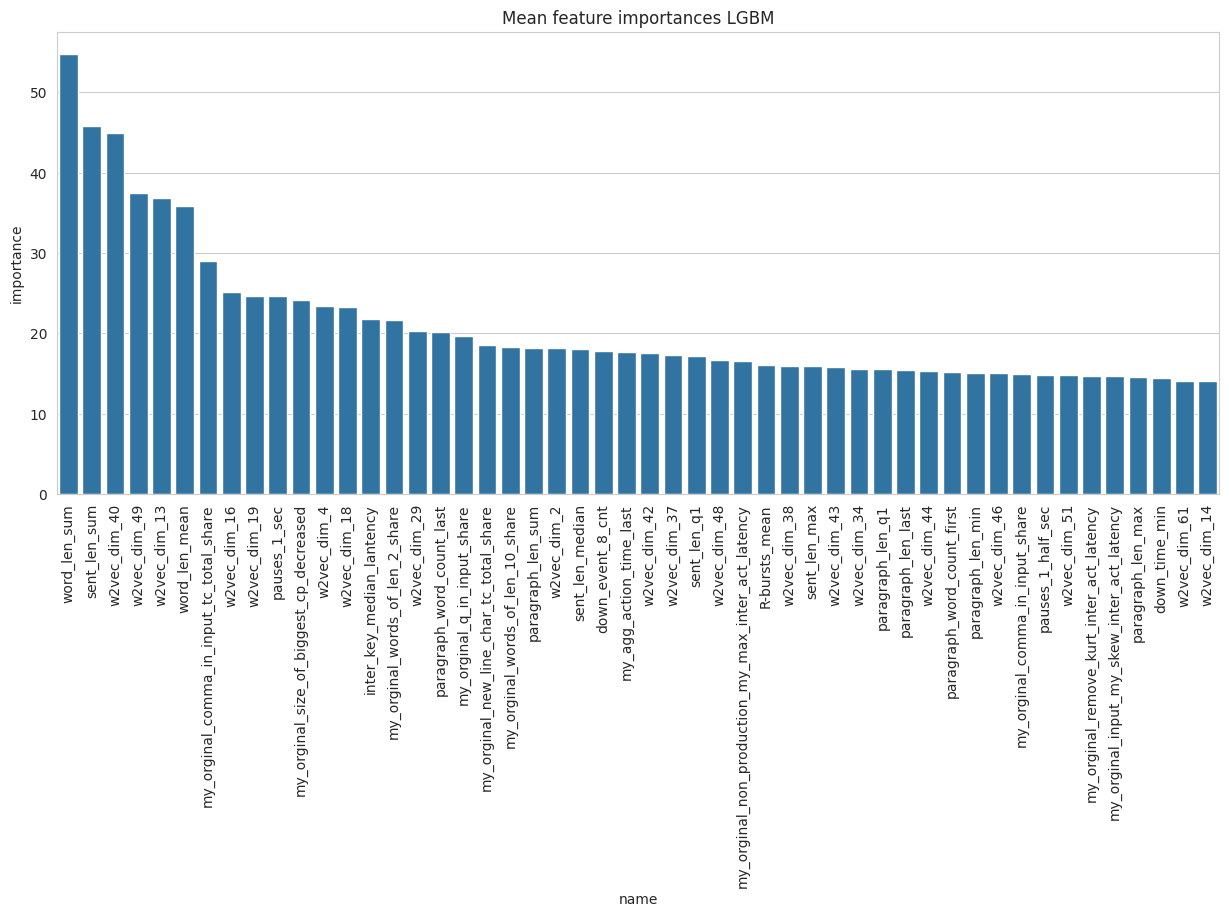

In [137]:
models_lgbm = nfold_dict_lgbm[f"models_lgbm_{cnfg.seed}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_lgbm]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances LGBM")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

### XGB

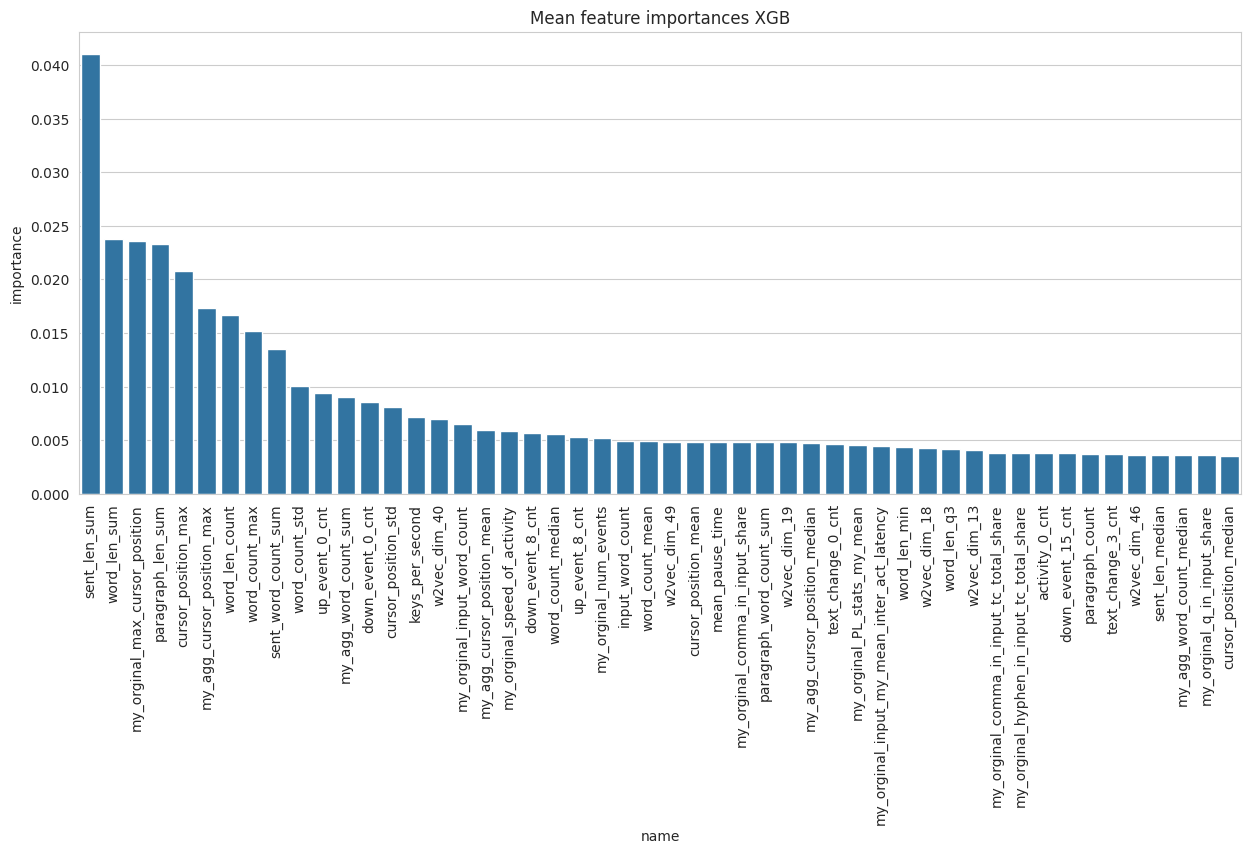

In [138]:
models_xgb = nfold_dict_xgb[f"models_xgb_{cnfg.seed}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_xgb]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances XGB")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

### Catboost

### 42

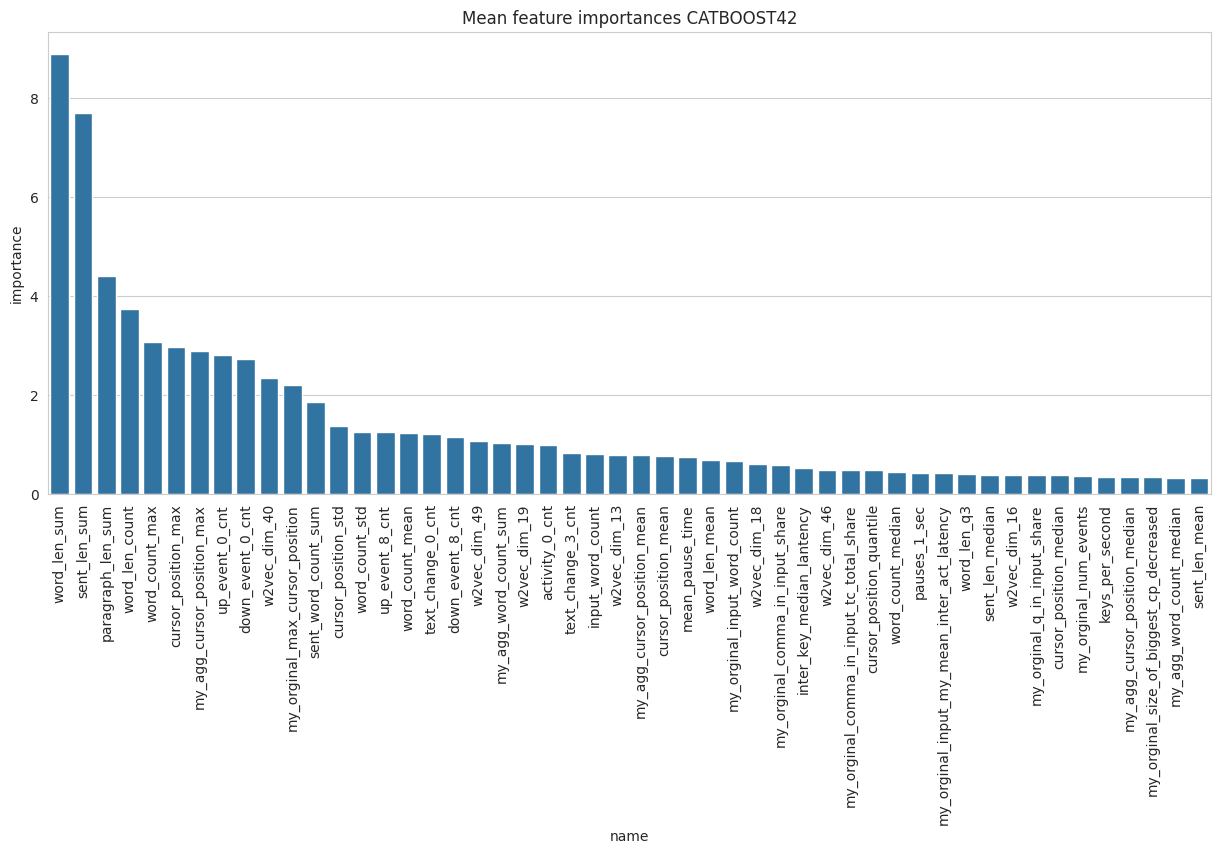

In [139]:
models_catboost_42 = nfold_dict_cat[f"models_catboost_{cnfg.seed}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_catboost_42]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances CATBOOST42")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

### 43

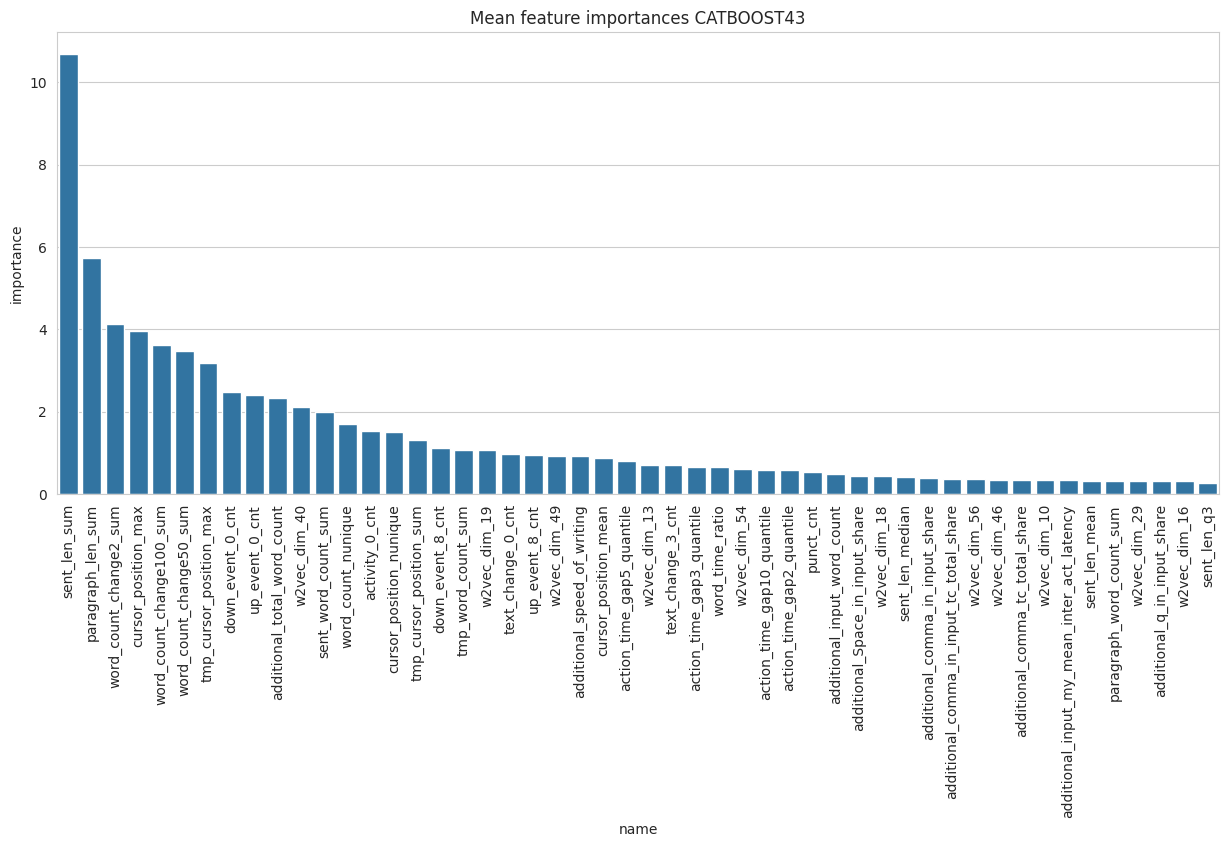

In [231]:
models_catboost_43 = nfold_dict_cat1[f"models_catboost_{cnfg.seed+1}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_catboost_43]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances CATBOOST43")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

### 44

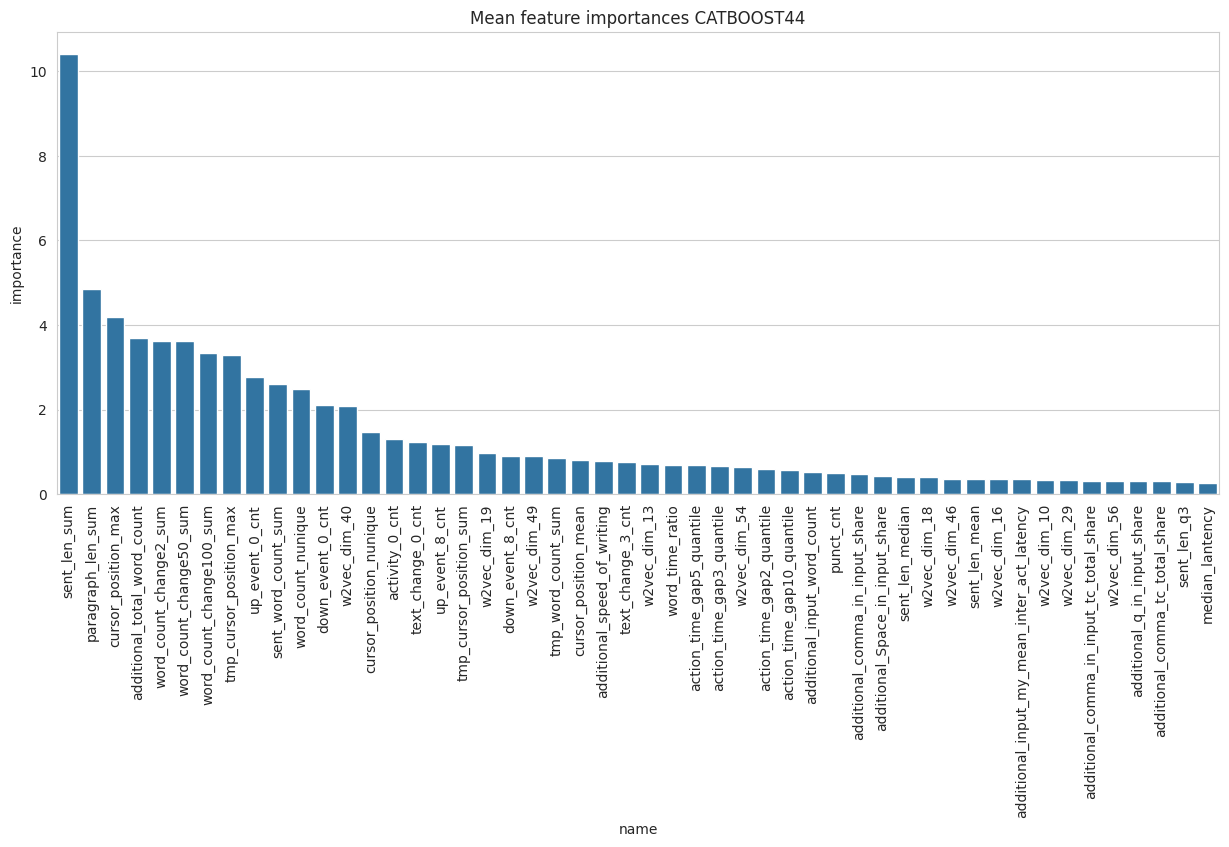

In [232]:
models_catboost_44 = nfold_dict_cat2[f"models_catboost_{cnfg.seed+2}"]
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_catboost_44]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(50), x="name", y="importance")
ax.set_title(f"Mean feature importances CATBOOST44")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()